In [1]:
import sys
#sys.path.append('../models')

import datetime
import os
import sys
import traceback
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import pandas as pd
#import pytorch_lightning as pl
import numpy as np

from networks import *
from datasets import *
from util import *

from matplotlib import pyplot as plt
# from torch.nn import Conv1d, Dropout, MaxPool1d, Flatten
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import log_loss, mean_squared_error

if torch.cuda.is_available():  
    device = torch.device('cuda:0')
    print('Using GPU')
else:
    device = torch.device('cpu')
    print('Using CPU')

Using CPU


## Data loading

In [2]:
data_perc = 1.0

#labeled_dataset = CreditCardFraudDataset(filepath, data_perc)


dataset = 'Stocks'

if dataset is 'Stocks':
    label_type = 'discrete'
    filepath = 'data/transformed_indexData.csv'
    label_name = 'Close'
    train_dataset = StocksDataset(filepath, data_perc, label_name=label_name)
    test_dataset = StocksDataset(filepath, data_perc, label_name=label_name)
    num_classes = 2
    #loss_func = F.mean_squared_error
    bl_loss_func = mean_squared_error

# Load data into pandas, find average of each column
mean = train_dataset.mean()
feature_mean = mean.drop(label_name).to_numpy()

# Data loading params
batch_size = 10
shuffle = True
random_seed = 32
train_ratio = 0.7
data_size = len(train_dataset)

train_size = int(np.floor(data_size * train_ratio))

indices = list(range(data_size))

if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
    
train_indices, test_indices = indices[:train_size], indices[train_size:]

print(len(train_indices))
print(len(test_indices))
print(len(train_dataset))
print(len(test_dataset))

train_sampler = SubsetRandomSampler(train_indices)

test_sampler = SubsetRandomSampler(test_indices)

# Create dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                           batch_size=batch_size, 
                                           sampler=test_sampler)

          Date       Close     Close_7    Close_30  Index
0 -123724800.0  537.103315  537.073204  528.690002     11
1 -123638400.0  533.340027  537.669983  547.287965     11
2 -123552000.0  529.109985  538.099976  535.729151     11
3 -123465600.0  531.440002  537.570007  527.210022     11
4 -123379200.0  532.070007  537.359985  527.840027     11
Date        float64
Close       float64
Close_7     float64
Close_30    float64
Index          int8
dtype: object
[11  5  4  0  3  1 10  2  7 12 13  6  9  8]
Date        0
Close       3
Close_7     0
Close_30    0
Index       0
dtype: int64
161378
Date        0
Close       0
Close_7     0
Close_30    0
Index       0
dtype: int64
161375
          Date       Close     Close_7    Close_30  Index
0 -123724800.0  537.103315  537.073204  528.690002     11
1 -123638400.0  533.340027  537.669983  547.287965     11
2 -123552000.0  529.109985  538.099976  535.729151     11
3 -123465600.0  531.440002  537.570007  527.210022     11
4 -123379200.0  532.0700

In [3]:
print(bl_loss_func)

print(next(iter(train_loader)))

<function mean_squared_error at 0x13f9f41e0>
[tensor([[[1.4613e+09, 1.0356e+04, 1.0100e+04, 1.1000e+01]],

        [[5.3447e+08, 3.0605e+03, 3.0731e+03, 3.0000e+00]],

        [[1.4556e+09, 8.8794e+03, 9.2400e+03, 2.0000e+00]],

        [[1.3985e+09, 8.4253e+03, 8.3279e+03, 1.2000e+01]],

        [[1.4418e+09, 1.0049e+04, 1.0802e+04, 1.1000e+01]],

        [[2.8547e+08, 5.8600e+02, 5.5597e+02, 1.1000e+01]],

        [[6.2113e+08, 2.0647e+03, 2.0537e+03, 1.1000e+01]],

        [[1.3466e+09, 6.4913e+03, 6.4870e+03, 1.2000e+01]],

        [[6.3219e+08, 2.0568e+03, 2.0408e+03, 1.1000e+01]],

        [[1.4870e+09, 1.1549e+04, 1.1690e+04, 2.0000e+00]]]), tensor([10511.0000,  3038.0000,  9135.1104,  8353.4404, 10019.3896,   590.1200,
         2048.9800,  6437.6602,  1939.7780, 11771.8096])]


In [4]:
filepath = 'data/indexData.csv'
df = pd.read_csv(filepath)

df['Date'] = pd.to_datetime(df['Date'])

print(len(pd.unique(df['Index'])))
print(pd.unique(df['Index']))

df.head()

14
['NYA' 'IXIC' 'HSI' '000001.SS' 'GSPTSE' '399001.SZ' 'NSEI' 'GDAXI' 'KS11'
 'SSMI' 'TWII' 'J203.JO' 'N225' 'N100']


Index       Date        Open        High         Low       Close  \
0   NYA 1965-12-31  528.690002  528.690002  528.690002  528.690002   
1   NYA 1966-01-03  527.210022  527.210022  527.210022  527.210022   
2   NYA 1966-01-04  527.840027  527.840027  527.840027  527.840027   
3   NYA 1966-01-05  531.119995  531.119995  531.119995  531.119995   
4   NYA 1966-01-06  532.070007  532.070007  532.070007  532.070007   

    Adj Close  Volume  
0  528.690002     0.0  
1  527.210022     0.0  
2  527.840027     0.0  
3  531.119995     0.0  
4  532.070007     0.0

## Method 1: interpolate missing dates

In [3]:
df_nya = df[df['Index'] == 'NYA']
df_nya = df_nya.set_index('Date')

new_date_idx = pd.date_range(start=df_nya.index.min(), end=df_nya.index.max(), closed=None)

curr_date_idx = pd.DatetimeIndex(df_nya.index)

df_nya_ri = df_nya.reindex(new_date_idx, fill_value=None)

print(len(df_nya))
print(len(df_nya_ri))

#print(df_nya.head())

print(df_nya_ri.head())

df_nya_ri[['Index']] = df_nya_ri[['Index']].fillna(value='NYA')

df_nya_ri = df_nya_ri.interpolate(method='polynomial', order=5)

print(df_nya_ri.head())

13948
20238
           Index        Open        High         Low       Close   Adj Close  \
1965-12-31   NYA  528.690002  528.690002  528.690002  528.690002  528.690002   
1966-01-01   NaN         NaN         NaN         NaN         NaN         NaN   
1966-01-02   NaN         NaN         NaN         NaN         NaN         NaN   
1966-01-03   NYA  527.210022  527.210022  527.210022  527.210022  527.210022   
1966-01-04   NYA  527.840027  527.840027  527.840027  527.840027  527.840027   

            Volume  
1965-12-31     0.0  
1966-01-01     NaN  
1966-01-02     NaN  
1966-01-03     0.0  
1966-01-04     0.0  
           Index        Open        High         Low       Close   Adj Close  \
1965-12-31   NYA  528.690002  528.690002  528.690002  528.690002  528.690002   
1966-01-01   NYA  547.287965  547.287965  547.287965  547.287965  547.287965   
1966-01-02   NYA  535.729151  535.729151  535.729151  535.729151  535.729151   
1966-01-03   NYA  527.210022  527.210022  527.210022  527.210

In [11]:
class StocksDataTransformer(object):
    def __init__(self):
        self.seven_delta = datetime.timedelta(days = 7)
        self.thirty_delta = datetime.timedelta(days = 30)

    def __call__(self, df, index):
        # Create transformed dataframe that has the close price 7/30 days ago as features
        transformed_df = pd.DataFrame(columns = ['Date', 'Close', 'Close_7', 'Close_30'], index=['Date'])
        
        transformed_df = transformed_df.iloc[1: , :]

        date_col = df.index.unique()

        for date_index, row in df.iterrows():
            seven_days_ago = date_index - self.seven_delta
            thirty_days_ago = date_index - self.thirty_delta

            close = row['Close']

            if seven_days_ago in date_col and thirty_days_ago in date_col:
                seven_days_ago_row = df.loc[seven_days_ago]
                thirty_days_ago_row = df.loc[thirty_days_ago]
                
                pd.to_datetime(transformed_df['Date'])
                
                # Transform datetime object to timestamp
                #print(date_index)
                date_timestamp = pd.to_datetime(date_index).value / 10**9
                #print(date_timestamp)
                
                #print(transformed_df.head())

                transformed_df = transformed_df.append({'Index': index, 'Date': date_timestamp, 'Close': close, 'Close_7': seven_days_ago_row['Close'], 'Close_30': thirty_days_ago_row['Close']}, ignore_index=True)
                
        return transformed_df


In [12]:
# #def get_transformed_df(index_df, index):

# index = 'NYA'

# seven_delta = datetime.timedelta(days = 7)
# thirty_delta = datetime.timedelta(days = 30)

# # Create transformed dataframe that has the close price 7/30 days ago as features
# transformed_df = pd.DataFrame(columns = ['Date', 'Close', 'Close_7', 'Close_30'], index=['Date'])

# date_col = df_nya_ri.index.unique()
# print(date_col[0])
# print(type(date_col[0]))

# for date_index, row in df_nya_ri.iterrows():
#     seven_days_ago = date_index - seven_delta
#     thirty_days_ago = date_index - thirty_delta
    
#     close = row['Close']
    
# #     print(date_index)
# #     print(type(date_index))
# #     print(seven_days_ago)
# #     print(type(seven_days_ago))
# #     break;
    
#     if seven_days_ago in date_col and thirty_days_ago in date_col:
        
#         seven_days_ago_row = df_nya_ri.loc[seven_days_ago]
#         thirty_days_ago_row = df_nya_ri.loc[thirty_days_ago]
        
#         transformed_df = transformed_df.append({'Index': index, 'Date': date_index, 'Close': close, 'Close_7': seven_days_ago_row['Close'], 'Close_30': thirty_days_ago_row['Close']}, ignore_index=True)

# print('after')
# print(transformed_df.head())

# # Save transformed dataset
# transformed_df.to_csv('data/transformed_indexData.csv')

In [7]:
index_list = pd.unique(df['Index'])

transformer = StocksDataTransformer()

transformed_df = pd.DataFrame(columns = ['Date', 'Close', 'Close_7', 'Close_30'], index=['Date'])

for index in index_list:
    df_index = df[df['Index'] == index]
    df_index = df_index.set_index('Date')

    new_date_idx = pd.date_range(start=df_index.index.min(), end=df_index.index.max(), closed=None)

    curr_date_idx = pd.DatetimeIndex(df_index.index)

    df_index_ri = df_index.reindex(new_date_idx, fill_value=None)

    print(index)
    print(len(df_index))
    print(len(df_index_ri))

    print(df_index_ri.head())

    df_index_ri[['Index']] = df_index_ri[['Index']].fillna(value=index)
    
    print(df_index_ri.head())

    df_index_ri = df_index_ri.interpolate(method='polynomial', order=5)

    print(df_index_ri.head())
    print('\n')
    
    transformed_df_index = transformer(df_index_ri, index)
    
    print(df_index_ri.head())
    
    transformed_df = transformed_df.append(transformed_df_index)
    
transformed_df.to_csv('data/transformed_indexData.csv')

NYA
13948
20238
           Index        Open        High         Low       Close   Adj Close  \
1965-12-31   NYA  528.690002  528.690002  528.690002  528.690002  528.690002   
1966-01-01   NaN         NaN         NaN         NaN         NaN         NaN   
1966-01-02   NaN         NaN         NaN         NaN         NaN         NaN   
1966-01-03   NYA  527.210022  527.210022  527.210022  527.210022  527.210022   
1966-01-04   NYA  527.840027  527.840027  527.840027  527.840027  527.840027   

            Volume  
1965-12-31     0.0  
1966-01-01     NaN  
1966-01-02     NaN  
1966-01-03     0.0  
1966-01-04     0.0  
           Index        Open        High         Low       Close   Adj Close  \
1965-12-31   NYA  528.690002  528.690002  528.690002  528.690002  528.690002   
1966-01-01   NYA         NaN         NaN         NaN         NaN         NaN   
1966-01-02   NYA         NaN         NaN         NaN         NaN         NaN   
1966-01-03   NYA  527.210022  527.210022  527.210022  527

KeyboardInterrupt: 

## Data Analysis

In [4]:
# For each date, see if date 7 days ago and 30 days ago exists

# For each date, see if date 7 days ago (-1/+1) and 30 days ago (-1/+1) exists

# For each date, see if date 7 days ago (-2/+2) and 30 days ago (-2/+2) exists

# print(df.dtypes)
# print(df['Date'].min())
# print(df['Date'].max())

date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max(), closed=None)

# print(type(df['Date'].min()))
# print(type(date_range[0]))

print(len(date_range))

date_count = 0
date_col = df['Date'].unique()

# print(df['Date'].head())
# print(date_range[0])

date_range = [date.to_datetime64() for date in date_range]

for date in date_range:
    if date in date_col:
        date_count += 1
        #print('in')

#print(type(date_col[0]))
        
print(date_count)

20604
14731


In [ ]:
# Graph close amount per index over time

## Data Cleansing

## Data Transformations

# Data:
### Features: 
#### - Closing price 7 days before
#### - Closing price 30 days before
#### - ???
### Label:
#### - Closing price

# Method 1: predict the closing prices of all 14 indexes on a day

# Method 2: predict the closing prices of 1 stock on a day

# Experiments

### Parameters

In [4]:
epochs = 10
epoch_list = list(range(1, epochs+1))

n_feature = train_dataset[0][0].size()[1]

n_classes = 1

wdecay = 5e-4
lr = 0.03
nesterov = True
no_decay = ['bias', 'bn']

## Baseline Experiment

In [5]:
def train_baseline(model, train_loader, test_loader, loss_func, epochs=10):
    train_loss_list = []
    test_loss_list = []
    
    for epoch in range(epochs):
        #losses_train = AverageMeter()
        #losses_test = AverageMeter()

        progress_bar = tqdm(enumerate(train_loader))
        
        y_true_train = []
        y_pred_train = []

        try:
            for batch_index, (features, targets) in enumerate(train_loader):
                try:
                    features = features.squeeze().data.detach().numpy()
                    targets = targets.squeeze().data.detach().numpy()

                    model.fit(features, targets)

                    pred = model.predict(features)

                    y_true_train = np.hstack((y_true_train, targets))
                    y_pred_train = np.hstack((y_pred_train, pred))

                except RuntimeError as error:
                    print('RuntimeError: {}'.format(error))
        except KeyError as error:
            print('KeyError: {}'.format(error))
            print(batch_index)
            print(features)
            print(targets)
                
        train_loss = loss_func(y_true_train, y_pred_train)
        
        y_true_test = []
        y_pred_test = []
        
        print('Epoch: {}'.format(epoch))
        
        for batch_index, (features, targets) in enumerate(test_loader):
            try:
                features = features.squeeze().data.detach().numpy()
                targets = targets.squeeze().data.detach().numpy()
                
                if len(features.shape) == 1:
                    features = np.expand_dims(features, axis=0)
                    targets = np.expand_dims(targets, axis=0)

                pred = model.predict(features)
                
                y_true_test = np.hstack((y_true_test, targets)).astype(float)
                y_pred_test = np.hstack((y_pred_test, pred)).astype(float)

            except ValueError as error:
                print('ValueError: {}'.format(error))
                print(batch_index)
                print(features)
                print(targets)
        try:
            test_loss = loss_func(y_true_test, y_pred_test)
        except ValueError as error:
            print(y_true_test)
            print(y_pred_test)

        train_loss_list.append(train_loss)
        test_loss_list.append(test_loss)
        
    return train_loss_list, test_loss_list 

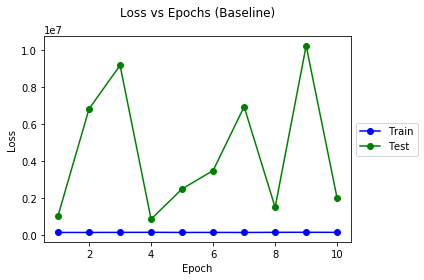

In [29]:
baseline_model = RandomForestRegressor(max_depth=2, random_state=0)

baseline_train_loss_list, baseline_test_loss_list = train_baseline(baseline_model, train_loader, test_loader, bl_loss_func, epochs=10)

plot_multi_curves(epoch_list, [baseline_train_loss_list, baseline_test_loss_list], 'Epoch', 'Loss', ['Train', 'Test'], 'Loss vs Epochs (Baseline)')


## Neural Network

In [5]:
def train_supervised(model, train_loader, test_loader, opt, loss_func, epochs=10):
    train_loss_list = []
    test_loss_list = []
    
    for epoch in range(epochs):
        losses = AverageMeter()

        progress_bar = tqdm(enumerate(train_loader))
        
        for batch_index, (features, targets) in enumerate(train_loader):
            #if features is None or target
            
            try:
                features = features.to(device)
                targets = targets.to(device)

                pred = model(features)
                
                pred = pred.squeeze()
                
#                 print(targets)
#                 print(pred)

                loss = loss_func(pred, targets)

                losses.update(loss)

                # Update progress bar
                progress_bar.set_description("Train Epoch: {epoch}/{epochs:4}. Loss: {loss:.4f}.".format(
                            epoch=epoch + 1,
                            epochs=epochs,
                            batch=batch_index + 1,
                            loss=losses.avg))

                opt.zero_grad()
                loss.backward()
                opt.step()

            except RuntimeError as error:
                print('RuntimeError: {}'.format(error))
                traceback.print_exc()
        
        test_loss = test(test_loader, model, loss_func, epoch)
        
        train_loss_list.append(losses.avg.detach().numpy())
        test_loss_list.append(test_loss.data.detach().numpy())
        
        
    return train_loss_list, test_loss_list 

In [6]:
def test(test_loader, model, loss_func, epoch):
    losses = AverageMeter()
    
    test_loader = tqdm(test_loader)
    
    with torch.no_grad():
        for batch_index, (features, targets) in enumerate(test_loader):
            try:
                features = features.to(device)
                targets = targets.to(device)

                targets = targets.squeeze()

                pred = model(features)
                
                pred = pred.squeeze()

                loss = loss_func(pred, targets)

                losses.update(loss)

                test_loader.set_description("Test Iter: {batch:4}/{iter:4}. Loss: {loss:.4f}.".format(
                    batch=batch_index + 1,
                    iter=len(test_loader),
                    loss=losses.avg))
            except IndexError as error:
                print('IndexError: {}'.format(error))
                print(traceback.format_exc())
                print(batch_index)
                print(features)
                print(targets)
    return losses.avg

In [7]:
loss_func = F.mse_loss

supervised_model = SimpleNetwork(n_feature=n_feature,
                                 n_hidden=5,
                                 n_classes=n_classes)

supervised_model = supervised_model

grouped_parameters = [
        {'params': [p for n, p in supervised_model.named_parameters() if not any(
            nd in n for nd in no_decay)], 'weight_decay': wdecay},
        {'params': [p for n, p in supervised_model.named_parameters() if any(
            nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

# opt_supervised = optim.SGD(grouped_parameters, lr=lr,
#                           momentum=0.9, nesterov=nesterov)

opt_supervised = torch.optim.SGD(supervised_model.parameters(), lr = 0.00001)

supervised_train_loss_list, supervised_test_loss_list = train_supervised(supervised_model, train_loader, test_loader, opt_supervised, loss_func, epochs=epochs)

Train Epoch: 1/  10. Loss: 77168752.0000.: : 0it [01:12, ?it/s] 

Error in dataloader


Train Epoch: 1/  10. Loss: 77440920.0000.: : 0it [01:35, ?it/s]
Test Iter:   75/4842. Loss: 63542960.0000.:   1%|▏         | 68/4842 [00:00<00:54, 86.98it/s]


Test Iter:  149/4842. Loss: 64323212.0000.:   3%|▎         | 149/4842 [00:01<00:55, 84.08it/s]


Test Iter:  224/4842. Loss: 61848780.0000.:   5%|▍         | 221/4842 [00:02<00:55, 82.91it/s]


Test Iter:  299/4842. Loss: 68395648.0000.:   6%|▌         | 293/4842 [00:03<00:55, 82.60it/s]


Test Iter:  374/4842. Loss: 68309072.0000.:   8%|▊         | 365/4842 [00:04<00:54, 82.41it/s]


Test Iter:  448/4842. Loss: 68458496.0000.:   9%|▉         | 446/4842 [00:05<00:53, 82.76it/s]


Test Iter:  523/4842. Loss: 66211236.0000.:  11%|█         | 518/4842 [00:06<00:52, 82.46it/s]


Test Iter:  598/4842. Loss: 68417128.0000.:  12%|█▏        | 590/4842 [00:07<00:49, 85.58it/s]


Test Iter:  672/4842. Loss: 69212696.0000.:  14%|█▍        | 671/4842 [00:08<00:50, 82.78it/s]


Test Iter:  747/4842. Loss: 67965080.0000.:  15%|█▌        | 741/4842 [00:09<00:50, 80.49it/s]


Test Iter:  822/4842. Loss: 68412208.0000.:  17%|█▋        | 813/4842 [00:09<00:48, 82.33it/s]


Test Iter:  896/4842. Loss: 67975024.0000.:  18%|█▊        | 894/4842 [00:10<00:48, 81.95it/s]


Test Iter:  971/4842. Loss: 67628792.0000.:  20%|█▉        | 966/4842 [00:11<00:47, 82.30it/s]


Test Iter: 1046/4842. Loss: 67850576.0000.:  21%|██▏       | 1038/4842 [00:12<00:46, 82.34it/s]


Test Iter: 1119/4842. Loss: 68517072.0000.:  23%|██▎       | 1119/4842 [00:13<00:46, 79.80it/s]


Test Iter: 1193/4842. Loss: 68694888.0000.:  25%|██▍       | 1191/4842 [00:14<00:44, 82.07it/s]


Test Iter: 1267/4842. Loss: 69149320.0000.:  26%|██▌       | 1263/4842 [00:15<00:43, 82.30it/s]


Test Iter: 1341/4842. Loss: 69061848.0000.:  28%|██▊       | 1335/4842 [00:16<00:42, 82.24it/s]


Test Iter: 1415/4842. Loss: 68642152.0000.:  29%|██▉       | 1407/4842 [00:17<00:40, 85.51it/s]


Test Iter: 1488/4842. Loss: 68466800.0000.:  31%|███       | 1488/4842 [00:17<00:38, 86.06it/s]


Test Iter: 1562/4842. Loss: 68614472.0000.:  32%|███▏      | 1560/4842 [00:18<00:38, 84.24it/s]


Test Iter: 1636/4842. Loss: 68574312.0000.:  34%|███▎      | 1632/4842 [00:19<00:38, 83.36it/s]


Test Iter: 1710/4842. Loss: 68609184.0000.:  35%|███▌      | 1704/4842 [00:20<00:36, 85.35it/s]


Test Iter: 1784/4842. Loss: 67801592.0000.:  37%|███▋      | 1776/4842 [00:21<00:36, 85.10it/s]


Test Iter: 1857/4842. Loss: 67977888.0000.:  38%|███▊      | 1857/4842 [00:22<00:35, 84.88it/s]


Test Iter: 1931/4842. Loss: 68034344.0000.:  40%|███▉      | 1929/4842 [00:23<00:35, 82.58it/s]


Test Iter: 2003/4842. Loss: 68183576.0000.:  41%|████▏     | 2001/4842 [00:24<00:34, 82.10it/s]

Error in dataloader



Test Iter: 2077/4842. Loss: 68412016.0000.:  43%|████▎     | 2073/4842 [00:25<00:33, 82.23it/s]


Test Iter: 2151/4842. Loss: 68773632.0000.:  44%|████▍     | 2145/4842 [00:25<00:32, 81.98it/s]


Test Iter: 2225/4842. Loss: 68525160.0000.:  46%|████▌     | 2217/4842 [00:26<00:32, 81.98it/s]


Test Iter: 2298/4842. Loss: 68866568.0000.:  47%|████▋     | 2294/4842 [00:27<00:32, 78.56it/s]


Test Iter: 2371/4842. Loss: 68941992.0000.:  49%|████▉     | 2367/4842 [00:28<00:31, 78.80it/s]


Test Iter: 2444/4842. Loss: 68932488.0000.:  50%|█████     | 2439/4842 [00:29<00:30, 78.55it/s]


Test Iter: 2517/4842. Loss: 69330944.0000.:  52%|█████▏    | 2511/4842 [00:30<00:29, 78.22it/s]


Test Iter: 2581/4842. Loss: 69148256.0000.:  53%|█████▎    | 2575/4842 [00:31<00:29, 77.69it/s]

Error in dataloader



Test Iter: 2654/4842. Loss: 69183760.0000.:  55%|█████▍    | 2652/4842 [00:32<00:26, 82.06it/s]


Test Iter: 2728/4842. Loss: 68980824.0000.:  56%|█████▋    | 2724/4842 [00:33<00:25, 82.36it/s]


Test Iter: 2802/4842. Loss: 68978712.0000.:  58%|█████▊    | 2796/4842 [00:34<00:23, 85.36it/s]


Test Iter: 2876/4842. Loss: 68978624.0000.:  59%|█████▉    | 2868/4842 [00:34<00:22, 85.88it/s]


Test Iter: 2949/4842. Loss: 69659184.0000.:  61%|██████    | 2949/4842 [00:35<00:22, 84.78it/s]


Test Iter: 3023/4842. Loss: 69836216.0000.:  62%|██████▏   | 3021/4842 [00:36<00:21, 83.71it/s]


Test Iter: 3097/4842. Loss: 69809280.0000.:  64%|██████▍   | 3093/4842 [00:37<00:21, 82.50it/s]


Test Iter: 3171/4842. Loss: 69731088.0000.:  65%|██████▌   | 3165/4842 [00:38<00:20, 82.38it/s]


Test Iter: 3245/4842. Loss: 69852488.0000.:  67%|██████▋   | 3237/4842 [00:39<00:20, 80.13it/s]


Test Iter: 3318/4842. Loss: 70100088.0000.:  68%|██████▊   | 3310/4842 [00:40<00:19, 78.49it/s]


Test Iter: 3390/4842. Loss: 70120504.0000.:  70%|███████   | 3390/4842 [00:41<00:19, 75.87it/s]


Test Iter: 3463/4842. Loss: 70048952.0000.:  71%|███████▏  | 3462/4842 [00:42<00:17, 78.21it/s]


Test Iter: 3536/4842. Loss: 70380176.0000.:  73%|███████▎  | 3534/4842 [00:43<00:16, 78.41it/s]


Test Iter: 3610/4842. Loss: 70322832.0000.:  74%|███████▍  | 3601/4842 [00:43<00:15, 80.99it/s]


Test Iter: 3683/4842. Loss: 70468520.0000.:  76%|███████▌  | 3682/4842 [00:44<00:14, 82.09it/s]


Test Iter: 3757/4842. Loss: 70930720.0000.:  78%|███████▊  | 3754/4842 [00:45<00:13, 82.69it/s]


Test Iter: 3831/4842. Loss: 71136584.0000.:  79%|███████▉  | 3826/4842 [00:46<00:12, 83.53it/s]


Test Iter: 3905/4842. Loss: 70991536.0000.:  81%|████████  | 3898/4842 [00:47<00:11, 85.75it/s]


Test Iter: 3979/4842. Loss: 71173192.0000.:  82%|████████▏ | 3970/4842 [00:48<00:10, 85.92it/s]


Test Iter: 4052/4842. Loss: 70939264.0000.:  84%|████████▎ | 4051/4842 [00:49<00:09, 85.66it/s]


Test Iter: 4126/4842. Loss: 70934528.0000.:  85%|████████▌ | 4123/4842 [00:50<00:08, 84.86it/s]


Test Iter: 4200/4842. Loss: 70814024.0000.:  87%|████████▋ | 4195/4842 [00:50<00:07, 83.77it/s]


Test Iter: 4273/4842. Loss: 70947856.0000.:  88%|████████▊ | 4273/4842 [00:51<00:07, 74.97it/s]


Test Iter: 4347/4842. Loss: 70850600.0000.:  90%|████████▉ | 4338/4842 [00:52<00:06, 78.59it/s]


Test Iter: 4419/4842. Loss: 71177624.0000.:  91%|█████████▏| 4419/4842 [00:53<00:05, 78.10it/s]


Test Iter: 4493/4842. Loss: 70865504.0000.:  93%|█████████▎| 4485/4842 [00:54<00:04, 79.22it/s]


Test Iter: 4565/4842. Loss: 71155760.0000.:  94%|█████████▍| 4565/4842 [00:55<00:03, 77.76it/s]


Test Iter: 4638/4842. Loss: 70901496.0000.:  96%|█████████▌| 4637/4842 [00:56<00:02, 77.99it/s]


Test Iter: 4712/4842. Loss: 70595440.0000.:  97%|█████████▋| 4708/4842 [00:57<00:01, 82.14it/s]


Test Iter: 4786/4842. Loss: 70667992.0000.:  99%|█████████▊| 4780/4842 [00:58<00:00, 82.02it/s]


Test Iter: 4842/4842. Loss: 70744016.0000.: 100%|██████████| 4842/4842 [00:59<00:00, 81.95it/s]

Train Epoch: 1/  10. Loss: 77440920.0000.: : 0it [02:34, ?it/s]

Train Epoch: 2/  10. Loss: 27096704.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 28296356.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 29147928.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 24045792.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 22546542.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 21347350.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 21536226.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 21924250.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 29389188.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 29721524.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 30526818.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 30115418.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 32016074.0000.: : 0it [00:00, ?it/s]
Train 

Train Epoch: 2/  10. Loss: 48085680.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 48666196.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 48056088.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 47037508.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 53806460.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 53053700.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 58004632.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 57322576.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 56362292.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 55401720.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 55462936.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 57050532.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 56591920.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 56175264.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 55968112.0000.: : 0it [00:00, ?it/s]
Train Epoch: 2/  10. Loss: 55281824.0000

Train Epoch: 2/  10. Loss: 70308800.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 69985432.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71311792.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71458632.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71312960.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71034072.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 70907920.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71908200.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71958568.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71756208.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71692248.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71754632.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71488296.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 71231336.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 70990248.0000.: : 0it [00:02, ?it/s]
Train Epoch: 2/  10. Loss: 72395488.0000

Train Epoch: 2/  10. Loss: 80217024.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79972624.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79925832.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79771528.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79535840.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79435960.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79190408.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79686496.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79541072.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79425800.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79271120.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 79162384.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 78936072.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 78717496.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 78574328.0000.: : 0it [00:03, ?it/s]
Train Epoch: 2/  10. Loss: 78351752.0000

Train Epoch: 2/  10. Loss: 77250680.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77088256.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76920896.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77426296.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77328528.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77343240.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77207896.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77121832.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 77017464.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76894872.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76888712.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76854000.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76746032.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76710776.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76586696.0000.: : 0it [00:04, ?it/s]
Train Epoch: 2/  10. Loss: 76427376.0000

Train Epoch: 2/  10. Loss: 72692344.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73212776.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73169784.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73814848.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73781808.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73761896.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73755312.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73869144.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73766312.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 73895320.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 74311856.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 74515416.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 74410360.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 74383096.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 74271400.0000.: : 0it [00:06, ?it/s]
Train Epoch: 2/  10. Loss: 74174232.0000

Train Epoch: 2/  10. Loss: 76066352.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 75963944.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76121184.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76037656.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 75968672.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76018680.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 75940584.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76368968.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76490296.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76816336.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76823856.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76742048.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76754616.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76932912.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76940600.0000.: : 0it [00:07, ?it/s]
Train Epoch: 2/  10. Loss: 76854112.0000

Train Epoch: 2/  10. Loss: 77665400.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77611136.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77585504.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77538080.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77455464.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77372232.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77388072.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77321376.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77437936.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77433952.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77348312.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77276032.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77240672.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77226912.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77145624.0000.: : 0it [00:09, ?it/s]
Train Epoch: 2/  10. Loss: 77138376.0000

Train Epoch: 2/  10. Loss: 76777416.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76856944.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76816568.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76859376.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76810712.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76738920.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76722352.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76648128.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76592904.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76817368.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76799176.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76732816.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76657024.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76618296.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76547616.0000.: : 0it [00:10, ?it/s]
Train Epoch: 2/  10. Loss: 76786640.0000

Train Epoch: 2/  10. Loss: 77456960.0000.: : 0it [00:11, ?it/s]
Train Epoch: 2/  10. Loss: 77534376.0000.: : 0it [00:11, ?it/s]
Train Epoch: 2/  10. Loss: 77536224.0000.: : 0it [00:11, ?it/s]
Train Epoch: 2/  10. Loss: 77497976.0000.: : 0it [00:11, ?it/s]
Train Epoch: 2/  10. Loss: 77611296.0000.: : 0it [00:11, ?it/s]
Train Epoch: 2/  10. Loss: 77596552.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 77581520.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 77802288.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 77819392.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78169856.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78214288.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78202184.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78143720.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78171584.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78279592.0000.: : 0it [00:12, ?it/s]
Train Epoch: 2/  10. Loss: 78382368.0000

Train Epoch: 2/  10. Loss: 76276224.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76227928.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76173088.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76114800.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76058072.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76067672.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76029304.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 75980248.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 75941560.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 75908240.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76148464.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76156904.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76106224.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76420880.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76421008.0000.: : 0it [00:13, ?it/s]
Train Epoch: 2/  10. Loss: 76400216.0000

Train Epoch: 2/  10. Loss: 76700856.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76654760.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76611704.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76597368.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76547952.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76532976.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76498624.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76460168.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76437576.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76402424.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76378448.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76394184.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76366240.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76331832.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76287232.0000.: : 0it [00:14, ?it/s]
Train Epoch: 2/  10. Loss: 76239616.0000

Train Epoch: 2/  10. Loss: 75959824.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 75923616.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 75880976.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 75982096.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 75954920.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76065864.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76053320.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76014488.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76197656.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76211056.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76307320.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76272880.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76225408.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76177232.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76298832.0000.: : 0it [00:16, ?it/s]
Train Epoch: 2/  10. Loss: 76269280.0000

Train Epoch: 2/  10. Loss: 76084464.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76050000.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76149480.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76132680.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76119016.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76080080.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76038488.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75997056.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75985816.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 76003528.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75980776.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75940064.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75899776.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75859680.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75820728.0000.: : 0it [00:17, ?it/s]
Train Epoch: 2/  10. Loss: 75776504.0000

Train Epoch: 2/  10. Loss: 75234704.0000.: : 0it [00:18, ?it/s]
Train Epoch: 2/  10. Loss: 75207856.0000.: : 0it [00:18, ?it/s]
Train Epoch: 2/  10. Loss: 75172872.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75159856.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75147128.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75114392.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75095744.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75057176.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75025632.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 74994104.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 74984632.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 74946024.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75051928.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75065968.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75085136.0000.: : 0it [00:19, ?it/s]
Train Epoch: 2/  10. Loss: 75227888.0000

Train Epoch: 2/  10. Loss: 76114616.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76098960.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76060064.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76049048.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76033584.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76006624.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75983904.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75956696.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75932616.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75896712.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75888440.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75976864.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76033064.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 76003568.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75983160.0000.: : 0it [00:20, ?it/s]
Train Epoch: 2/  10. Loss: 75945720.0000

Train Epoch: 2/  10. Loss: 76404264.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76366080.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76477256.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76527208.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76597208.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76643616.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76626400.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76650168.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76625760.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76773528.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76756024.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76746424.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76711360.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76681648.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76674216.0000.: : 0it [00:21, ?it/s]
Train Epoch: 2/  10. Loss: 76644736.0000

Train Epoch: 2/  10. Loss: 76613368.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76602768.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76578160.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76545624.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76590808.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76623696.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76599064.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76655072.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76625272.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76595840.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76568848.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76547216.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76519776.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76494424.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76479144.0000.: : 0it [00:23, ?it/s]
Train Epoch: 2/  10. Loss: 76465728.0000

Train Epoch: 2/  10. Loss: 76270056.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76405432.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76407800.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76503680.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76509264.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76490008.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76472088.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76446072.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76552528.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76617280.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76600352.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76573072.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76548768.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76522784.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76529456.0000.: : 0it [00:24, ?it/s]
Train Epoch: 2/  10. Loss: 76496152.0000

Train Epoch: 2/  10. Loss: 77298000.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77285032.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77336920.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77373552.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77387144.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77373312.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77350120.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77368928.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77368808.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77353024.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77340216.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77321480.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77302704.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77329688.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77309480.0000.: : 0it [00:26, ?it/s]
Train Epoch: 2/  10. Loss: 77287128.0000

Train Epoch: 2/  10. Loss: 77675280.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77659336.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77646696.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77625840.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77610552.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77603432.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77583592.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77638464.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77635984.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77615808.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77690744.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77679488.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77710096.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77689664.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77665112.0000.: : 0it [00:27, ?it/s]
Train Epoch: 2/  10. Loss: 77638544.0000

Train Epoch: 2/  10. Loss: 77077992.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77056024.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77034840.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77077056.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77056392.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77046376.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77050848.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77077040.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77087616.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77070608.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77051704.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77036032.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77011032.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 76987696.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77054032.0000.: : 0it [00:28, ?it/s]
Train Epoch: 2/  10. Loss: 77098920.0000

Train Epoch: 2/  10. Loss: 76907992.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 76883664.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 76884928.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 76937464.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77053552.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77136720.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77139248.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77145072.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77220776.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77197752.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77176992.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77157376.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77224648.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77207904.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77219008.0000.: : 0it [00:30, ?it/s]
Train Epoch: 2/  10. Loss: 77207960.0000

Train Epoch: 2/  10. Loss: 77063496.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 77051456.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 77033712.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 77008552.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76991216.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76968704.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76943136.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76930680.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76905160.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76885176.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76886392.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76866856.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76848920.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76834528.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76820520.0000.: : 0it [00:31, ?it/s]
Train Epoch: 2/  10. Loss: 76797976.0000

Train Epoch: 2/  10. Loss: 77102432.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 77079128.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 77052784.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 77043624.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 77031216.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 77010336.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76995392.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76996520.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76983984.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76960576.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76957568.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76939544.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76918744.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76907936.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76919880.0000.: : 0it [00:33, ?it/s]
Train Epoch: 2/  10. Loss: 76898208.0000

Train Epoch: 2/  10. Loss: 77025360.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77021656.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77004560.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 76979880.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 76979984.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77033800.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77049184.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77034848.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77015768.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77123064.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77180560.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77194176.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77256664.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77298776.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77287672.0000.: : 0it [00:34, ?it/s]
Train Epoch: 2/  10. Loss: 77280392.0000

Train Epoch: 2/  10. Loss: 77271568.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77340048.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77337688.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77333472.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77325008.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77317832.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77338032.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77344632.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77327336.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77306800.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77295184.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77273752.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77312136.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77302696.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77313160.0000.: : 0it [00:36, ?it/s]
Train Epoch: 2/  10. Loss: 77302648.0000

Train Epoch: 2/  10. Loss: 77771720.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77776144.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77758384.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77745880.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77775920.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77781160.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77772056.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77770776.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77750472.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77738816.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77736584.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77788008.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77788904.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77774776.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77774088.0000.: : 0it [00:37, ?it/s]
Train Epoch: 2/  10. Loss: 77803960.0000

Train Epoch: 2/  10. Loss: 77992200.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77981608.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77962592.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77983552.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77988448.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77991544.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77997632.0000.: : 0it [00:38, ?it/s]
Train Epoch: 2/  10. Loss: 77987008.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77977320.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77956752.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77936368.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77932520.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77926920.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77913928.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77903104.0000.: : 0it [00:39, ?it/s]
Train Epoch: 2/  10. Loss: 77885720.0000

Train Epoch: 2/  10. Loss: 77944696.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77926048.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77969448.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77959160.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77952912.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77934120.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77925800.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77929696.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77913640.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77966920.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 78000496.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 78007552.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77995288.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77979320.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77978968.0000.: : 0it [00:40, ?it/s]
Train Epoch: 2/  10. Loss: 77958680.0000

Train Epoch: 2/  10. Loss: 77698616.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77684704.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77672672.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77667208.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77657432.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77643056.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77628104.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77679920.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77678232.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77662120.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77742912.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77732488.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77717488.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77707608.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77693840.0000.: : 0it [00:41, ?it/s]
Train Epoch: 2/  10. Loss: 77682256.0000

Train Epoch: 2/  10. Loss: 77532496.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77521880.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77546384.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77532536.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77516720.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77501944.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77482480.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77464200.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77470536.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77452408.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77442896.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77431760.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77415392.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77404320.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77419064.0000.: : 0it [00:43, ?it/s]
Train Epoch: 2/  10. Loss: 77416416.0000

Train Epoch: 2/  10. Loss: 77442288.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77478296.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77465280.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77451304.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77434040.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77416200.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77402752.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77396248.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77380328.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77367880.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77398784.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77386664.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77368760.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77357664.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77340400.0000.: : 0it [00:44, ?it/s]
Train Epoch: 2/  10. Loss: 77323080.0000

Train Epoch: 2/  10. Loss: 77146600.0000.: : 0it [00:45, ?it/s]
Train Epoch: 2/  10. Loss: 77131840.0000.: : 0it [00:45, ?it/s]
Train Epoch: 2/  10. Loss: 77120976.0000.: : 0it [00:45, ?it/s]
Train Epoch: 2/  10. Loss: 77116368.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77155024.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77148016.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77136424.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77172864.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77206080.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77220504.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77215640.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77198384.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77193392.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77187936.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77226872.0000.: : 0it [00:46, ?it/s]
Train Epoch: 2/  10. Loss: 77216432.0000

Train Epoch: 2/  10. Loss: 77251832.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77237664.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77220904.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77228752.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77215312.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77205584.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77194360.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77182824.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77171832.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77160312.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77210424.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77209120.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77196400.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77220376.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77241424.0000.: : 0it [00:47, ?it/s]
Train Epoch: 2/  10. Loss: 77231752.0000

Train Epoch: 2/  10. Loss: 77642488.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77630504.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77618384.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77605528.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77593656.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77628312.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77613672.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77644224.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77641088.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77679272.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77718064.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77709904.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77694336.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77678760.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77663192.0000.: : 0it [00:48, ?it/s]
Train Epoch: 2/  10. Loss: 77650608.0000

Train Epoch: 2/  10. Loss: 77628656.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77619200.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77637520.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77630176.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77618792.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77659208.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77664808.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77700248.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77695904.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77687984.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77677320.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77667976.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77656168.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77665248.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77707944.0000.: : 0it [00:50, ?it/s]
Train Epoch: 2/  10. Loss: 77709984.0000

Train Epoch: 2/  10. Loss: 77927536.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77962896.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77962456.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 78006360.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77993296.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77985072.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77978056.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77968440.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77995704.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77988912.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 78026168.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 78018928.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 78004952.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77988664.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77981576.0000.: : 0it [00:51, ?it/s]
Train Epoch: 2/  10. Loss: 77967592.0000

Train Epoch: 2/  10. Loss: 78095696.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78084616.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78088184.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78094544.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78085776.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78074104.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78095992.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78091752.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78084024.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78071488.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78079456.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78065904.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78054576.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78089216.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78075720.0000.: : 0it [00:53, ?it/s]
Train Epoch: 2/  10. Loss: 78061320.0000

Train Epoch: 2/  10. Loss: 78000112.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 77993912.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 77997216.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78016008.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78011360.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78051816.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78051392.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78041840.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78026832.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78076288.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78101064.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78099720.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78126512.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78122000.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78122352.0000.: : 0it [00:54, ?it/s]
Train Epoch: 2/  10. Loss: 78113112.0000

Train Epoch: 2/  10. Loss: 77768456.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77755568.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77743184.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77734800.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77761936.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77758144.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77860976.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77884552.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77973336.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77960424.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77946440.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77932768.0000.: : 0it [00:55, ?it/s]
Train Epoch: 2/  10. Loss: 77945464.0000.: : 0it [00:56, ?it/s]
Train Epoch: 2/  10. Loss: 77940032.0000.: : 0it [00:56, ?it/s]
Train Epoch: 2/  10. Loss: 77956280.0000.: : 0it [00:56, ?it/s]
Train Epoch: 2/  10. Loss: 77947912.0000

Train Epoch: 2/  10. Loss: 77753848.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77757576.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77781768.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77777776.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77769488.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77760792.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77752128.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77740328.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77728256.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77716936.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77703976.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77691408.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77685840.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77679192.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77679056.0000.: : 0it [00:57, ?it/s]
Train Epoch: 2/  10. Loss: 77677776.0000

Train Epoch: 2/  10. Loss: 77432168.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77418784.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77406264.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77395136.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77429712.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77417920.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77445448.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77444952.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77430240.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77417664.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77405864.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77440216.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77495144.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77510384.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77519656.0000.: : 0it [00:58, ?it/s]
Train Epoch: 2/  10. Loss: 77508000.0000

Train Epoch: 2/  10. Loss: 77493632.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77482032.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77469864.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77488176.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77483280.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77516640.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77528768.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77531608.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77552952.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77548528.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77541968.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77536824.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77527248.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77514584.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77509960.0000.: : 0it [01:00, ?it/s]
Train Epoch: 2/  10. Loss: 77540680.0000

Train Epoch: 2/  10. Loss: 77429064.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77420968.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77408960.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77397440.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77435184.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77426368.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77419016.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77411632.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77400264.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77388360.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77419456.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77419808.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77409440.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77399568.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77388448.0000.: : 0it [01:01, ?it/s]
Train Epoch: 2/  10. Loss: 77376040.0000

Train Epoch: 2/  10. Loss: 77428568.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77461264.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77471736.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77480576.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77472736.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77460184.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77457840.0000.: : 0it [01:02, ?it/s]
Train Epoch: 2/  10. Loss: 77456528.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77465560.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77457864.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77446008.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77443808.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77502664.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77508808.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77495712.0000.: : 0it [01:03, ?it/s]
Train Epoch: 2/  10. Loss: 77490656.0000

Train Epoch: 2/  10. Loss: 77517920.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77507520.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77546320.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77561768.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77564048.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77556440.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77547648.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77539176.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77527144.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77515336.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77506296.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77501840.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77495440.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77483744.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77471088.0000.: : 0it [01:04, ?it/s]
Train Epoch: 2/  10. Loss: 77474016.0000

Train Epoch: 2/  10. Loss: 77387016.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77378352.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77373216.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77399320.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77433520.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77424632.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77452216.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77447920.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77485792.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77496144.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77483696.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77473688.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77461712.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77453176.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77447464.0000.: : 0it [01:05, ?it/s]
Train Epoch: 2/  10. Loss: 77437992.0000

Train Epoch: 2/  10. Loss: 77409512.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77400952.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77391568.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77386672.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77377632.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77398296.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77394984.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77461176.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77463464.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77453272.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77451672.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77442088.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77439064.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77462416.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77459416.0000.: : 0it [01:07, ?it/s]
Train Epoch: 2/  10. Loss: 77449064.0000

Train Epoch: 2/  10. Loss: 77520456.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77509688.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77498312.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77495984.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77486576.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77477432.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77470944.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77498008.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77492032.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77481232.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77496944.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77486640.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77490824.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77507104.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77509424.0000.: : 0it [01:08, ?it/s]
Train Epoch: 2/  10. Loss: 77532496.0000

Train Epoch: 2/  10. Loss: 77536600.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77525656.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77522416.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77512808.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77502568.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77509192.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77521984.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77545384.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77548432.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77571368.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77568976.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77559976.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77550352.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77538800.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77533384.0000.: : 0it [01:10, ?it/s]
Train Epoch: 2/  10. Loss: 77522912.0000

Train Epoch: 2/  10. Loss: 77488456.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77481208.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77470232.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77459760.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77449592.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77485712.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77475936.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77467928.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77457600.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77446760.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77435376.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77437936.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77438976.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77440288.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77466496.0000.: : 0it [01:11, ?it/s]
Train Epoch: 2/  10. Loss: 77466824.0000

Train Epoch: 2/  10. Loss: 77530712.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77527832.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77529240.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77526608.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77524520.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77522776.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77515112.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77512568.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77552344.0000.: : 0it [01:12, ?it/s]
Train Epoch: 2/  10. Loss: 77579072.0000.: : 0it [01:13, ?it/s]
Train Epoch: 2/  10. Loss: 77583296.0000.: : 0it [01:13, ?it/s]
Train Epoch: 2/  10. Loss: 77583336.0000.: : 0it [01:13, ?it/s]
Train Epoch: 2/  10. Loss: 77574896.0000.: : 0it [01:13, ?it/s]
Train Epoch: 2/  10. Loss: 77566336.0000.: : 0it [01:13, ?it/s]
Train Epoch: 2/  10. Loss: 77628912.0000.: : 0it [01:13, ?it/s]
Train Epoch: 2/  10. Loss: 77631264.0000

Train Epoch: 2/  10. Loss: 77524624.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77517872.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77523224.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77514408.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77506288.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77506256.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77496712.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77514344.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77505200.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77495896.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77520840.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77515640.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77528608.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77524760.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77518736.0000.: : 0it [01:14, ?it/s]
Train Epoch: 2/  10. Loss: 77507928.0000

Train Epoch: 2/  10. Loss: 77595008.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77587424.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77578472.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77569832.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77560264.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77553296.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77542960.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77538088.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77534024.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77527416.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77520432.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77511088.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77504800.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77494640.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77518736.0000.: : 0it [01:15, ?it/s]
Train Epoch: 2/  10. Loss: 77521752.0000

Train Epoch: 2/  10. Loss: 77692160.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77688912.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77682496.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77672288.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77664368.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77654032.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77646504.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77678072.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77673368.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77704832.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77700456.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77717112.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77720752.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77716624.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77709456.0000.: : 0it [01:17, ?it/s]
Train Epoch: 2/  10. Loss: 77702920.0000

Train Epoch: 2/  10. Loss: 77454656.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77448056.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77439080.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77429176.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77419768.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77457360.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77451272.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77441840.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77434904.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77426488.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77425256.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77416216.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77422312.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77419016.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77412776.0000.: : 0it [01:18, ?it/s]
Train Epoch: 2/  10. Loss: 77425640.0000

Train Epoch: 2/  10. Loss: 77508048.0000.: : 0it [01:19, ?it/s]
Train Epoch: 2/  10. Loss: 77520128.0000.: : 0it [01:19, ?it/s]
Train Epoch: 2/  10. Loss: 77520184.0000.: : 0it [01:19, ?it/s]
Train Epoch: 2/  10. Loss: 77516880.0000.: : 0it [01:19, ?it/s]
Train Epoch: 2/  10. Loss: 77506656.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77497912.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77488208.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77545456.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77546312.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77571808.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77563016.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77553296.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77542576.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77535488.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77524896.0000.: : 0it [01:20, ?it/s]
Train Epoch: 2/  10. Loss: 77516824.0000

Train Epoch: 2/  10. Loss: 77362608.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77363136.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77359072.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77353496.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77344792.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77343328.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77336312.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77329144.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77326016.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77319344.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77326632.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77324752.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77315320.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77306736.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77296824.0000.: : 0it [01:21, ?it/s]
Train Epoch: 2/  10. Loss: 77290976.0000

Train Epoch: 2/  10. Loss: 77102312.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77106400.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77119816.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77119496.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77113784.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77108752.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77102448.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77093976.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77088488.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77095448.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77109672.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77123816.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77124544.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77123576.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77114992.0000.: : 0it [01:22, ?it/s]
Train Epoch: 2/  10. Loss: 77129384.0000

Train Epoch: 2/  10. Loss: 76993744.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76987080.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76979056.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76972088.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76963712.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76954368.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76957984.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76953696.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76962592.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76959464.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76954440.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76950176.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76942968.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76934632.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76927576.0000.: : 0it [01:24, ?it/s]
Train Epoch: 2/  10. Loss: 76937648.0000

Train Epoch: 2/  10. Loss: 76933688.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76960824.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76957104.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76954000.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76945032.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76952272.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76972096.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76971264.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76962208.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76952976.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76944784.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76936416.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76965056.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76957608.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76956448.0000.: : 0it [01:25, ?it/s]
Train Epoch: 2/  10. Loss: 76950856.0000

Train Epoch: 2/  10. Loss: 77099768.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77093176.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77087560.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77080272.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77078920.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77099432.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77126288.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77132824.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77123848.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77117616.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77133224.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77124632.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77121000.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77113128.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77103400.0000.: : 0it [01:27, ?it/s]
Train Epoch: 2/  10. Loss: 77095752.0000

Train Epoch: 2/  10. Loss: 77132264.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77128192.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77146560.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77148792.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77157928.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77154792.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77148048.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77145704.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77183728.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77183672.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77182200.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77175184.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77189328.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77184152.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77177072.0000.: : 0it [01:28, ?it/s]
Train Epoch: 2/  10. Loss: 77169152.0000

Train Epoch: 2/  10. Loss: 77066176.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77059608.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77053568.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77044672.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77047568.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77040432.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77033008.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77039792.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77034216.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77028056.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77020776.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77040464.0000.: : 0it [01:29, ?it/s]
Train Epoch: 2/  10. Loss: 77044672.0000.: : 0it [01:30, ?it/s]
Train Epoch: 2/  10. Loss: 77036056.0000.: : 0it [01:30, ?it/s]
Train Epoch: 2/  10. Loss: 77036424.0000.: : 0it [01:30, ?it/s]
Train Epoch: 2/  10. Loss: 77029032.0000

Train Epoch: 2/  10. Loss: 77002336.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76994512.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76986864.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76980976.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76976464.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76970376.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76965352.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76957400.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76953400.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76944664.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76936864.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76932912.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76926208.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76922104.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76913792.0000.: : 0it [01:31, ?it/s]
Train Epoch: 2/  10. Loss: 76944744.0000

Train Epoch: 2/  10. Loss: 76743240.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76738144.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76738080.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76732168.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76725208.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76719216.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76710776.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76705576.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76706344.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76699728.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76700408.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76692488.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76688600.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76682832.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76683640.0000.: : 0it [01:32, ?it/s]
Train Epoch: 2/  10. Loss: 76678736.0000

Train Epoch: 2/  10. Loss: 76692720.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76684152.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76694696.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76690880.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76682384.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76674584.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76679728.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76674144.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76670048.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76662904.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76655032.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76676728.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76669536.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76662552.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76654376.0000.: : 0it [01:34, ?it/s]
Train Epoch: 2/  10. Loss: 76669688.0000

Train Epoch: 2/  10. Loss: 76726288.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76733080.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76728480.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76724176.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76719944.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76733296.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76735552.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76733712.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76731928.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76724776.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76733928.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76732544.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76751008.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76754736.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76769152.0000.: : 0it [01:35, ?it/s]
Train Epoch: 2/  10. Loss: 76780152.0000

Train Epoch: 2/  10. Loss: 76512744.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76509552.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76502440.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76494472.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76514776.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76508544.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76500848.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76500488.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76496696.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76513808.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76512600.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76505472.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76507648.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76531160.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76529000.0000.: : 0it [01:37, ?it/s]
Train Epoch: 2/  10. Loss: 76526448.0000

Train Epoch: 2/  10. Loss: 76493304.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76494160.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76486680.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76492784.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76485080.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76478608.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76470176.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76475272.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76472712.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76466464.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76461880.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76463520.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76461072.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76503304.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76517488.0000.: : 0it [01:38, ?it/s]
Train Epoch: 2/  10. Loss: 76518856.0000

Train Epoch: 2/  10. Loss: 76558672.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76553896.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76548808.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76568096.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76580208.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76580216.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76580720.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76583104.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76580968.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76577184.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76572144.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76573744.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76576240.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76573272.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76597280.0000.: : 0it [01:40, ?it/s]
Train Epoch: 2/  10. Loss: 76592544.0000

Train Epoch: 2/  10. Loss: 76535104.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76530200.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76526576.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76520288.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76512816.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76506072.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76506544.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76506024.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76499552.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76493080.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76488200.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76487312.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76479504.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76473328.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76488824.0000.: : 0it [01:41, ?it/s]
Train Epoch: 2/  10. Loss: 76489800.0000

Train Epoch: 2/  10. Loss: 76487472.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76484720.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76477992.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76493696.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76487392.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76480896.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76473656.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76466872.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76460776.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76456592.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76454896.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76455488.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76448664.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76442608.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76435264.0000.: : 0it [01:42, ?it/s]
Train Epoch: 2/  10. Loss: 76448680.0000

Train Epoch: 2/  10. Loss: 76440912.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76435920.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76427936.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76421176.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76439288.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76433856.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76434384.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76427584.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76443112.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76456360.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76456304.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76454800.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76448416.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76444096.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76441064.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76458816.0000

Error in dataloader



Train Epoch: 2/  10. Loss: 76442872.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76459040.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76457184.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76453376.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76462240.0000.: : 0it [01:44, ?it/s]
Train Epoch: 2/  10. Loss: 76457784.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76451816.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76452048.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76447856.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76475880.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76485320.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76528792.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76527256.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76523072.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76515240.0000.: : 0it [01:45, ?it/s]
Train Epoch: 2/  10. Loss: 76510464.000

Train Epoch: 2/  10. Loss: 76549440.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76543472.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76544504.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76548864.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76542264.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76563136.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76561160.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76554832.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76546784.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76566408.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76564360.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76557536.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76551928.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76571928.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76567136.0000.: : 0it [01:46, ?it/s]
Train Epoch: 2/  10. Loss: 76560256.0000

Train Epoch: 2/  10. Loss: 76547184.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76540264.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76534120.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76528744.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76521320.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76516248.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76534952.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76535032.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76542112.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76537616.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76553952.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76553064.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76547368.0000.: : 0it [01:47, ?it/s]
Train Epoch: 2/  10. Loss: 76557104.0000.: : 0it [01:48, ?it/s]
Train Epoch: 2/  10. Loss: 76552024.0000.: : 0it [01:48, ?it/s]
Train Epoch: 2/  10. Loss: 76544816.0000

Train Epoch: 2/  10. Loss: 76507808.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76500888.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76496080.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76489816.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76484720.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76480992.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76484904.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76482272.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76480024.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76476080.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76470096.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76482696.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76499368.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76503056.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76521480.0000.: : 0it [01:49, ?it/s]
Train Epoch: 2/  10. Loss: 76517512.0000

Train Epoch: 2/  10. Loss: 76665648.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76659872.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76654408.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76654000.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76653016.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76686424.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76688408.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76723248.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76722728.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76728520.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76731760.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76730400.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76726200.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76724528.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76734680.0000.: : 0it [01:50, ?it/s]
Train Epoch: 2/  10. Loss: 76730920.0000

Train Epoch: 2/  10. Loss: 76677432.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76680656.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76675984.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76669472.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76666016.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76661432.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76654968.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76672104.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76666872.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76687472.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76708336.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76714808.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76716320.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76710616.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76733328.0000.: : 0it [01:52, ?it/s]
Train Epoch: 2/  10. Loss: 76727512.0000

Train Epoch: 2/  10. Loss: 76859632.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76853752.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76851824.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76846584.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76839472.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76831696.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76824704.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76819304.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76815488.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76813384.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76810472.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76807208.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76805808.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76799280.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76792048.0000.: : 0it [01:53, ?it/s]
Train Epoch: 2/  10. Loss: 76826480.0000

Train Epoch: 2/  10. Loss: 76955264.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76950200.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76946872.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76942256.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76935848.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76935232.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76942720.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76945392.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76940920.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76953952.0000.: : 0it [01:54, ?it/s]
Train Epoch: 2/  10. Loss: 76953728.0000.: : 0it [01:55, ?it/s]
Train Epoch: 2/  10. Loss: 76958240.0000.: : 0it [01:55, ?it/s]
Train Epoch: 2/  10. Loss: 76954248.0000.: : 0it [01:55, ?it/s]
Train Epoch: 2/  10. Loss: 76947800.0000.: : 0it [01:55, ?it/s]
Train Epoch: 2/  10. Loss: 76962280.0000.: : 0it [01:55, ?it/s]
Train Epoch: 2/  10. Loss: 76975928.0000

Train Epoch: 2/  10. Loss: 77267744.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77261184.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77255904.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77251600.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77244800.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77238368.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77237728.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77232248.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77235976.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77238424.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77248616.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77244888.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77239328.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77232464.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77227000.0000.: : 0it [01:56, ?it/s]
Train Epoch: 2/  10. Loss: 77224216.0000

Train Epoch: 2/  10. Loss: 77166528.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77164512.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77158352.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77152920.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77151088.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77145240.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77139440.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77133688.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77130248.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77127608.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77121040.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77114776.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77133216.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77132624.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77133216.0000.: : 0it [01:57, ?it/s]
Train Epoch: 2/  10. Loss: 77130032.0000

Train Epoch: 2/  10. Loss: 77068768.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77067944.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77061928.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77063840.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77057592.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77053520.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77054304.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77049760.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77048120.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77043344.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77048144.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77058976.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77055456.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77052784.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77048216.0000.: : 0it [01:59, ?it/s]
Train Epoch: 2/  10. Loss: 77046584.0000

Train Epoch: 2/  10. Loss: 77273848.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77269632.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77266336.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77263536.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77257520.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77252528.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77248288.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77246896.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77241616.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77236128.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77231784.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77226480.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77222152.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77217408.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77215104.0000.: : 0it [02:00, ?it/s]
Train Epoch: 2/  10. Loss: 77212152.0000

Train Epoch: 2/  10. Loss: 77134416.0000.: : 0it [02:01, ?it/s]
Train Epoch: 2/  10. Loss: 77130808.0000.: : 0it [02:01, ?it/s]
Train Epoch: 2/  10. Loss: 77127208.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77124848.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77136944.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77148280.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77153056.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77166504.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77166232.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77159952.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77175024.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77172480.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77185184.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77188384.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77183248.0000.: : 0it [02:02, ?it/s]
Train Epoch: 2/  10. Loss: 77176952.0000

Train Epoch: 2/  10. Loss: 77215336.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77210064.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77225848.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77222816.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77221392.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77219400.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77214784.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77236472.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77244208.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77240848.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77235328.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77235424.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77232560.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77227376.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77223952.0000.: : 0it [02:03, ?it/s]
Train Epoch: 2/  10. Loss: 77238768.0000

Train Epoch: 2/  10. Loss: 77195464.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77195720.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77191288.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77187376.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77183008.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77180208.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77176480.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77189160.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77186208.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77182232.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77176336.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77170392.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77166296.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77161192.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77157544.0000.: : 0it [02:04, ?it/s]
Train Epoch: 2/  10. Loss: 77152112.0000

Train Epoch: 2/  10. Loss: 77051712.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77046536.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77047160.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77051456.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77049152.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77044344.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77038976.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77032760.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77059600.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77056808.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77052240.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77050544.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77044976.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77040592.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77037816.0000.: : 0it [02:06, ?it/s]
Train Epoch: 2/  10. Loss: 77055048.0000

Train Epoch: 2/  10. Loss: 77178440.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77188280.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77207144.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77212096.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77215168.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77212880.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77213648.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77207752.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77206528.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77200488.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77196600.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77191104.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77204192.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77200896.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77195192.0000.: : 0it [02:07, ?it/s]
Train Epoch: 2/  10. Loss: 77192480.0000

Train Epoch: 2/  10. Loss: 77360496.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77354648.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77349264.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77350064.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77360376.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77356936.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77373840.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77372280.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77388064.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77385104.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77382192.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77377568.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77374800.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77370304.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77365072.0000.: : 0it [02:09, ?it/s]
Train Epoch: 2/  10. Loss: 77375720.0000

Train Epoch: 2/  10. Loss: 77351776.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77349784.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77344552.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77339104.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77370584.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77372608.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77378328.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77381032.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77378672.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77379152.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77387416.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77386200.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77386176.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77382032.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77378432.0000.: : 0it [02:10, ?it/s]
Train Epoch: 2/  10. Loss: 77373616.0000

Error in dataloader


Test Iter: 4346/4842. Loss: 78280240.0000.:  90%|████████▉ | 4340/4842 [00:35<00:04, 122.39it/s]

Error in dataloader


Test Iter: 4842/4842. Loss: 78306712.0000.: 100%|██████████| 4842/4842 [00:39<00:00, 121.25it/s]
Train Epoch: 2/  10. Loss: 77235168.0000.: : 0it [02:52, ?it/s]
Train Epoch: 3/  10. Loss: 76993768.0000.: : 0it [01:24, ?it/s] 

Error in dataloader


Train Epoch: 3/  10. Loss: 76736584.0000.: : 0it [01:32, ?it/s]
Test Iter:   75/4842. Loss: 84711952.0000.:   1%|▏         | 71/4842 [00:00<00:53, 89.37it/s]


Test Iter:  150/4842. Loss: 81622504.0000.:   3%|▎         | 149/4842 [00:01<00:57, 81.51it/s]


Test Iter:  225/4842. Loss: 83818680.0000.:   5%|▍         | 221/4842 [00:02<00:57, 80.75it/s]


Test Iter:  300/4842. Loss: 81907200.0000.:   6%|▌         | 293/4842 [00:03<00:56, 80.90it/s]


Test Iter:  374/4842. Loss: 80770800.0000.:   8%|▊         | 367/4842 [00:04<00:57, 78.19it/s]


Test Iter:  447/4842. Loss: 81241216.0000.:   9%|▉         | 447/4842 [00:05<00:56, 78.39it/s]


Test Iter:  521/4842. Loss: 81185152.0000.:  11%|█         | 519/4842 [00:06<00:55, 78.13it/s]


Test Iter:  595/4842. Loss: 81976352.0000.:  12%|█▏        | 591/4842 [00:07<00:54, 77.90it/s]


Test Iter:  669/4842. Loss: 82048976.0000.:  14%|█▍        | 667/4842 [00:08<00:51, 81.34it/s]


Test Iter:  744/4842. Loss: 82799776.0000.:  15%|█▌        | 739/4842 [00:09<00:50, 80.86it/s]


Test Iter:  819/4842. Loss: 82745696.0000.:  17%|█▋        | 811/4842 [00:10<00:49, 81.97it/s]


Test Iter:  893/4842. Loss: 83214392.0000.:  18%|█▊        | 892/4842 [00:11<00:48, 81.96it/s]


Test Iter:  968/4842. Loss: 83324616.0000.:  20%|█▉        | 960/4842 [00:12<00:49, 78.25it/s]


Test Iter: 1042/4842. Loss: 82756816.0000.:  21%|██▏       | 1034/4842 [00:13<00:47, 79.69it/s]


Test Iter: 1115/4842. Loss: 83452352.0000.:  23%|██▎       | 1115/4842 [00:13<00:45, 81.21it/s]


Test Iter: 1189/4842. Loss: 83762008.0000.:  25%|██▍       | 1187/4842 [00:14<00:45, 79.72it/s]


Test Iter: 1262/4842. Loss: 83707376.0000.:  26%|██▌       | 1259/4842 [00:15<00:45, 78.06it/s]


Test Iter: 1335/4842. Loss: 83677608.0000.:  27%|██▋       | 1331/4842 [00:16<00:44, 78.51it/s]


Test Iter: 1408/4842. Loss: 83916464.0000.:  29%|██▉       | 1403/4842 [00:17<00:43, 78.72it/s]


Test Iter: 1481/4842. Loss: 84221568.0000.:  30%|███       | 1476/4842 [00:18<00:43, 78.16it/s]


Test Iter: 1554/4842. Loss: 83818368.0000.:  32%|███▏      | 1548/4842 [00:19<00:42, 78.34it/s]


Test Iter: 1627/4842. Loss: 83806912.0000.:  33%|███▎      | 1620/4842 [00:20<00:41, 77.76it/s]


Test Iter: 1700/4842. Loss: 83883688.0000.:  35%|███▍      | 1692/4842 [00:21<00:39, 78.99it/s]


Test Iter: 1773/4842. Loss: 83563176.0000.:  37%|███▋      | 1773/4842 [00:22<00:37, 82.26it/s]


Test Iter: 1847/4842. Loss: 83625584.0000.:  38%|███▊      | 1845/4842 [00:23<00:36, 81.65it/s]


Test Iter: 1921/4842. Loss: 83388632.0000.:  40%|███▉      | 1917/4842 [00:24<00:35, 82.24it/s]


Test Iter: 1995/4842. Loss: 82896800.0000.:  41%|████      | 1989/4842 [00:24<00:34, 82.10it/s]


Test Iter: 2069/4842. Loss: 82618616.0000.:  43%|████▎     | 2061/4842 [00:25<00:32, 85.13it/s]


Test Iter: 2142/4842. Loss: 83019568.0000.:  44%|████▍     | 2142/4842 [00:26<00:31, 85.20it/s]


Test Iter: 2216/4842. Loss: 83301872.0000.:  46%|████▌     | 2214/4842 [00:27<00:31, 82.61it/s]


Test Iter: 2290/4842. Loss: 83086920.0000.:  47%|████▋     | 2283/4842 [00:28<00:31, 80.15it/s]


Test Iter: 2363/4842. Loss: 82792344.0000.:  49%|████▉     | 2362/4842 [00:29<00:31, 79.26it/s]


Test Iter: 2436/4842. Loss: 83017544.0000.:  50%|█████     | 2434/4842 [00:30<00:30, 78.23it/s]


Test Iter: 2509/4842. Loss: 83641344.0000.:  52%|█████▏    | 2506/4842 [00:31<00:29, 78.49it/s]


Test Iter: 2582/4842. Loss: 83456824.0000.:  53%|█████▎    | 2578/4842 [00:32<00:29, 77.88it/s]


Test Iter: 2655/4842. Loss: 83239032.0000.:  55%|█████▍    | 2650/4842 [00:33<00:31, 70.56it/s]


Test Iter: 2679/4842. Loss: 83330576.0000.:  55%|█████▌    | 2674/4842 [00:33<00:29, 74.11it/s]

Error in dataloader



Test Iter: 2752/4842. Loss: 82856568.0000.:  57%|█████▋    | 2746/4842 [00:34<00:27, 76.13it/s]


Test Iter: 2825/4842. Loss: 82747912.0000.:  58%|█████▊    | 2818/4842 [00:35<00:26, 76.27it/s]


Test Iter: 2898/4842. Loss: 82730944.0000.:  60%|█████▉    | 2890/4842 [00:36<00:25, 75.35it/s]


Test Iter: 2971/4842. Loss: 82825688.0000.:  61%|██████    | 2965/4842 [00:37<00:24, 75.45it/s]


Test Iter: 3044/4842. Loss: 82908496.0000.:  63%|██████▎   | 3037/4842 [00:38<00:23, 77.79it/s]


Test Iter: 3117/4842. Loss: 83230264.0000.:  64%|██████▍   | 3109/4842 [00:39<00:22, 77.98it/s]


Test Iter: 3189/4842. Loss: 82958816.0000.:  66%|██████▌   | 3189/4842 [00:40<00:21, 78.31it/s]


Test Iter: 3262/4842. Loss: 83030352.0000.:  67%|██████▋   | 3261/4842 [00:41<00:20, 78.29it/s]


Test Iter: 3335/4842. Loss: 82943728.0000.:  69%|██████▉   | 3333/4842 [00:42<00:19, 77.92it/s]


Test Iter: 3408/4842. Loss: 82914424.0000.:  70%|███████   | 3405/4842 [00:43<00:18, 75.64it/s]


Test Iter: 3481/4842. Loss: 82916256.0000.:  72%|███████▏  | 3477/4842 [00:43<00:17, 78.11it/s]


Test Iter: 3554/4842. Loss: 82596992.0000.:  73%|███████▎  | 3549/4842 [00:44<00:16, 78.27it/s]


Test Iter: 3627/4842. Loss: 82534232.0000.:  75%|███████▍  | 3621/4842 [00:45<00:15, 78.07it/s]


Test Iter: 3701/4842. Loss: 82604960.0000.:  76%|███████▌  | 3692/4842 [00:46<00:14, 80.87it/s]


Test Iter: 3774/4842. Loss: 82807616.0000.:  78%|███████▊  | 3773/4842 [00:47<00:13, 81.69it/s]


Test Iter: 3848/4842. Loss: 82823104.0000.:  79%|███████▉  | 3845/4842 [00:48<00:12, 82.15it/s]


Test Iter: 3922/4842. Loss: 82887712.0000.:  81%|████████  | 3917/4842 [00:49<00:11, 79.98it/s]


Test Iter: 3995/4842. Loss: 82838224.0000.:  82%|████████▏ | 3990/4842 [00:50<00:10, 78.07it/s]


Test Iter: 4068/4842. Loss: 82897680.0000.:  84%|████████▍ | 4062/4842 [00:51<00:09, 78.38it/s]


Test Iter: 4141/4842. Loss: 82801168.0000.:  85%|████████▌ | 4134/4842 [00:52<00:09, 78.26it/s]


Test Iter: 4214/4842. Loss: 82663488.0000.:  87%|████████▋ | 4206/4842 [00:53<00:08, 78.26it/s]


Test Iter: 4286/4842. Loss: 82635120.0000.:  89%|████████▊ | 4286/4842 [00:54<00:07, 77.98it/s]


Test Iter: 4359/4842. Loss: 82786696.0000.:  90%|█████████ | 4358/4842 [00:55<00:06, 76.15it/s]


Test Iter: 4432/4842. Loss: 82958392.0000.:  91%|█████████▏| 4430/4842 [00:55<00:05, 78.16it/s]


Test Iter: 4506/4842. Loss: 82858984.0000.:  93%|█████████▎| 4501/4842 [00:56<00:04, 81.37it/s]


Test Iter: 4510/4842. Loss: 82879952.0000.:  93%|█████████▎| 4510/4842 [00:56<00:04, 81.53it/s]

Error in dataloader



Test Iter: 4584/4842. Loss: 82934968.0000.:  95%|█████████▍| 4582/4842 [00:57<00:03, 82.30it/s]


Test Iter: 4658/4842. Loss: 82770672.0000.:  96%|█████████▌| 4654/4842 [00:58<00:02, 82.28it/s]


Test Iter: 4732/4842. Loss: 82773248.0000.:  98%|█████████▊| 4726/4842 [00:59<00:01, 81.48it/s]


Test Iter: 4806/4842. Loss: 82648704.0000.:  99%|█████████▉| 4798/4842 [01:00<00:00, 81.85it/s]


Test Iter: 4842/4842. Loss: 82849992.0000.: 100%|██████████| 4842/4842 [01:01<00:00, 79.36it/s]

Train Epoch: 3/  10. Loss: 76736584.0000.: : 0it [02:34, ?it/s]

Train Epoch: 4/  10. Loss: 55266112.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 43767752.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 33934708.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 33114836.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 50027800.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 46907044.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 42382692.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 42660348.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 61513876.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 61427476.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 60091880.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 56574172.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 68532104.0000.: : 0it [00:00, ?it/s]
Train 

Train Epoch: 4/  10. Loss: 94563288.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 93807360.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 92794472.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 94147064.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 93292512.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 92364880.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 92356680.0000.: : 0it [00:00, ?it/s]
Train Epoch: 4/  10. Loss: 91305232.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 91672792.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 90533960.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 89481288.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 88467728.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 90280600.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 89340320.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 92638496.0000.: : 0it [00:01, ?it/s]
Train Epoch: 4/  10. Loss: 92876560.0000

Train Epoch: 4/  10. Loss: 87366352.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 88017872.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 87822656.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 88633840.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 88435808.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 87983528.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 88108728.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 87858688.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 87515304.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 87138656.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 86808872.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 86403504.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 86122528.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 85850424.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 85448912.0000.: : 0it [00:02, ?it/s]
Train Epoch: 4/  10. Loss: 85252576.0000

Train Epoch: 4/  10. Loss: 79654448.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79493104.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79370184.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79252264.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79076728.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 78924864.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 78733440.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 78529768.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 78934192.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79288744.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79106632.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79515232.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79847808.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 79723656.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 80078152.0000.: : 0it [00:03, ?it/s]
Train Epoch: 4/  10. Loss: 80063136.0000

Train Epoch: 4/  10. Loss: 79023216.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 78951744.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 78941144.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 78847880.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 78703472.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 78638304.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79343704.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79367496.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79289752.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79173096.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79952416.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79886056.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79805592.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 80097792.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79996104.0000.: : 0it [00:05, ?it/s]
Train Epoch: 4/  10. Loss: 79947296.0000

Train Epoch: 4/  10. Loss: 79285872.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79160488.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79199872.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79382648.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79326648.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79194752.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79161992.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79052624.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 78987712.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 78958440.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79005680.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 78908992.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 78837064.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 78886472.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79109264.0000.: : 0it [00:06, ?it/s]
Train Epoch: 4/  10. Loss: 79040448.0000

Train Epoch: 4/  10. Loss: 77209976.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77151408.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77165320.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77088576.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77014736.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76975472.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76908824.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76849688.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76831992.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76744504.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76958672.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77188008.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77162920.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77084640.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 77002456.0000.: : 0it [00:08, ?it/s]
Train Epoch: 4/  10. Loss: 76897720.0000

Train Epoch: 4/  10. Loss: 76142752.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 76130448.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 76085480.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 76050928.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75991024.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 76131784.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 76063264.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 76041280.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75997944.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75917712.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75896680.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75843128.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75927208.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75889984.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75880608.0000.: : 0it [00:09, ?it/s]
Train Epoch: 4/  10. Loss: 75840240.0000

Train Epoch: 4/  10. Loss: 75451320.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75384464.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75359848.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75284888.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75405136.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75356408.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75326328.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75297824.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75242128.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75182768.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75116944.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75081480.0000.: : 0it [00:10, ?it/s]
Train Epoch: 4/  10. Loss: 75381136.0000.: : 0it [00:11, ?it/s]
Train Epoch: 4/  10. Loss: 75360264.0000.: : 0it [00:11, ?it/s]
Train Epoch: 4/  10. Loss: 75333872.0000.: : 0it [00:11, ?it/s]
Train Epoch: 4/  10. Loss: 75281096.0000

Train Epoch: 4/  10. Loss: 76105184.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 76087920.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 76057048.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 76119136.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 76061608.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 76002552.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75948832.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75899936.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75853688.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75797440.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75793208.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75779208.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75830664.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75892528.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75893888.0000.: : 0it [00:12, ?it/s]
Train Epoch: 4/  10. Loss: 75932800.0000

Train Epoch: 4/  10. Loss: 74420776.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74432184.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74436448.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74388592.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74368576.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74541288.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74574824.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 74523240.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75031184.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75142832.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75126440.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75249504.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75221288.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75195016.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75135200.0000.: : 0it [00:13, ?it/s]
Train Epoch: 4/  10. Loss: 75240728.0000

Train Epoch: 4/  10. Loss: 74605600.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74567824.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74684768.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74644208.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74743080.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74724744.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74698264.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74684056.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74639880.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74616552.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74592168.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74564640.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74682536.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74642736.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74790616.0000.: : 0it [00:15, ?it/s]
Train Epoch: 4/  10. Loss: 74877648.0000

Train Epoch: 4/  10. Loss: 75029536.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75119968.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75216024.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75205064.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75197720.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75308416.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75282272.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75244648.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75205936.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75317272.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75301104.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75386672.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75380144.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75503352.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75481464.0000.: : 0it [00:16, ?it/s]
Train Epoch: 4/  10. Loss: 75447672.0000

Train Epoch: 4/  10. Loss: 75627792.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75685456.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75660104.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75665920.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75644328.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75622744.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75591040.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75554816.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75522568.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75481672.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75442984.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75441936.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75422664.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75597392.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75609744.0000.: : 0it [00:18, ?it/s]
Train Epoch: 4/  10. Loss: 75740856.0000

Train Epoch: 4/  10. Loss: 75132992.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 75123888.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 75085384.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 75047840.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 75020184.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74993024.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74984304.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74944288.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74903032.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74867104.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74909640.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74874448.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74863360.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74860736.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74840952.0000.: : 0it [00:19, ?it/s]
Train Epoch: 4/  10. Loss: 74802960.0000

Train Epoch: 4/  10. Loss: 75388216.0000.: : 0it [00:20, ?it/s]
Train Epoch: 4/  10. Loss: 75492152.0000.: : 0it [00:20, ?it/s]
Train Epoch: 4/  10. Loss: 75490720.0000.: : 0it [00:20, ?it/s]
Train Epoch: 4/  10. Loss: 75488128.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75479504.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75450224.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75415256.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75385304.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75348176.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75322984.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75293528.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75262680.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75234688.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75231800.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75250560.0000.: : 0it [00:21, ?it/s]
Train Epoch: 4/  10. Loss: 75264336.0000

Train Epoch: 4/  10. Loss: 74921288.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 74969120.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75117752.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75210368.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75207872.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75178680.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75154528.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75221000.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75204328.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75175824.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75255936.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75248168.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75229784.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75242496.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75216536.0000.: : 0it [00:22, ?it/s]
Train Epoch: 4/  10. Loss: 75183936.0000

Train Epoch: 4/  10. Loss: 74815520.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74813152.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74786400.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74767104.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74852440.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74826120.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74814032.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74797568.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74773656.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74838392.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74826408.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74814976.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74815864.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74794096.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74778368.0000.: : 0it [00:23, ?it/s]
Train Epoch: 4/  10. Loss: 74761296.0000

Train Epoch: 4/  10. Loss: 74388392.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74379664.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74349064.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74320464.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74308152.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74292616.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74487448.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74527440.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74532800.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74514312.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74495304.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74542032.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74524568.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74506680.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74554344.0000.: : 0it [00:25, ?it/s]
Train Epoch: 4/  10. Loss: 74547920.0000

Train Epoch: 4/  10. Loss: 74533664.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74515328.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74489664.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74465968.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74438664.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74409872.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74379520.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74350904.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74323232.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74300184.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74291384.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74276656.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74250528.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74245080.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74224544.0000.: : 0it [00:26, ?it/s]
Train Epoch: 4/  10. Loss: 74194224.0000

Train Epoch: 4/  10. Loss: 74270952.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74270200.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74313808.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74383912.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74404712.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74388672.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74360472.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74456400.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74444928.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74421192.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74492824.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74497944.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74475632.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74517784.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74526696.0000.: : 0it [00:28, ?it/s]
Train Epoch: 4/  10. Loss: 74574848.0000

Train Epoch: 4/  10. Loss: 74449416.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74579520.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74581568.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74661904.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74656160.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74642480.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74622744.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74677056.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74659504.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74804056.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74830888.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74988848.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74988648.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 75030160.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 75006784.0000.: : 0it [00:29, ?it/s]
Train Epoch: 4/  10. Loss: 74985688.0000

Train Epoch: 4/  10. Loss: 75061128.0000.: : 0it [00:30, ?it/s]
Train Epoch: 4/  10. Loss: 75041200.0000.: : 0it [00:30, ?it/s]
Train Epoch: 4/  10. Loss: 75017512.0000.: : 0it [00:30, ?it/s]
Train Epoch: 4/  10. Loss: 74992752.0000.: : 0it [00:30, ?it/s]
Train Epoch: 4/  10. Loss: 74967504.0000.: : 0it [00:30, ?it/s]
Train Epoch: 4/  10. Loss: 74940464.0000.: : 0it [00:30, ?it/s]
Train Epoch: 4/  10. Loss: 75000704.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75029736.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75023464.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75169416.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75173904.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75163624.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75151136.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75144872.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75120696.0000.: : 0it [00:31, ?it/s]
Train Epoch: 4/  10. Loss: 75099376.0000

Train Epoch: 4/  10. Loss: 75330752.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75319856.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75315192.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75290904.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75270336.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75256616.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75236384.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75213320.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75264376.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75251400.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75296784.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75286824.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75271928.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75252800.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75280664.0000.: : 0it [00:32, ?it/s]
Train Epoch: 4/  10. Loss: 75268880.0000

Train Epoch: 4/  10. Loss: 75571200.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75627056.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75657000.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75662184.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75641408.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75619104.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75616552.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75598560.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75583888.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75671336.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75676464.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75666496.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75647008.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75625480.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75605120.0000.: : 0it [00:33, ?it/s]
Train Epoch: 4/  10. Loss: 75583456.0000

Train Epoch: 4/  10. Loss: 75593216.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75575880.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75588368.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75568592.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75566928.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75610280.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75649632.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75631280.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75622400.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75602704.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75748408.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75759096.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75821488.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75829808.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75824368.0000.: : 0it [00:35, ?it/s]
Train Epoch: 4/  10. Loss: 75816936.0000

Train Epoch: 4/  10. Loss: 76020552.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76000376.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 75988136.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 75967272.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76033664.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76034064.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76023736.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76002696.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 75987304.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 75965112.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 75955912.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76067016.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76101784.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76081248.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76072272.0000.: : 0it [00:36, ?it/s]
Train Epoch: 4/  10. Loss: 76053688.0000

Train Epoch: 4/  10. Loss: 76073592.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76114520.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76100024.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76086904.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76075280.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76057400.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76040680.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76027040.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 76006544.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75993312.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75979576.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75973136.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75963960.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75975392.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75966696.0000.: : 0it [00:38, ?it/s]
Train Epoch: 4/  10. Loss: 75952720.0000

Train Epoch: 4/  10. Loss: 75872232.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75857072.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75838000.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75821360.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75814424.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75808152.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75795728.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75785584.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75772584.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75758296.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75739336.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75727088.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75714944.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75700640.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75682600.0000.: : 0it [00:39, ?it/s]
Train Epoch: 4/  10. Loss: 75723808.0000

Error in dataloader



Train Epoch: 4/  10. Loss: 75613576.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75601704.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75586344.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75567720.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75547464.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75530520.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75513040.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75531808.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75578592.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75570352.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75553944.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75556824.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75544304.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75528896.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75513600.0000.: : 0it [00:40, ?it/s]
Train Epoch: 4/  10. Loss: 75505376.000

Train Epoch: 4/  10. Loss: 75392216.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75380864.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75368000.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75362264.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75353920.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75346096.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75344040.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75331120.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75339336.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75331592.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75313920.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75303408.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75286824.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75315480.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75301016.0000.: : 0it [00:42, ?it/s]
Train Epoch: 4/  10. Loss: 75292184.0000

Train Epoch: 4/  10. Loss: 75081184.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75071752.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75061728.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75091232.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75086888.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75080720.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75070712.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75059336.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75057528.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75043360.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75024560.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75007424.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 74991152.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75014456.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 74997336.0000.: : 0it [00:43, ?it/s]
Train Epoch: 4/  10. Loss: 75047656.0000

Train Epoch: 4/  10. Loss: 74868872.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74864128.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74851904.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74843040.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74829464.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74871720.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74857288.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74909120.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74903944.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74947392.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74946312.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74989232.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74980656.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 75018168.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 75007376.0000.: : 0it [00:45, ?it/s]
Train Epoch: 4/  10. Loss: 74998744.0000

Train Epoch: 4/  10. Loss: 75067568.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75119128.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75126240.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75111272.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75158248.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75144464.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75184328.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75172240.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75154824.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75139152.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75188072.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75215920.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75208368.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75224688.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75245768.0000.: : 0it [00:46, ?it/s]
Train Epoch: 4/  10. Loss: 75245864.0000

Train Epoch: 4/  10. Loss: 75251568.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75234936.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75240552.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75261936.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75250072.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75234592.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75220576.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75205432.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75233128.0000.: : 0it [00:47, ?it/s]
Train Epoch: 4/  10. Loss: 75219704.0000.: : 0it [00:48, ?it/s]
Train Epoch: 4/  10. Loss: 75214152.0000.: : 0it [00:48, ?it/s]
Train Epoch: 4/  10. Loss: 75203656.0000.: : 0it [00:48, ?it/s]
Train Epoch: 4/  10. Loss: 75198208.0000.: : 0it [00:48, ?it/s]
Train Epoch: 4/  10. Loss: 75243328.0000.: : 0it [00:48, ?it/s]
Train Epoch: 4/  10. Loss: 75242840.0000.: : 0it [00:48, ?it/s]
Train Epoch: 4/  10. Loss: 75228728.0000

Train Epoch: 4/  10. Loss: 75296856.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75284472.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75279656.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75268768.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75261192.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75255024.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75242752.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75234472.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75225424.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75221056.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75208120.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75304952.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75346984.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75331344.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75316536.0000.: : 0it [00:49, ?it/s]
Train Epoch: 4/  10. Loss: 75304256.0000

Train Epoch: 4/  10. Loss: 75235864.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75228352.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75215456.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75209608.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75195480.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75194312.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75180760.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75170616.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75160592.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75167064.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75163176.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75159872.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75145288.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75132440.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75124648.0000.: : 0it [00:50, ?it/s]
Train Epoch: 4/  10. Loss: 75111504.0000

Train Epoch: 4/  10. Loss: 74980344.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 75017416.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 75009376.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74997256.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 75027696.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 75017928.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 75003744.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74989216.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74976784.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74974688.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74964376.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74951352.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74938544.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74924064.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74910496.0000.: : 0it [00:52, ?it/s]
Train Epoch: 4/  10. Loss: 74938832.0000

Train Epoch: 4/  10. Loss: 75189696.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75184168.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75205504.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75190872.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75258840.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75259504.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75254768.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75243760.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75231272.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75217480.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75203160.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75198992.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75186840.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75175936.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75162816.0000.: : 0it [00:53, ?it/s]
Train Epoch: 4/  10. Loss: 75156608.0000

Train Epoch: 4/  10. Loss: 75467656.0000.: : 0it [00:54, ?it/s]
Train Epoch: 4/  10. Loss: 75459752.0000.: : 0it [00:54, ?it/s]
Train Epoch: 4/  10. Loss: 75445360.0000.: : 0it [00:54, ?it/s]
Train Epoch: 4/  10. Loss: 75498632.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75484552.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75489512.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75489656.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75513408.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75506344.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75491472.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75491584.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75479240.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75487488.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75480848.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75471096.0000.: : 0it [00:55, ?it/s]
Train Epoch: 4/  10. Loss: 75462024.0000

Train Epoch: 4/  10. Loss: 75466056.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75456296.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75448600.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75444400.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75437256.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75428816.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75422816.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75411744.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75400976.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75394216.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75386128.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75371976.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75359696.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75350408.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75341952.0000.: : 0it [00:56, ?it/s]
Train Epoch: 4/  10. Loss: 75330680.0000

Train Epoch: 4/  10. Loss: 74914784.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74939120.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74930712.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74922472.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74922072.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74913456.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74903320.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74890552.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74884888.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74879552.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74906576.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74897152.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74889208.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74889320.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74886032.0000.: : 0it [00:57, ?it/s]
Train Epoch: 4/  10. Loss: 74875528.0000

Train Epoch: 4/  10. Loss: 75161896.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75155680.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75144504.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75134544.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75224416.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75243424.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75271456.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75309056.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75311880.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75298104.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75291168.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75287832.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75280304.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75268696.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75259600.0000.: : 0it [00:59, ?it/s]
Train Epoch: 4/  10. Loss: 75249184.0000

Train Epoch: 4/  10. Loss: 75440592.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75430416.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75421040.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75409912.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75401832.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75391440.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75378768.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75391728.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75452616.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75446760.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75435360.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75429864.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75444192.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75437400.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75423152.0000.: : 0it [01:00, ?it/s]
Train Epoch: 4/  10. Loss: 75412232.0000

Train Epoch: 4/  10. Loss: 75449728.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75438784.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75425616.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75416856.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75419360.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75414640.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75407120.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75423264.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75415952.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75405728.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75435776.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75428648.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75421016.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75410936.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75405096.0000.: : 0it [01:02, ?it/s]
Train Epoch: 4/  10. Loss: 75397120.0000

Train Epoch: 4/  10. Loss: 75544000.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75538224.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75527296.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75515576.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75511120.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75499080.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75496992.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75486496.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75474280.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75494344.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75494056.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75482648.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75479920.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75492824.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75482528.0000.: : 0it [01:03, ?it/s]
Train Epoch: 4/  10. Loss: 75486408.0000

Train Epoch: 4/  10. Loss: 75585920.0000.: : 0it [01:04, ?it/s]
Train Epoch: 4/  10. Loss: 75577288.0000.: : 0it [01:04, ?it/s]
Train Epoch: 4/  10. Loss: 75566184.0000.: : 0it [01:04, ?it/s]
Train Epoch: 4/  10. Loss: 75561728.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75549392.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75538920.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75547288.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75540728.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75531664.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75520288.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75515888.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75511176.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75505400.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75504208.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75491928.0000.: : 0it [01:05, ?it/s]
Train Epoch: 4/  10. Loss: 75479952.0000

Train Epoch: 4/  10. Loss: 75599152.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75604656.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75630216.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75650520.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75645408.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75634536.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75625832.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75624272.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75631864.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75625000.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75635976.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75666232.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75660232.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75652144.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75647392.0000.: : 0it [01:06, ?it/s]
Train Epoch: 4/  10. Loss: 75636112.0000

Train Epoch: 4/  10. Loss: 75605152.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75602392.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75590848.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75583056.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75573880.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75584736.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75574272.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75564352.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75595744.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75609960.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75605008.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75593904.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75598952.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75613368.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75614824.0000.: : 0it [01:07, ?it/s]
Train Epoch: 4/  10. Loss: 75640608.0000

Train Epoch: 4/  10. Loss: 75608232.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75598624.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75587784.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75576584.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75596296.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75604880.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75600656.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75593800.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75584608.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75577968.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75569440.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75562336.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75552984.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75552072.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75550032.0000.: : 0it [01:09, ?it/s]
Train Epoch: 4/  10. Loss: 75539000.0000

Train Epoch: 4/  10. Loss: 75860880.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75851096.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75839976.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75829312.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75831584.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75825192.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75817368.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75812912.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75802032.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75801608.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75800432.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75795408.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75790136.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75788000.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75783960.0000.: : 0it [01:10, ?it/s]
Train Epoch: 4/  10. Loss: 75817016.0000

Train Epoch: 4/  10. Loss: 75699848.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75731472.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75733944.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75786696.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75792392.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75784408.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75775608.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75768312.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75768752.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75791096.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75788912.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75780184.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75775736.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75764440.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75762080.0000.: : 0it [01:12, ?it/s]
Train Epoch: 4/  10. Loss: 75757848.0000

Train Epoch: 4/  10. Loss: 75912312.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75904760.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75896504.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75906440.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75901408.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75895272.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75885544.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75913648.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75905480.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75901312.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75900896.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75890784.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75885008.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75875160.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75882688.0000.: : 0it [01:13, ?it/s]
Train Epoch: 4/  10. Loss: 75922520.0000

Train Epoch: 4/  10. Loss: 75935944.0000.: : 0it [01:14, ?it/s]
Train Epoch: 4/  10. Loss: 75955640.0000.: : 0it [01:14, ?it/s]
Train Epoch: 4/  10. Loss: 75945232.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75937096.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75930376.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75927080.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75917344.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75940568.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75934912.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75953520.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75954392.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75944296.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75940040.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75930008.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75919872.0000.: : 0it [01:15, ?it/s]
Train Epoch: 4/  10. Loss: 75923664.0000

Train Epoch: 4/  10. Loss: 75642120.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75632864.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75623536.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75616216.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75609624.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75603032.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75614488.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75627464.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75624728.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75615720.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75608816.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75602128.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75595848.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75588064.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75578512.0000.: : 0it [01:16, ?it/s]
Train Epoch: 4/  10. Loss: 75571448.0000

Train Epoch: 4/  10. Loss: 75384968.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75409904.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75407200.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75435584.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75430392.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75421744.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75411192.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75404600.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75395752.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75386344.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75377376.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75396096.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75421176.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75422512.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75414128.0000.: : 0it [01:17, ?it/s]
Train Epoch: 4/  10. Loss: 75404192.0000

Train Epoch: 4/  10. Loss: 75360696.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75351256.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75344288.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75380600.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75389760.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75387696.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75401456.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75391816.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75382376.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75375728.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75371808.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75362984.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75353936.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75346880.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75336328.0000.: : 0it [01:19, ?it/s]
Train Epoch: 4/  10. Loss: 75327608.0000

Train Epoch: 4/  10. Loss: 75147344.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75139320.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75131744.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75167568.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75162392.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75153008.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75148872.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75141840.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75132848.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75125536.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75116696.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75140304.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75138208.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75135992.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75130368.0000.: : 0it [01:20, ?it/s]
Train Epoch: 4/  10. Loss: 75125200.0000

Train Epoch: 4/  10. Loss: 75234952.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75255056.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75254592.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75286280.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75282792.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75275104.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75269016.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75272592.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75295208.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75308192.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75335240.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75338496.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75357440.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75353224.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75387296.0000.: : 0it [01:22, ?it/s]
Train Epoch: 4/  10. Loss: 75388776.0000

Train Epoch: 4/  10. Loss: 75493544.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75493512.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75485864.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75479776.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75481176.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75479136.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75469968.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75463216.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75456744.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75452648.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75476528.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75471536.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75462480.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75453360.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75451712.0000.: : 0it [01:23, ?it/s]
Train Epoch: 4/  10. Loss: 75444224.0000

Train Epoch: 4/  10. Loss: 75438872.0000.: : 0it [01:24, ?it/s]
Train Epoch: 4/  10. Loss: 75434168.0000.: : 0it [01:24, ?it/s]
Train Epoch: 4/  10. Loss: 75428824.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75420696.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75447344.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75439328.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75435232.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75434320.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75427048.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75422000.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75418368.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75412240.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75439328.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75436896.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75436800.0000.: : 0it [01:25, ?it/s]
Train Epoch: 4/  10. Loss: 75462072.0000

Train Epoch: 4/  10. Loss: 75373000.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75364288.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75355032.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75348688.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75340568.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75357464.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75349376.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75341424.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75336224.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75328448.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75320208.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75313128.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75305328.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75299808.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75291352.0000.: : 0it [01:26, ?it/s]
Train Epoch: 4/  10. Loss: 75299056.0000

Train Epoch: 4/  10. Loss: 75377640.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75397344.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75390072.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75383240.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75375216.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75385760.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75384152.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75380272.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75373408.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75422448.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75426912.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75427816.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75423704.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75417224.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75408640.0000.: : 0it [01:27, ?it/s]
Train Epoch: 4/  10. Loss: 75402608.0000

Train Epoch: 4/  10. Loss: 75354424.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75393440.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75404424.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75408152.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75427984.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75424088.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75416920.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75410496.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75401872.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75393224.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75390760.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75381760.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75387448.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75381632.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75376304.0000.: : 0it [01:29, ?it/s]
Train Epoch: 4/  10. Loss: 75372904.0000

Train Epoch: 4/  10. Loss: 75510936.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75504712.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75495720.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75490048.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75487992.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75499880.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75503600.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75495944.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75518960.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75513992.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75509088.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75500648.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75498584.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75513264.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75508736.0000.: : 0it [01:30, ?it/s]
Train Epoch: 4/  10. Loss: 75502768.0000

Train Epoch: 4/  10. Loss: 75568560.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75562104.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75566376.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75578672.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75577304.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75577104.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75592936.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75588992.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75582592.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75576352.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75567648.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75559128.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75551256.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75545328.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75546616.0000.: : 0it [01:32, ?it/s]
Train Epoch: 4/  10. Loss: 75564832.0000

Train Epoch: 4/  10. Loss: 75667464.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75665288.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75657240.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75652768.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75678664.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75676744.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75675152.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75671304.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75664672.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75657000.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75672040.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75691944.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75685560.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75680320.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75674640.0000.: : 0it [01:33, ?it/s]
Train Epoch: 4/  10. Loss: 75691264.0000

Train Epoch: 4/  10. Loss: 75861168.0000.: : 0it [01:34, ?it/s]
Train Epoch: 4/  10. Loss: 75853776.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75846144.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75839704.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75831800.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75823952.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75843640.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75868232.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75867288.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75860672.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75859216.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75851144.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75844896.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75838272.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75853584.0000.: : 0it [01:35, ?it/s]
Train Epoch: 4/  10. Loss: 75847176.0000

Train Epoch: 4/  10. Loss: 75700680.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75694496.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75689512.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75685984.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75689896.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75683464.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75678184.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75670464.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75673248.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75666000.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75683024.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75678360.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75700824.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75713232.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75710456.0000.: : 0it [01:36, ?it/s]
Train Epoch: 4/  10. Loss: 75703312.0000

Train Epoch: 4/  10. Loss: 75724744.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75716672.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75711328.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75709056.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75703048.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75700104.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75697408.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75692664.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75689472.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75684048.0000.: : 0it [01:37, ?it/s]
Train Epoch: 4/  10. Loss: 75681584.0000.: : 0it [01:38, ?it/s]
Train Epoch: 4/  10. Loss: 75674584.0000.: : 0it [01:38, ?it/s]
Train Epoch: 4/  10. Loss: 75668024.0000.: : 0it [01:38, ?it/s]
Train Epoch: 4/  10. Loss: 75662176.0000.: : 0it [01:38, ?it/s]
Train Epoch: 4/  10. Loss: 75663728.0000.: : 0it [01:38, ?it/s]
Train Epoch: 4/  10. Loss: 75657176.0000

Train Epoch: 4/  10. Loss: 75477312.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75475824.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75469192.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75464856.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75481816.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75474600.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75474248.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75479536.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75478056.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75475016.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75471008.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75469576.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75462480.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75457192.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75450960.0000.: : 0it [01:39, ?it/s]
Train Epoch: 4/  10. Loss: 75446880.0000

Train Epoch: 4/  10. Loss: 75350120.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75377872.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75381624.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75377240.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75371872.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75386184.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75400904.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75399032.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75391328.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75397880.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75395720.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75395568.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75417144.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75411312.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75407432.0000.: : 0it [01:40, ?it/s]
Train Epoch: 4/  10. Loss: 75423168.0000

Train Epoch: 4/  10. Loss: 75584016.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75576816.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75571800.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75568200.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75564336.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75559064.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75552016.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75554080.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75548504.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75569624.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75568688.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75563880.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75557728.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75553240.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75552096.0000.: : 0it [01:42, ?it/s]
Train Epoch: 4/  10. Loss: 75545904.0000

Train Epoch: 4/  10. Loss: 75424208.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75435288.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75433856.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75427328.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75422584.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75434328.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75437512.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75431768.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75424680.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75419416.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75420224.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75416832.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75428768.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75430168.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75453792.0000.: : 0it [01:43, ?it/s]
Train Epoch: 4/  10. Loss: 75452064.0000

Train Epoch: 4/  10. Loss: 75572224.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75567320.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75561104.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75555792.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75549456.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75553968.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75551328.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75545488.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75550080.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75543976.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75537152.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75530448.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75546240.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75544584.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75538864.0000.: : 0it [01:45, ?it/s]
Train Epoch: 4/  10. Loss: 75532592.0000

Train Epoch: 4/  10. Loss: 75466128.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75480680.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75485560.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75509768.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75510184.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75506344.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75499112.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75491816.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75486432.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75479176.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75478936.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75476112.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75473664.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75493816.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75503392.0000.: : 0it [01:46, ?it/s]
Train Epoch: 4/  10. Loss: 75501192.0000

Train Epoch: 4/  10. Loss: 75455152.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75469224.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75465528.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75459648.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75454864.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75447968.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75442040.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75438752.0000.: : 0it [01:47, ?it/s]
Train Epoch: 4/  10. Loss: 75438720.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75431608.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75428968.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75425288.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75419576.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75416952.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75412320.0000.: : 0it [01:48, ?it/s]
Train Epoch: 4/  10. Loss: 75404568.0000

Train Epoch: 4/  10. Loss: 75445752.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75439752.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75452784.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75448152.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75446144.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75439872.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75434584.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75428472.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75435168.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75432976.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75430456.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75464344.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75465480.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75459096.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75454360.0000.: : 0it [01:49, ?it/s]
Train Epoch: 4/  10. Loss: 75449256.0000

Train Epoch: 4/  10. Loss: 75601104.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75601040.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75599376.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75592912.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75603968.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75600144.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75605984.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75601440.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75614112.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75618264.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75611416.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75607000.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75603168.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75617416.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75611904.0000.: : 0it [01:50, ?it/s]
Train Epoch: 4/  10. Loss: 75607784.0000

Train Epoch: 4/  10. Loss: 75654720.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75650680.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75645624.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75646256.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75641216.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75634712.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75633608.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75626784.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75629416.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75645344.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75643520.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75639176.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75633968.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75629376.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75626280.0000.: : 0it [01:52, ?it/s]
Train Epoch: 4/  10. Loss: 75622856.0000

Train Epoch: 4/  10. Loss: 75745088.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75742648.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75739008.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75732152.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75726640.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75731488.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75745656.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75742568.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75736384.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75732768.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75727928.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75724856.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75722592.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75718728.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75711672.0000.: : 0it [01:53, ?it/s]
Train Epoch: 4/  10. Loss: 75709272.0000

Train Epoch: 4/  10. Loss: 75792992.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75787808.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75789360.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75783320.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75780864.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75777304.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75776952.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75773648.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75769672.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75763248.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75756472.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75754016.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75748336.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75742232.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75736400.0000.: : 0it [01:55, ?it/s]
Train Epoch: 4/  10. Loss: 75747800.0000

Train Epoch: 4/  10. Loss: 75816088.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75809848.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75804752.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75819776.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75818952.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75822032.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75818376.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75812104.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75806192.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75800720.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75793984.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75793360.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75788688.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75788488.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75801424.0000.: : 0it [01:56, ?it/s]
Train Epoch: 4/  10. Loss: 75806032.0000

Train Epoch: 4/  10. Loss: 75735040.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75734760.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75728032.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75726280.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75720176.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75716600.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75710872.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75704224.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75698408.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75712088.0000.: : 0it [01:57, ?it/s]
Train Epoch: 4/  10. Loss: 75711808.0000.: : 0it [01:58, ?it/s]
Train Epoch: 4/  10. Loss: 75705640.0000.: : 0it [01:58, ?it/s]
Train Epoch: 4/  10. Loss: 75699864.0000.: : 0it [01:58, ?it/s]
Train Epoch: 4/  10. Loss: 75710776.0000.: : 0it [01:58, ?it/s]
Train Epoch: 4/  10. Loss: 75712808.0000.: : 0it [01:58, ?it/s]
Train Epoch: 4/  10. Loss: 75707456.0000

Train Epoch: 4/  10. Loss: 75642688.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75655832.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75682704.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75679208.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75673872.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75670488.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75665176.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75659392.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75654248.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75648576.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75642976.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75639616.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75668200.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75677872.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75673120.0000.: : 0it [01:59, ?it/s]
Train Epoch: 4/  10. Loss: 75689784.0000

Train Epoch: 4/  10. Loss: 75781840.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75786120.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75781992.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75775640.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75789824.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75792208.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75787672.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75791200.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75788392.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75784312.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75783064.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75777272.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75781720.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75780640.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75791752.0000.: : 0it [02:00, ?it/s]
Train Epoch: 4/  10. Loss: 75791232.0000

Train Epoch: 4/  10. Loss: 75752424.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75747616.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75745016.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75741888.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75737896.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75731280.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75725264.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75720176.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75719880.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75731288.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75733896.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75730776.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75727064.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75725288.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75720280.0000.: : 0it [02:02, ?it/s]
Train Epoch: 4/  10. Loss: 75714776.0000

Train Epoch: 4/  10. Loss: 75805824.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75800224.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75796888.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75794480.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75790272.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75807952.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75816912.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75813512.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75807808.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75811512.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75817656.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75816352.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75813584.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75813120.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75812664.0000.: : 0it [02:03, ?it/s]
Train Epoch: 4/  10. Loss: 75824552.0000

Train Epoch: 4/  10. Loss: 75855216.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75852800.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75866168.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75862392.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75861152.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75856968.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75855728.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75850104.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75845024.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75842328.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75837752.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75833944.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75830136.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75825744.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75843888.0000.: : 0it [02:05, ?it/s]
Train Epoch: 4/  10. Loss: 75838352.0000

Train Epoch: 4/  10. Loss: 75841200.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75835800.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75829488.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75823192.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75856848.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75853144.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75867808.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75867968.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75863920.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75873296.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75870320.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75871496.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75865688.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75860880.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75854960.0000.: : 0it [02:06, ?it/s]
Train Epoch: 4/  10. Loss: 75850520.0000

Train Epoch: 4/  10. Loss: 75927200.0000.: : 0it [02:07, ?it/s]
Train Epoch: 4/  10. Loss: 75931176.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75926504.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75920424.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75914472.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75909720.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75925480.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75922672.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75916480.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75910352.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75928104.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75931944.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75927216.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75921992.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75934984.0000.: : 0it [02:08, ?it/s]
Train Epoch: 4/  10. Loss: 75933696.0000

Train Epoch: 4/  10. Loss: 75992768.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75991232.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75985816.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75990400.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75985088.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75983144.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75980872.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75975408.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75972592.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75967912.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75977216.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75971336.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75965504.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75959952.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75954240.0000.: : 0it [02:09, ?it/s]
Train Epoch: 4/  10. Loss: 75949696.0000

Train Epoch: 4/  10. Loss: 76004984.0000.: : 0it [02:10, ?it/s]
Train Epoch: 4/  10. Loss: 75999784.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 76000336.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75997544.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75993360.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75988104.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75982136.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75977168.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75999272.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75996280.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75995152.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75989128.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75983112.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75978872.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75973432.0000.: : 0it [02:11, ?it/s]
Train Epoch: 4/  10. Loss: 75972464.0000

Train Epoch: 4/  10. Loss: 76040392.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76035600.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76040176.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76035400.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76030856.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76027568.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76021192.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76016824.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76010784.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76007688.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 76002064.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 75999880.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 75994720.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 75989224.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 75991536.0000.: : 0it [02:12, ?it/s]
Train Epoch: 4/  10. Loss: 75987696.0000

Error in dataloader


Test Iter: 1889/4842. Loss: 88270128.0000.:  39%|███▉      | 1879/4842 [00:16<00:28, 103.88it/s]

Error in dataloader


Test Iter: 4842/4842. Loss: 90115960.0000.: 100%|██████████| 4842/4842 [00:41<00:00, 116.80it/s]
Train Epoch: 4/  10. Loss: 75930600.0000.: : 0it [02:54, ?it/s]
Train Epoch: 5/  10. Loss: 76795872.0000.: : 0it [00:30, ?it/s] 

Error in dataloader


Train Epoch: 5/  10. Loss: 75867280.0000.: : 0it [01:37, ?it/s]
Test Iter:   73/4842. Loss: 136037552.0000.:   2%|▏         | 73/4842 [00:00<00:56, 83.80it/s]


Test Iter:  148/4842. Loss: 136275952.0000.:   3%|▎         | 145/4842 [00:01<00:57, 81.68it/s]


Test Iter:  222/4842. Loss: 137329824.0000.:   4%|▍         | 217/4842 [00:02<00:54, 84.15it/s]


Test Iter:  296/4842. Loss: 138716320.0000.:   6%|▌         | 289/4842 [00:03<00:55, 82.05it/s]


Test Iter:  370/4842. Loss: 137450272.0000.:   7%|▋         | 361/4842 [00:04<00:54, 82.10it/s]


Test Iter:  443/4842. Loss: 137044432.0000.:   9%|▉         | 441/4842 [00:05<00:56, 78.58it/s]


Test Iter:  516/4842. Loss: 136036192.0000.:  11%|█         | 513/4842 [00:06<00:56, 77.27it/s]


Test Iter:  589/4842. Loss: 136094384.0000.:  12%|█▏        | 585/4842 [00:07<00:56, 75.87it/s]


Test Iter:  662/4842. Loss: 134800768.0000.:  14%|█▎        | 657/4842 [00:08<00:54, 76.15it/s]


Test Iter:  735/4842. Loss: 134179632.0000.:  15%|█▌        | 729/4842 [00:09<00:54, 75.15it/s]


Test Iter:  808/4842. Loss: 133708928.0000.:  17%|█▋        | 801/4842 [00:10<00:53, 75.72it/s]


Test Iter:  881/4842. Loss: 133900144.0000.:  18%|█▊        | 873/4842 [00:11<00:50, 77.88it/s]


Test Iter:  953/4842. Loss: 133674200.0000.:  20%|█▉        | 953/4842 [00:12<00:49, 78.78it/s]


Test Iter: 1026/4842. Loss: 134047880.0000.:  21%|██        | 1026/4842 [00:13<00:48, 78.68it/s]


Test Iter: 1099/4842. Loss: 134685104.0000.:  23%|██▎       | 1098/4842 [00:13<00:45, 82.00it/s]


Test Iter: 1172/4842. Loss: 134478656.0000.:  24%|██▍       | 1170/4842 [00:14<00:44, 81.77it/s]


Test Iter: 1245/4842. Loss: 135120512.0000.:  26%|██▌       | 1242/4842 [00:15<00:43, 82.04it/s]


Test Iter: 1318/4842. Loss: 135039264.0000.:  27%|██▋       | 1314/4842 [00:16<00:44, 80.03it/s]


Test Iter: 1391/4842. Loss: 134797040.0000.:  29%|██▊       | 1385/4842 [00:17<00:42, 81.39it/s]


Test Iter: 1464/4842. Loss: 134588256.0000.:  30%|███       | 1457/4842 [00:18<00:41, 82.09it/s]


Test Iter: 1536/4842. Loss: 134353904.0000.:  32%|███▏      | 1533/4842 [00:19<00:42, 78.67it/s]


Test Iter: 1608/4842. Loss: 135052960.0000.:  33%|███▎      | 1605/4842 [00:20<00:42, 76.28it/s]


Test Iter: 1680/4842. Loss: 134996048.0000.:  35%|███▍      | 1677/4842 [00:21<00:40, 78.02it/s]


Test Iter: 1752/4842. Loss: 135450208.0000.:  36%|███▌      | 1749/4842 [00:22<00:39, 78.29it/s]


Test Iter: 1824/4842. Loss: 135621856.0000.:  38%|███▊      | 1821/4842 [00:23<00:38, 78.94it/s]


Test Iter: 1896/4842. Loss: 135649360.0000.:  39%|███▉      | 1893/4842 [00:23<00:38, 77.09it/s]


Test Iter: 1968/4842. Loss: 135650800.0000.:  41%|████      | 1965/4842 [00:24<00:36, 78.05it/s]


Test Iter: 1981/4842. Loss: 135582032.0000.:  41%|████      | 1981/4842 [00:25<00:36, 78.19it/s]

Error in dataloader



Test Iter: 2053/4842. Loss: 135622000.0000.:  42%|████▏     | 2053/4842 [00:25<00:35, 78.04it/s]


Test Iter: 2125/4842. Loss: 135902496.0000.:  44%|████▍     | 2125/4842 [00:26<00:35, 77.23it/s]


Test Iter: 2197/4842. Loss: 135650320.0000.:  45%|████▌     | 2197/4842 [00:27<00:34, 77.71it/s]


Test Iter: 2269/4842. Loss: 135464736.0000.:  47%|████▋     | 2269/4842 [00:28<00:32, 78.06it/s]


Test Iter: 2341/4842. Loss: 135652592.0000.:  48%|████▊     | 2341/4842 [00:29<00:32, 77.20it/s]


Test Iter: 2413/4842. Loss: 135892304.0000.:  50%|████▉     | 2413/4842 [00:30<00:31, 78.07it/s]


Test Iter: 2485/4842. Loss: 135780512.0000.:  51%|█████▏    | 2485/4842 [00:31<00:30, 78.05it/s]


Test Iter: 2557/4842. Loss: 136047552.0000.:  53%|█████▎    | 2557/4842 [00:32<00:29, 78.43it/s]


Test Iter: 2629/4842. Loss: 135943520.0000.:  54%|█████▍    | 2629/4842 [00:33<00:28, 76.78it/s]


Test Iter: 2701/4842. Loss: 136023200.0000.:  56%|█████▌    | 2701/4842 [00:34<00:28, 76.04it/s]


Test Iter: 2773/4842. Loss: 135979152.0000.:  57%|█████▋    | 2773/4842 [00:35<00:27, 74.90it/s]


Test Iter: 2845/4842. Loss: 136231296.0000.:  59%|█████▉    | 2845/4842 [00:36<00:26, 75.76it/s]


Test Iter: 2917/4842. Loss: 136094704.0000.:  60%|██████    | 2917/4842 [00:37<00:25, 76.08it/s]


Test Iter: 2989/4842. Loss: 136137504.0000.:  62%|██████▏   | 2989/4842 [00:38<00:25, 73.26it/s]


Test Iter: 3061/4842. Loss: 136027360.0000.:  63%|██████▎   | 3061/4842 [00:39<00:23, 75.82it/s]


Test Iter: 3133/4842. Loss: 136062288.0000.:  65%|██████▍   | 3133/4842 [00:40<00:21, 77.95it/s]


Test Iter: 3176/4842. Loss: 136124224.0000.:  66%|██████▌   | 3173/4842 [00:40<00:21, 78.09it/s]

Error in dataloader



Test Iter: 3248/4842. Loss: 135983840.0000.:  67%|██████▋   | 3245/4842 [00:41<00:20, 78.33it/s]


Test Iter: 3320/4842. Loss: 135914672.0000.:  69%|██████▊   | 3317/4842 [00:42<00:19, 78.14it/s]


Test Iter: 3392/4842. Loss: 136171856.0000.:  70%|██████▉   | 3389/4842 [00:43<00:18, 78.12it/s]


Test Iter: 3464/4842. Loss: 136284656.0000.:  71%|███████▏  | 3461/4842 [00:44<00:17, 78.10it/s]


Test Iter: 3536/4842. Loss: 135949312.0000.:  73%|███████▎  | 3533/4842 [00:45<00:16, 77.04it/s]


Test Iter: 3608/4842. Loss: 136131248.0000.:  74%|███████▍  | 3605/4842 [00:46<00:15, 77.87it/s]


Test Iter: 3680/4842. Loss: 135980656.0000.:  76%|███████▌  | 3677/4842 [00:47<00:15, 75.91it/s]


Test Iter: 3752/4842. Loss: 135986672.0000.:  77%|███████▋  | 3749/4842 [00:47<00:14, 77.51it/s]


Test Iter: 3824/4842. Loss: 135983680.0000.:  79%|███████▉  | 3821/4842 [00:48<00:13, 78.21it/s]


Test Iter: 3896/4842. Loss: 135916576.0000.:  80%|████████  | 3893/4842 [00:49<00:12, 76.03it/s]


Test Iter: 3968/4842. Loss: 135922512.0000.:  82%|████████▏ | 3965/4842 [00:50<00:11, 76.31it/s]


Test Iter: 4040/4842. Loss: 135967504.0000.:  83%|████████▎ | 4037/4842 [00:51<00:10, 74.86it/s]


Test Iter: 4112/4842. Loss: 135813712.0000.:  85%|████████▍ | 4109/4842 [00:52<00:09, 76.18it/s]


Test Iter: 4184/4842. Loss: 135647968.0000.:  86%|████████▋ | 4181/4842 [00:53<00:08, 76.10it/s]


Test Iter: 4256/4842. Loss: 135514560.0000.:  88%|████████▊ | 4253/4842 [00:54<00:07, 77.53it/s]


Test Iter: 4328/4842. Loss: 135541808.0000.:  89%|████████▉ | 4325/4842 [00:55<00:06, 78.09it/s]


Test Iter: 4400/4842. Loss: 135829600.0000.:  91%|█████████ | 4397/4842 [00:56<00:05, 78.82it/s]


Test Iter: 4472/4842. Loss: 135904352.0000.:  92%|█████████▏| 4469/4842 [00:57<00:04, 78.18it/s]


Test Iter: 4544/4842. Loss: 136018608.0000.:  94%|█████████▍| 4541/4842 [00:58<00:03, 76.61it/s]


Test Iter: 4616/4842. Loss: 135861568.0000.:  95%|█████████▌| 4613/4842 [00:59<00:02, 77.83it/s]


Test Iter: 4688/4842. Loss: 135683440.0000.:  97%|█████████▋| 4685/4842 [01:00<00:02, 77.96it/s]


Test Iter: 4760/4842. Loss: 135748944.0000.:  98%|█████████▊| 4757/4842 [01:01<00:01, 78.28it/s]


Test Iter: 4832/4842. Loss: 135649408.0000.: 100%|█████████▉| 4830/4842 [01:01<00:00, 79.57it/s]


Test Iter: 4842/4842. Loss: 135636240.0000.: 100%|██████████| 4842/4842 [01:02<00:00, 77.93it/s]

Train Epoch: 5/  10. Loss: 75867280.0000.: : 0it [02:40, ?it/s]

Train Epoch: 6/  10. Loss: 107623440.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 69801288.0000.: : 0it [00:00, ?it/s] 
Train Epoch: 6/  10. Loss: 55366828.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 52701896.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 105812376.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 102472832.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 96391040.0000.: : 0it [00:00, ?it/s] 
Train Epoch: 6/  10. Loss: 86652744.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 84975096.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 80597320.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 74418248.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 70831608.0000.: : 0it [00:00, ?it/s]
Train Epoch: 6/  10. Loss: 67221768.0000.: : 0it [00:00, ?it/s]


Train Epoch: 6/  10. Loss: 66455368.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 66197528.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 65741028.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 65375980.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 65330464.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 65071208.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 64727608.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 64605256.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 65262732.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 66985516.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 66930220.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 68898232.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 68927056.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 68475320.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 71276216.0000.: : 0it [00:01, ?it/s]
Train Epoch: 6/  10. Loss: 71689296.0000

Train Epoch: 6/  10. Loss: 72075144.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72978352.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72855984.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72750136.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72866784.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72725576.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72495912.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 73123632.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 73126952.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72827160.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 73414984.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 73250152.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 73117104.0000.: : 0it [00:02, ?it/s]
Train Epoch: 6/  10. Loss: 72843296.0000.: : 0it [00:03, ?it/s]
Train Epoch: 6/  10. Loss: 73464736.0000.: : 0it [00:03, ?it/s]
Train Epoch: 6/  10. Loss: 73918992.0000

Train Epoch: 6/  10. Loss: 76861744.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76707160.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76591288.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76459424.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76955488.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76891000.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76740496.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76692456.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76979496.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76889816.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 76788296.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 77218288.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 77564792.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 77429480.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 77270320.0000.: : 0it [00:04, ?it/s]
Train Epoch: 6/  10. Loss: 77182080.0000

Train Epoch: 6/  10. Loss: 74903232.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74856424.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74752304.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74773768.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74731048.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74614288.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74487376.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74789256.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74956592.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74967224.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74877408.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74785784.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 74874352.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 75145032.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 75505632.0000.: : 0it [00:06, ?it/s]
Train Epoch: 6/  10. Loss: 75512008.0000

Train Epoch: 6/  10. Loss: 74705824.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74675240.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74753160.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74687024.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74575224.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74523408.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74427856.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74352616.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74278904.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74172024.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74457736.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74431200.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74403512.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74357928.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74323288.0000.: : 0it [00:07, ?it/s]
Train Epoch: 6/  10. Loss: 74228592.0000

Train Epoch: 6/  10. Loss: 72221224.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 72156504.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 72092936.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 72017064.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71954816.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71878800.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71831568.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71864488.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71803016.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71758336.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71714344.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71682384.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71634312.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71555032.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71530208.0000.: : 0it [00:09, ?it/s]
Train Epoch: 6/  10. Loss: 71508368.0000

Train Epoch: 6/  10. Loss: 72411240.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72575016.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72811360.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72813848.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72763408.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72808192.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72825944.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 72840760.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73078856.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73009224.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73194120.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73332336.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73373184.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73459160.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73448752.0000.: : 0it [00:10, ?it/s]
Train Epoch: 6/  10. Loss: 73374392.0000

Train Epoch: 6/  10. Loss: 73414416.0000.: : 0it [00:11, ?it/s]
Train Epoch: 6/  10. Loss: 73352928.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73288336.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73480296.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73642496.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73610816.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73597280.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73561456.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73521760.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73455128.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73451448.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73402840.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73369136.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73648488.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73732056.0000.: : 0it [00:12, ?it/s]
Train Epoch: 6/  10. Loss: 73709752.0000

Train Epoch: 6/  10. Loss: 72851304.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72802008.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72745312.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72904456.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72885520.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72856040.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72804968.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72768568.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72944400.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72933784.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72899432.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72865424.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72903280.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72905856.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72893704.0000.: : 0it [00:13, ?it/s]
Train Epoch: 6/  10. Loss: 72857552.0000

Train Epoch: 6/  10. Loss: 72825576.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72781768.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72753504.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72771440.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72767616.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72725384.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72702848.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72812728.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72799120.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72755840.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72711192.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72815832.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72771576.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72733848.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72821064.0000.: : 0it [00:14, ?it/s]
Train Epoch: 6/  10. Loss: 72806800.0000

Train Epoch: 6/  10. Loss: 73688176.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73657080.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73673008.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73799480.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73770960.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73746496.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73725504.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73834672.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73809944.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73853376.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73815304.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73835760.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73822440.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73795952.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73792168.0000.: : 0it [00:16, ?it/s]
Train Epoch: 6/  10. Loss: 73769200.0000

Train Epoch: 6/  10. Loss: 74784352.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74745272.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74697448.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74684864.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74643744.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74602960.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74735608.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74700288.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74692632.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74648080.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74603776.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74570512.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74634000.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74594184.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74555904.0000.: : 0it [00:17, ?it/s]
Train Epoch: 6/  10. Loss: 74626848.0000

Train Epoch: 6/  10. Loss: 75570992.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75531432.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75520200.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75489104.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75830880.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75894000.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75980280.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75945248.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75912312.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75877768.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75849400.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75828624.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75932168.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75922048.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75897336.0000.: : 0it [00:19, ?it/s]
Train Epoch: 6/  10. Loss: 75947720.0000

Train Epoch: 6/  10. Loss: 77111256.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77180392.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77152896.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77126016.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77099056.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77068576.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77071752.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77054312.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77050216.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77036704.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77033192.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77100016.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77118032.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77089088.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77047624.0000.: : 0it [00:20, ?it/s]
Train Epoch: 6/  10. Loss: 77007488.0000

Train Epoch: 6/  10. Loss: 76743968.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76728832.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76776384.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76771688.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76752216.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76736672.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76698800.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76684208.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76662080.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76646768.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76615896.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76581608.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76656608.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76668536.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76640440.0000.: : 0it [00:22, ?it/s]
Train Epoch: 6/  10. Loss: 76706528.0000

Train Epoch: 6/  10. Loss: 76720016.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76695112.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76669280.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76637328.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76608424.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76577936.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76576744.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76580720.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76629792.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76608928.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76577232.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76551504.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76525352.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76493568.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76464528.0000.: : 0it [00:23, ?it/s]
Train Epoch: 6/  10. Loss: 76536184.0000

Train Epoch: 6/  10. Loss: 76615800.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76588544.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76563624.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76549096.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76520192.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76574264.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76558720.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76755704.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76761032.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76749232.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76734000.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76723720.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76694256.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76666344.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76635176.0000.: : 0it [00:25, ?it/s]
Train Epoch: 6/  10. Loss: 76620192.0000

Train Epoch: 6/  10. Loss: 76547208.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76516808.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76492304.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76479568.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76450000.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76442056.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76512032.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76589096.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76588800.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76563544.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76574528.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76561256.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76529656.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76538616.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76516336.0000.: : 0it [00:26, ?it/s]
Train Epoch: 6/  10. Loss: 76754448.0000

Train Epoch: 6/  10. Loss: 76808248.0000.: : 0it [00:27, ?it/s]
Train Epoch: 6/  10. Loss: 76783848.0000.: : 0it [00:27, ?it/s]
Train Epoch: 6/  10. Loss: 76778184.0000.: : 0it [00:27, ?it/s]
Train Epoch: 6/  10. Loss: 76762808.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76738888.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76804376.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76844584.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76842208.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76826272.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76804264.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76775832.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76820520.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76854040.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76839824.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76819552.0000.: : 0it [00:28, ?it/s]
Train Epoch: 6/  10. Loss: 76800640.0000

Train Epoch: 6/  10. Loss: 76915016.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76892776.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76872736.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76849016.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76823120.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76795664.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76772432.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76757768.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76731160.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76712696.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76748768.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76738136.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76713672.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76700600.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76695944.0000.: : 0it [00:29, ?it/s]
Train Epoch: 6/  10. Loss: 76824896.0000

Train Epoch: 6/  10. Loss: 77117208.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77106504.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77081368.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77064128.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77039120.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77028936.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77009208.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76982760.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76977712.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76955480.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76938304.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76938160.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 77004928.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76990216.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76970544.0000.: : 0it [00:30, ?it/s]
Train Epoch: 6/  10. Loss: 76955448.0000

Train Epoch: 6/  10. Loss: 76717840.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76700360.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76744328.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76755784.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76743512.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76725240.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76717608.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76694288.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76679920.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76751664.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76736672.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76748736.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76736448.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76716824.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76697584.0000.: : 0it [00:32, ?it/s]
Train Epoch: 6/  10. Loss: 76674376.0000

Train Epoch: 6/  10. Loss: 76506760.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76558936.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76540344.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76600536.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76591424.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76645952.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76633368.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76615752.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76591976.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76589512.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76594056.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76635776.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76632952.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76641792.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76623480.0000.: : 0it [00:33, ?it/s]
Train Epoch: 6/  10. Loss: 76607488.0000

Train Epoch: 6/  10. Loss: 76646848.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76645912.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76691544.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76682752.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76670480.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76665104.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76642616.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76623224.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76610920.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76660464.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76647168.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76628048.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76658624.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76652152.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76629528.0000.: : 0it [00:35, ?it/s]
Train Epoch: 6/  10. Loss: 76649744.0000

Train Epoch: 6/  10. Loss: 76648792.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76633080.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76616216.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76598936.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76576816.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76555736.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76544136.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76565696.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76599544.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76587232.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76600472.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76637464.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76618496.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76671024.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76670152.0000.: : 0it [00:36, ?it/s]
Train Epoch: 6/  10. Loss: 76648440.0000

Train Epoch: 6/  10. Loss: 76445304.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76514776.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76497328.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76478200.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76517640.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76502000.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76558936.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76558600.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76541792.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76530760.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76579256.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76565504.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76550224.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76530376.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76514008.0000.: : 0it [00:38, ?it/s]
Train Epoch: 6/  10. Loss: 76503024.0000

Train Epoch: 6/  10. Loss: 76006216.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76056736.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76118752.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76110768.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76101408.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76085792.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76095304.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76077424.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76097360.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76082208.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76066384.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76048864.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76065688.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76077632.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76068952.0000.: : 0it [00:39, ?it/s]
Train Epoch: 6/  10. Loss: 76122040.0000

Train Epoch: 6/  10. Loss: 76793064.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76774336.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76759872.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76744432.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76730240.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76880568.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76896032.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76881240.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76923912.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76905512.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76888264.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76874296.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76870160.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76867896.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76858288.0000.: : 0it [00:41, ?it/s]
Train Epoch: 6/  10. Loss: 76838200.0000

Train Epoch: 6/  10. Loss: 76623352.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76609608.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76621760.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76627128.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76609272.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76669704.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76663424.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76648776.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76631464.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76620000.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76614392.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76682656.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76689768.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76693032.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76677376.0000.: : 0it [00:42, ?it/s]
Train Epoch: 6/  10. Loss: 76663880.0000

Train Epoch: 6/  10. Loss: 76869248.0000.: : 0it [00:43, ?it/s]
Train Epoch: 6/  10. Loss: 76861088.0000.: : 0it [00:43, ?it/s]
Train Epoch: 6/  10. Loss: 76843296.0000.: : 0it [00:43, ?it/s]
Train Epoch: 6/  10. Loss: 76881112.0000.: : 0it [00:43, ?it/s]
Train Epoch: 6/  10. Loss: 76875584.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76864560.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76846464.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76846440.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76869296.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76861192.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76881688.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76868176.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76896560.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76895792.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76953552.0000.: : 0it [00:44, ?it/s]
Train Epoch: 6/  10. Loss: 76948216.0000

Train Epoch: 6/  10. Loss: 77141840.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77123824.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77106424.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77089840.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77077288.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77063968.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77046184.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77034776.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77021344.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77046520.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77030120.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77015144.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77031760.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77020440.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77022456.0000.: : 0it [00:45, ?it/s]
Train Epoch: 6/  10. Loss: 77028576.0000

Train Epoch: 6/  10. Loss: 77123928.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77165080.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77195672.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77190544.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77182816.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77170600.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77158928.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77213936.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77210984.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77200760.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77185400.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77171080.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77155400.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77170280.0000.: : 0it [00:46, ?it/s]
Train Epoch: 6/  10. Loss: 77161880.0000.: : 0it [00:47, ?it/s]
Train Epoch: 6/  10. Loss: 77148864.0000

Train Epoch: 6/  10. Loss: 76951608.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76962424.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76991096.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76981728.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76970296.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76955536.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76940504.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76935936.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76929024.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76918376.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76973296.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76998096.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76992744.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 76977752.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 77012944.0000.: : 0it [00:48, ?it/s]
Train Epoch: 6/  10. Loss: 77015216.0000

Train Epoch: 6/  10. Loss: 76303720.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76292592.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76283056.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76267272.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76274256.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76265392.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76282816.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76277976.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76262464.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76293752.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76298472.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76293088.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76320328.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76310288.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76300280.0000.: : 0it [00:49, ?it/s]
Train Epoch: 6/  10. Loss: 76291376.0000

Train Epoch: 6/  10. Loss: 76327352.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76319864.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76308144.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76345088.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76348464.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76339824.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76327544.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76315400.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76321560.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76306504.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76292824.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76278528.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76277400.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76337904.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76366456.0000.: : 0it [00:51, ?it/s]
Train Epoch: 6/  10. Loss: 76361472.0000

Train Epoch: 6/  10. Loss: 76211736.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76207096.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76194384.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76182184.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76176496.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76163808.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76149064.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76141536.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76127904.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76118696.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76102952.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76136520.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76137568.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76127488.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76170208.0000.: : 0it [00:52, ?it/s]
Train Epoch: 6/  10. Loss: 76175648.0000

Train Epoch: 6/  10. Loss: 75987152.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 75997136.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76025936.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76036088.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76022704.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76007976.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76003456.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76011280.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76001008.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 75994176.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76032360.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76031032.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76019944.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 76004464.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 75997720.0000.: : 0it [00:54, ?it/s]
Train Epoch: 6/  10. Loss: 75983976.0000

Train Epoch: 6/  10. Loss: 76397896.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76394160.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76382568.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76418256.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76427288.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76422312.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76412152.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76403664.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76391304.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76384640.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76379080.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76413888.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76410344.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76398080.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76384168.0000.: : 0it [00:55, ?it/s]
Train Epoch: 6/  10. Loss: 76368952.0000

Train Epoch: 6/  10. Loss: 76469984.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76455824.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76445936.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76480784.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76471104.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76458408.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76445712.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76497200.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76496368.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76481976.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76471472.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76501904.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76503032.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76493128.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76487504.0000.: : 0it [00:57, ?it/s]
Train Epoch: 6/  10. Loss: 76528792.0000

Train Epoch: 6/  10. Loss: 76636104.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76623880.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76615904.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76606576.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76615032.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76605592.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76597432.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76588624.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76583008.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76625408.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76618128.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76612112.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76665512.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76673192.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76660952.0000.: : 0it [00:58, ?it/s]
Train Epoch: 6/  10. Loss: 76648240.0000

Train Epoch: 6/  10. Loss: 76545584.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76555528.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76546312.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76538024.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76531504.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76529176.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76516024.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76507224.0000.: : 0it [00:59, ?it/s]
Train Epoch: 6/  10. Loss: 76495760.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76494096.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76483808.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76473832.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76460952.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76448360.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76437240.0000.: : 0it [01:00, ?it/s]
Train Epoch: 6/  10. Loss: 76425528.0000

Train Epoch: 6/  10. Loss: 76259168.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76254776.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76245528.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76232824.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76221184.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76268592.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76284768.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76279096.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76320800.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76343640.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76342848.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76337088.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76359272.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76349064.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76335296.0000.: : 0it [01:01, ?it/s]
Train Epoch: 6/  10. Loss: 76339720.0000

Train Epoch: 6/  10. Loss: 76687104.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76683712.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76678128.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76682576.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76672496.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76664728.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76654968.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76648144.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76637624.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76627416.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76614520.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76609688.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76600664.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76589120.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76583776.0000.: : 0it [01:02, ?it/s]
Train Epoch: 6/  10. Loss: 76603800.0000

Train Epoch: 6/  10. Loss: 76655056.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76681208.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76683328.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76672760.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76661152.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76649720.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76640088.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76630032.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76618152.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76609360.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76596624.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76583592.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76573024.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76601928.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76592640.0000.: : 0it [01:04, ?it/s]
Train Epoch: 6/  10. Loss: 76580336.0000

Train Epoch: 6/  10. Loss: 76704976.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76701200.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76689632.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76681048.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76670416.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76658160.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76658864.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76649736.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76640840.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76633960.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76624264.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76626112.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76643856.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76642232.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76629720.0000.: : 0it [01:05, ?it/s]
Train Epoch: 6/  10. Loss: 76618328.0000

Train Epoch: 6/  10. Loss: 76723560.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76750136.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76742256.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76736912.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76727808.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76718944.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76707944.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76694800.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76685784.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76674568.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76672856.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76667928.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76660192.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76661872.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76656040.0000.: : 0it [01:07, ?it/s]
Train Epoch: 6/  10. Loss: 76691480.0000

Train Epoch: 6/  10. Loss: 76457944.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76454944.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76444920.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76451088.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76442984.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76433840.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76426096.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76420616.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76437224.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76434768.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76426768.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76431944.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76425072.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76414120.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76401888.0000.: : 0it [01:08, ?it/s]
Train Epoch: 6/  10. Loss: 76396416.0000

Train Epoch: 6/  10. Loss: 76288224.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76283432.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76273768.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76352528.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76352632.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76348048.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76337008.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76373376.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76432544.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76439200.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76433152.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76433368.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76422192.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76415304.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76405712.0000.: : 0it [01:10, ?it/s]
Train Epoch: 6/  10. Loss: 76397896.0000

Train Epoch: 6/  10. Loss: 76353960.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76376688.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76373640.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76367920.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76393088.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76389088.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76382232.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76374784.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76364824.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76376096.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76424568.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76434792.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76430912.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76422944.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76443608.0000.: : 0it [01:11, ?it/s]
Train Epoch: 6/  10. Loss: 76438832.0000

Train Epoch: 6/  10. Loss: 76295640.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76290928.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76284160.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76284696.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76278152.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76299032.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76300320.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76320528.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76315912.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76306440.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76314792.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76311376.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76304520.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76297000.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76327136.0000.: : 0it [01:13, ?it/s]
Train Epoch: 6/  10. Loss: 76368544.0000

Train Epoch: 6/  10. Loss: 76388616.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76384920.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76376600.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76374472.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76433512.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76443968.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76434240.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76501832.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76502312.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76498024.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76488432.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76482000.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76474696.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76464336.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76459104.0000.: : 0it [01:14, ?it/s]
Train Epoch: 6/  10. Loss: 76450688.0000

Train Epoch: 6/  10. Loss: 76331152.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76322872.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76319704.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76308784.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76310712.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76305016.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76294968.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76294920.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76285128.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76277424.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76266616.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76257736.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76318256.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76320928.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76316904.0000.: : 0it [01:16, ?it/s]
Train Epoch: 6/  10. Loss: 76333792.0000

Train Epoch: 6/  10. Loss: 76246544.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76252672.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76245992.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76237176.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76230856.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76227200.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76243872.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76245616.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76238888.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76227752.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76226000.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76220792.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76217512.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76241224.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76234936.0000.: : 0it [01:17, ?it/s]
Train Epoch: 6/  10. Loss: 76259840.0000

Train Epoch: 6/  10. Loss: 76333568.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76348040.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76345512.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76370016.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76370056.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76364736.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76396336.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76398152.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76399808.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76391048.0000.: : 0it [01:18, ?it/s]
Train Epoch: 6/  10. Loss: 76381904.0000.: : 0it [01:19, ?it/s]
Train Epoch: 6/  10. Loss: 76418064.0000.: : 0it [01:19, ?it/s]
Train Epoch: 6/  10. Loss: 76410960.0000.: : 0it [01:19, ?it/s]
Train Epoch: 6/  10. Loss: 76401816.0000.: : 0it [01:19, ?it/s]
Train Epoch: 6/  10. Loss: 76399664.0000.: : 0it [01:19, ?it/s]
Train Epoch: 6/  10. Loss: 76420112.0000

Train Epoch: 6/  10. Loss: 76479704.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76504432.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76499200.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76492752.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76485728.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76488208.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76507912.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76516144.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76513712.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76505464.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76505792.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76532856.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76527848.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76526456.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76542368.0000.: : 0it [01:20, ?it/s]
Train Epoch: 6/  10. Loss: 76543208.0000

Train Epoch: 6/  10. Loss: 76575688.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76566248.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76564672.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76564024.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76558208.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76561592.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76575192.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76568464.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76558848.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76549328.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76541168.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76531864.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76523232.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76518112.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76509544.0000.: : 0it [01:21, ?it/s]
Train Epoch: 6/  10. Loss: 76526320.0000

Train Epoch: 6/  10. Loss: 76312024.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76302920.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76305752.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76298856.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76307432.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76298064.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76289120.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76280440.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76284824.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76308032.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76305048.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76295584.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76323776.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76320448.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76313552.0000.: : 0it [01:23, ?it/s]
Train Epoch: 6/  10. Loss: 76312432.0000

Train Epoch: 6/  10. Loss: 76281360.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76276024.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76268208.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76259664.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76267832.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76259392.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76252336.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76243960.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76239216.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76231096.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76221160.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76212808.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76203880.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76197848.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76214120.0000.: : 0it [01:24, ?it/s]
Train Epoch: 6/  10. Loss: 76206216.0000

Train Epoch: 6/  10. Loss: 76317160.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76313216.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76310440.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76302656.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76293600.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76285584.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76277584.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76297584.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76290360.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76284488.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76274992.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76266320.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76288960.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76283528.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76277832.0000.: : 0it [01:26, ?it/s]
Train Epoch: 6/  10. Loss: 76275600.0000

Train Epoch: 6/  10. Loss: 76211872.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76205728.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76200312.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76194200.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76185784.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76177536.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76168632.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76165120.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76173456.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76168272.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76159040.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76149928.0000.: : 0it [01:27, ?it/s]
Train Epoch: 6/  10. Loss: 76148224.0000.: : 0it [01:28, ?it/s]
Train Epoch: 6/  10. Loss: 76140504.0000.: : 0it [01:28, ?it/s]
Train Epoch: 6/  10. Loss: 76166904.0000.: : 0it [01:28, ?it/s]
Train Epoch: 6/  10. Loss: 76165760.0000

Train Epoch: 6/  10. Loss: 76239728.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76232656.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76229440.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76246048.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76240256.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76231904.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76222784.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76214152.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76228568.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76223304.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76221064.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76219560.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76214816.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76206536.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76198576.0000.: : 0it [01:29, ?it/s]
Train Epoch: 6/  10. Loss: 76192184.0000

Train Epoch: 6/  10. Loss: 76028384.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76022704.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76014968.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76006264.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 75998560.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76018168.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76015288.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76039880.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76033912.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76029120.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76021776.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76020288.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76015368.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 76006144.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 75998824.0000.: : 0it [01:30, ?it/s]
Train Epoch: 6/  10. Loss: 75995344.0000

Train Epoch: 6/  10. Loss: 76195088.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76187008.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76177528.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76169160.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76163232.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76157328.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76149256.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76141648.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76133872.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76125256.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76123080.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76118160.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76111432.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76106128.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76099584.0000.: : 0it [01:32, ?it/s]
Train Epoch: 6/  10. Loss: 76090704.0000

Train Epoch: 6/  10. Loss: 76225736.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76229032.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76222768.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76216584.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76265344.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76267656.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76263592.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76254408.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76249600.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76243136.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76235072.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76231912.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76225680.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76221264.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76222600.0000.: : 0it [01:33, ?it/s]
Train Epoch: 6/  10. Loss: 76217888.0000

Train Epoch: 6/  10. Loss: 76166688.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76175064.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76173088.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76181896.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76189160.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76196904.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76192584.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76185408.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76178736.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76172696.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76176184.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76193656.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76214096.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76211312.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76203976.0000.: : 0it [01:35, ?it/s]
Train Epoch: 6/  10. Loss: 76202600.0000

Train Epoch: 6/  10. Loss: 76098248.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76096088.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76092480.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76086952.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76080512.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76074472.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76068200.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76062024.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76078944.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76095112.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76093208.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76125432.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76124944.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76116808.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76119024.0000.: : 0it [01:36, ?it/s]
Train Epoch: 6/  10. Loss: 76111688.0000

Train Epoch: 6/  10. Loss: 76252520.0000.: : 0it [01:37, ?it/s]
Train Epoch: 6/  10. Loss: 76268936.0000.: : 0it [01:37, ?it/s]
Train Epoch: 6/  10. Loss: 76279992.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76289640.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76322424.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76316984.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76311544.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76308688.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76329400.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76327008.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76319824.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76311744.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76313080.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76318712.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76312768.0000.: : 0it [01:38, ?it/s]
Train Epoch: 6/  10. Loss: 76324072.0000

Train Epoch: 6/  10. Loss: 76497288.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76490384.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76482216.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76478336.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76471368.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76466944.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76462488.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76456960.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76463296.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76457704.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76449248.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76440768.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76437840.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76432120.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76424608.0000.: : 0it [01:39, ?it/s]
Train Epoch: 6/  10. Loss: 76443384.0000

Train Epoch: 6/  10. Loss: 76696832.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76727672.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76726936.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76721064.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76713040.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76707080.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76701352.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76694352.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76686720.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76688024.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76684384.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76678120.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76671336.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76664920.0000.: : 0it [01:40, ?it/s]
Train Epoch: 6/  10. Loss: 76667048.0000.: : 0it [01:41, ?it/s]
Train Epoch: 6/  10. Loss: 76664216.0000

Train Epoch: 6/  10. Loss: 76786752.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76790240.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76785656.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76802912.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76819672.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76837280.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76835416.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76827928.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76829112.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76823096.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76837928.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76831128.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76827392.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76823192.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76816456.0000.: : 0it [01:42, ?it/s]
Train Epoch: 6/  10. Loss: 76808400.0000

Train Epoch: 6/  10. Loss: 76577008.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76596304.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76615128.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76614336.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76606456.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76598368.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76596752.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76613936.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76606352.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76613960.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76610816.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76605640.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76599520.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76592256.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76610712.0000.: : 0it [01:43, ?it/s]
Train Epoch: 6/  10. Loss: 76606520.0000

Train Epoch: 6/  10. Loss: 76701936.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76703472.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76697640.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76716440.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76717584.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76715904.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76707800.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76701184.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76693104.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76726416.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76753912.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76761664.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76758048.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76751184.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76743232.0000.: : 0it [01:45, ?it/s]
Train Epoch: 6/  10. Loss: 76737088.0000

Train Epoch: 6/  10. Loss: 76659144.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76653784.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76656832.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76653264.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76646776.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76641208.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76635312.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76630584.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76628304.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76620320.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76642144.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76639440.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76639040.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76631608.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76624456.0000.: : 0it [01:46, ?it/s]
Train Epoch: 6/  10. Loss: 76619448.0000

Train Epoch: 6/  10. Loss: 76506928.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76502448.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76497336.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76494176.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76488608.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76482768.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76484952.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76480376.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76476952.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76472824.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76484032.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76499280.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76514472.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76515144.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76514752.0000.: : 0it [01:48, ?it/s]
Train Epoch: 6/  10. Loss: 76511280.0000

Train Epoch: 6/  10. Loss: 76392464.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76385336.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76378832.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76399272.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76437008.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76458056.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76484688.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76490120.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76487344.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76483584.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76479064.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76476736.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76470104.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76469496.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76464488.0000.: : 0it [01:49, ?it/s]
Train Epoch: 6/  10. Loss: 76458136.0000

Train Epoch: 6/  10. Loss: 76323128.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76321016.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76315208.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76308576.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76302248.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76297400.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76290800.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76283696.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76282696.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76275880.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76291880.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76286968.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76283688.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76286824.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76281592.0000.: : 0it [01:51, ?it/s]
Train Epoch: 6/  10. Loss: 76277416.0000

Train Epoch: 6/  10. Loss: 76183904.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76179800.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76192232.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76186528.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76183360.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76178520.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76172096.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76170568.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76190960.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76189160.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76183072.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76189144.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76186344.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76179304.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76179680.0000.: : 0it [01:52, ?it/s]
Train Epoch: 6/  10. Loss: 76175016.0000

Train Epoch: 6/  10. Loss: 76179424.0000.: : 0it [01:53, ?it/s]
Train Epoch: 6/  10. Loss: 76174768.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76170680.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76164648.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76157656.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76153784.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76148416.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76144360.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76160184.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76157296.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76152568.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76148232.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76143768.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76163352.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76161592.0000.: : 0it [01:54, ?it/s]
Train Epoch: 6/  10. Loss: 76182080.0000

Train Epoch: 6/  10. Loss: 76111904.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76106256.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76102160.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76095656.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76093072.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76087104.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76081088.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76080576.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76100424.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76098296.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76091816.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76084864.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76082464.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76076592.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76072784.0000.: : 0it [01:55, ?it/s]
Train Epoch: 6/  10. Loss: 76065992.0000

Train Epoch: 6/  10. Loss: 76104184.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76097744.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76117240.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76115032.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76110184.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76103656.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76098312.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76098504.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76101864.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76097840.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76114256.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76111528.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76111896.0000.: : 0it [01:56, ?it/s]
Train Epoch: 6/  10. Loss: 76106664.0000.: : 0it [01:57, ?it/s]
Train Epoch: 6/  10. Loss: 76100656.0000.: : 0it [01:57, ?it/s]
Train Epoch: 6/  10. Loss: 76095648.0000

Train Epoch: 6/  10. Loss: 76155264.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76152640.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76150520.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76145336.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76159808.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76155640.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76168840.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76167208.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76161112.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76156512.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76171968.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76187328.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76191552.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76186440.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76192248.0000.: : 0it [01:58, ?it/s]
Train Epoch: 6/  10. Loss: 76187824.0000

Train Epoch: 6/  10. Loss: 76246040.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76239792.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76260864.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76256952.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76250464.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76243984.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76237424.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76238416.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76234896.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76228840.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76224104.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76218856.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76212944.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76208808.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76203936.0000.: : 0it [01:59, ?it/s]
Train Epoch: 6/  10. Loss: 76198504.0000

Train Epoch: 6/  10. Loss: 76085880.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76100392.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76098440.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76095160.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76102216.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76099520.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76094280.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76106832.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76101520.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76096544.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76090784.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76083912.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76112152.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76131688.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76140832.0000.: : 0it [02:01, ?it/s]
Train Epoch: 6/  10. Loss: 76137744.0000

Train Epoch: 6/  10. Loss: 76145856.0000.: : 0it [02:02, ?it/s]
Train Epoch: 6/  10. Loss: 76140992.0000.: : 0it [02:02, ?it/s]
Train Epoch: 6/  10. Loss: 76139448.0000.: : 0it [02:02, ?it/s]
Train Epoch: 6/  10. Loss: 76134072.0000.: : 0it [02:02, ?it/s]
Train Epoch: 6/  10. Loss: 76131224.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76125488.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76121536.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76118016.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76113888.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76112808.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76107456.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76110944.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76106232.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76102696.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76096592.0000.: : 0it [02:03, ?it/s]
Train Epoch: 6/  10. Loss: 76096864.0000

Error in dataloader



Train Epoch: 6/  10. Loss: 76087504.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76102120.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76098208.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76092112.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76107432.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76103696.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76105352.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76100456.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76096848.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76091536.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76086032.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76112784.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76124776.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76123416.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76118584.0000.: : 0it [02:04, ?it/s]
Train Epoch: 6/  10. Loss: 76112200.000

Train Epoch: 6/  10. Loss: 76031936.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76031696.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76054264.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76049776.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76043488.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76037992.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76031800.0000.: : 0it [02:05, ?it/s]
Train Epoch: 6/  10. Loss: 76030472.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76030848.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76039048.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76034656.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76047960.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76045496.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76042360.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76053880.0000.: : 0it [02:06, ?it/s]
Train Epoch: 6/  10. Loss: 76076344.0000

Train Epoch: 6/  10. Loss: 76066984.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76074728.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76073368.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76067968.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76061712.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76060648.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76055200.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76050480.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76045400.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76039392.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76034072.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76035224.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76029296.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76026056.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76022032.0000.: : 0it [02:07, ?it/s]
Train Epoch: 6/  10. Loss: 76016144.0000

Train Epoch: 6/  10. Loss: 76075968.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76074984.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76071480.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76073320.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76068816.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76065264.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76058952.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76064448.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76059128.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76054192.0000.: : 0it [02:08, ?it/s]
Train Epoch: 6/  10. Loss: 76049344.0000.: : 0it [02:09, ?it/s]
Train Epoch: 6/  10. Loss: 76044296.0000.: : 0it [02:09, ?it/s]
Train Epoch: 6/  10. Loss: 76039808.0000.: : 0it [02:09, ?it/s]
Train Epoch: 6/  10. Loss: 76034232.0000.: : 0it [02:09, ?it/s]
Train Epoch: 6/  10. Loss: 76047288.0000.: : 0it [02:09, ?it/s]
Train Epoch: 6/  10. Loss: 76046832.0000

Train Epoch: 6/  10. Loss: 75935704.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75938784.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75935728.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75931712.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75948488.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75955144.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75954040.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75949872.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75944904.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75961576.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75976072.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75985368.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75988392.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75984248.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75999608.0000.: : 0it [02:10, ?it/s]
Train Epoch: 6/  10. Loss: 75995312.0000

Train Epoch: 6/  10. Loss: 76030744.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76027352.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76024728.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76044480.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76042912.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76041864.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76037400.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76031560.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76034352.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76030912.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76048160.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76045432.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76076440.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76078920.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76086560.0000.: : 0it [02:11, ?it/s]
Train Epoch: 6/  10. Loss: 76088744.0000

Train Epoch: 6/  10. Loss: 76124016.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76142104.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76137328.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76133248.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76128312.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76124304.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76120256.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76130184.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76138064.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76149944.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76150088.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76145600.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76140600.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76134480.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76132224.0000.: : 0it [02:13, ?it/s]
Train Epoch: 6/  10. Loss: 76127000.0000

Train Epoch: 6/  10. Loss: 76157608.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76156136.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76165608.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76165744.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76161160.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76155264.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76150232.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76145112.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76145840.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76141696.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76136168.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76131240.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76132032.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76128528.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76123736.0000.: : 0it [02:14, ?it/s]
Train Epoch: 6/  10. Loss: 76117984.0000

Error in dataloader


Test Iter: 3622/4842. Loss: 73970360.0000.:  75%|███████▍  | 3620/4842 [00:30<00:10, 117.20it/s]

Error in dataloader


Test Iter: 4842/4842. Loss: 74009232.0000.: 100%|██████████| 4842/4842 [00:41<00:00, 117.99it/s]
Train Epoch: 6/  10. Loss: 76026728.0000.: : 0it [02:57, ?it/s]
Train Epoch: 7/  10. Loss: 75772064.0000.: : 0it [00:22, ?it/s] 

Error in dataloader


Train Epoch: 7/  10. Loss: 75854520.0000.: : 0it [01:36, ?it/s]
Test Iter:   75/4842. Loss: 71565104.0000.:   1%|▏         | 70/4842 [00:00<00:54, 86.82it/s]


Test Iter:  150/4842. Loss: 70044800.0000.:   3%|▎         | 142/4842 [00:01<00:55, 85.02it/s]


Test Iter:  224/4842. Loss: 78172680.0000.:   5%|▍         | 223/4842 [00:02<00:56, 81.18it/s]


Test Iter:  298/4842. Loss: 79244768.0000.:   6%|▌         | 298/4842 [00:03<00:58, 78.16it/s]


Test Iter:  372/4842. Loss: 79620208.0000.:   8%|▊         | 370/4842 [00:04<00:59, 75.42it/s]


Test Iter:  446/4842. Loss: 79059192.0000.:   9%|▉         | 442/4842 [00:05<00:57, 76.02it/s]


Test Iter:  503/4842. Loss: 79811048.0000.:  10%|█         | 498/4842 [00:06<00:57, 76.00it/s]


Error in dataloader


Test Iter:  577/4842. Loss: 79692696.0000.:  12%|█▏        | 570/4842 [00:07<00:57, 74.56it/s]


Test Iter:  650/4842. Loss: 81737016.0000.:  13%|█▎        | 650/4842 [00:08<00:55, 75.98it/s]


Test Iter:  724/4842. Loss: 80011176.0000.:  15%|█▍        | 722/4842 [00:09<00:54, 75.81it/s]


Test Iter:  798/4842. Loss: 80343304.0000.:  16%|█▋        | 794/4842 [00:10<00:53, 75.12it/s]


Test Iter:  872/4842. Loss: 80478056.0000.:  18%|█▊        | 866/4842 [00:11<00:52, 76.16it/s]


Test Iter:  946/4842. Loss: 81329824.0000.:  19%|█▉        | 938/4842 [00:12<00:51, 76.35it/s]


Test Iter: 1019/4842. Loss: 81199048.0000.:  21%|██        | 1018/4842 [00:13<00:50, 75.64it/s]


Test Iter: 1034/4842. Loss: 81137016.0000.:  21%|██        | 1026/4842 [00:13<00:50, 75.58it/s]

Error in dataloader



Test Iter: 1106/4842. Loss: 80825632.0000.:  23%|██▎       | 1106/4842 [00:14<00:48, 77.68it/s]


Test Iter: 1179/4842. Loss: 80788224.0000.:  24%|██▍       | 1178/4842 [00:15<00:48, 76.14it/s]


Test Iter: 1252/4842. Loss: 80366264.0000.:  26%|██▌       | 1250/4842 [00:16<00:46, 77.43it/s]


Test Iter: 1325/4842. Loss: 79563896.0000.:  27%|██▋       | 1322/4842 [00:17<00:45, 78.02it/s]


Test Iter: 1398/4842. Loss: 79730944.0000.:  29%|██▉       | 1394/4842 [00:18<00:44, 77.17it/s]


Test Iter: 1471/4842. Loss: 80906280.0000.:  30%|███       | 1466/4842 [00:18<00:44, 76.19it/s]


Test Iter: 1544/4842. Loss: 81180488.0000.:  32%|███▏      | 1538/4842 [00:19<00:44, 74.51it/s]


Test Iter: 1617/4842. Loss: 80310008.0000.:  33%|███▎      | 1610/4842 [00:20<00:42, 76.00it/s]


Test Iter: 1690/4842. Loss: 80236712.0000.:  35%|███▍      | 1682/4842 [00:21<00:41, 76.06it/s]


Test Iter: 1762/4842. Loss: 79512800.0000.:  36%|███▋      | 1762/4842 [00:22<00:40, 75.68it/s]


Test Iter: 1835/4842. Loss: 79426272.0000.:  38%|███▊      | 1834/4842 [00:23<00:39, 75.93it/s]


Test Iter: 1908/4842. Loss: 78577520.0000.:  39%|███▉      | 1906/4842 [00:24<00:39, 75.27it/s]


Test Iter: 1981/4842. Loss: 78237648.0000.:  41%|████      | 1978/4842 [00:25<00:37, 75.90it/s]


Test Iter: 2054/4842. Loss: 78516760.0000.:  42%|████▏     | 2050/4842 [00:26<00:37, 75.36it/s]


Test Iter: 2127/4842. Loss: 78687432.0000.:  44%|████▍     | 2122/4842 [00:27<00:34, 78.05it/s]


Test Iter: 2200/4842. Loss: 78452856.0000.:  45%|████▌     | 2195/4842 [00:28<00:33, 78.17it/s]


Test Iter: 2273/4842. Loss: 78491856.0000.:  47%|████▋     | 2267/4842 [00:29<00:33, 77.19it/s]


Test Iter: 2346/4842. Loss: 78691144.0000.:  48%|████▊     | 2339/4842 [00:30<00:32, 77.41it/s]


Test Iter: 2419/4842. Loss: 78939720.0000.:  50%|████▉     | 2411/4842 [00:31<00:31, 77.88it/s]


Test Iter: 2491/4842. Loss: 79553768.0000.:  51%|█████▏    | 2491/4842 [00:32<00:30, 76.17it/s]


Test Iter: 2564/4842. Loss: 79244024.0000.:  53%|█████▎    | 2563/4842 [00:33<00:29, 77.37it/s]


Test Iter: 2637/4842. Loss: 79026152.0000.:  54%|█████▍    | 2635/4842 [00:34<00:28, 76.51it/s]


Test Iter: 2710/4842. Loss: 79001624.0000.:  56%|█████▌    | 2707/4842 [00:35<00:27, 78.13it/s]


Test Iter: 2783/4842. Loss: 79429264.0000.:  57%|█████▋    | 2779/4842 [00:36<00:26, 78.00it/s]


Test Iter: 2856/4842. Loss: 79093040.0000.:  59%|█████▉    | 2851/4842 [00:37<00:25, 77.66it/s]


Test Iter: 2929/4842. Loss: 79292856.0000.:  60%|██████    | 2923/4842 [00:37<00:25, 75.58it/s]


Test Iter: 3002/4842. Loss: 79065392.0000.:  62%|██████▏   | 2995/4842 [00:38<00:24, 74.90it/s]


Test Iter: 3075/4842. Loss: 79116240.0000.:  63%|██████▎   | 3067/4842 [00:39<00:23, 75.59it/s]


Test Iter: 3147/4842. Loss: 79108824.0000.:  65%|██████▍   | 3147/4842 [00:40<00:22, 76.25it/s]


Test Iter: 3220/4842. Loss: 79039896.0000.:  66%|██████▋   | 3219/4842 [00:41<00:21, 74.14it/s]


Test Iter: 3293/4842. Loss: 78780896.0000.:  68%|██████▊   | 3291/4842 [00:42<00:20, 75.78it/s]


Test Iter: 3366/4842. Loss: 78687720.0000.:  69%|██████▉   | 3363/4842 [00:43<00:19, 74.48it/s]


Test Iter: 3439/4842. Loss: 78413936.0000.:  71%|███████   | 3435/4842 [00:44<00:18, 75.75it/s]


Test Iter: 3512/4842. Loss: 78724544.0000.:  72%|███████▏  | 3507/4842 [00:45<00:17, 74.22it/s]


Test Iter: 3585/4842. Loss: 79133776.0000.:  74%|███████▍  | 3579/4842 [00:46<00:16, 75.91it/s]


Test Iter: 3658/4842. Loss: 79385776.0000.:  75%|███████▌  | 3651/4842 [00:47<00:15, 74.59it/s]


Test Iter: 3731/4842. Loss: 79033288.0000.:  77%|███████▋  | 3723/4842 [00:48<00:14, 76.27it/s]


Test Iter: 3803/4842. Loss: 78738536.0000.:  79%|███████▊  | 3803/4842 [00:49<00:14, 71.67it/s]


Test Iter: 3876/4842. Loss: 78886680.0000.:  80%|████████  | 3875/4842 [00:50<00:12, 75.83it/s]


Test Iter: 3949/4842. Loss: 78557808.0000.:  82%|████████▏ | 3947/4842 [00:51<00:11, 75.85it/s]


Test Iter: 4022/4842. Loss: 78134824.0000.:  83%|████████▎ | 4019/4842 [00:52<00:10, 77.88it/s]


Test Iter: 4095/4842. Loss: 78209056.0000.:  84%|████████▍ | 4091/4842 [00:53<00:09, 78.00it/s]


Test Iter: 4168/4842. Loss: 78126144.0000.:  86%|████████▌ | 4164/4842 [00:54<00:08, 79.70it/s]


Test Iter: 4242/4842. Loss: 77994552.0000.:  87%|████████▋ | 4236/4842 [00:55<00:07, 81.57it/s]


Test Iter: 4316/4842. Loss: 77930016.0000.:  89%|████████▉ | 4308/4842 [00:56<00:06, 81.84it/s]


Test Iter: 4389/4842. Loss: 77821104.0000.:  91%|█████████ | 4389/4842 [00:57<00:05, 82.01it/s]


Test Iter: 4463/4842. Loss: 77893016.0000.:  92%|█████████▏| 4461/4842 [00:57<00:04, 81.70it/s]


Test Iter: 4537/4842. Loss: 77724432.0000.:  94%|█████████▎| 4533/4842 [00:58<00:03, 80.26it/s]


Test Iter: 4610/4842. Loss: 77319776.0000.:  95%|█████████▌| 4606/4842 [00:59<00:03, 74.80it/s]


Test Iter: 4683/4842. Loss: 77110728.0000.:  97%|█████████▋| 4678/4842 [01:00<00:02, 75.78it/s]


Test Iter: 4756/4842. Loss: 77089480.0000.:  98%|█████████▊| 4750/4842 [01:01<00:01, 75.95it/s]


Test Iter: 4829/4842. Loss: 76974456.0000.: 100%|█████████▉| 4822/4842 [01:02<00:00, 75.96it/s]


Test Iter: 4842/4842. Loss: 76856280.0000.: 100%|██████████| 4842/4842 [01:02<00:00, 76.98it/s]

Train Epoch: 7/  10. Loss: 75854520.0000.: : 0it [02:39, ?it/s]

Train Epoch: 8/  10. Loss: 13889747.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 23296430.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 47932796.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 67355320.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 62174600.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 60137436.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 56772760.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 54313496.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 49669224.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 46469008.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 49409792.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 46205888.0000.: : 0it [00:00, ?it/s]
Train Epoch: 8/  10. Loss: 47421632.0000.: : 0it [00:00, ?it/s]
Train 

Train Epoch: 8/  10. Loss: 77738248.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 77380536.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 76764000.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 77069040.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 76595008.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 76022696.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 81039128.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 81824120.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 81753120.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 83182288.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 82870064.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 83681920.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 83394544.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 82741152.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 83607472.0000.: : 0it [00:01, ?it/s]
Train Epoch: 8/  10. Loss: 83280520.0000

Train Epoch: 8/  10. Loss: 82895280.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82865664.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82770984.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82515304.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82294448.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82353832.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82191504.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82060624.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 81882768.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 81866888.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 81720304.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 81576480.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82294520.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82595072.0000.: : 0it [00:02, ?it/s]
Train Epoch: 8/  10. Loss: 82624648.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 82375176.0000

Error in dataloader


Train Epoch: 8/  10. Loss: 79495464.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 79260880.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 79010248.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 79726592.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 79506480.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 79280088.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 79076488.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78852984.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78579632.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78327336.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78066088.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 77794408.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78318152.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78886760.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78782592.0000.: : 0it [00:03, ?it/s]
Train Epoch: 8/  10. Loss: 78603760.0000

Train Epoch: 8/  10. Loss: 79493008.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79385536.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79423800.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79393312.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79264368.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79131816.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79045344.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79147496.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79691616.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79661080.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79635992.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79473968.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79355352.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79233648.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79096808.0000.: : 0it [00:04, ?it/s]
Train Epoch: 8/  10. Loss: 79481680.0000

Train Epoch: 8/  10. Loss: 77641888.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 77608400.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78002408.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78033064.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78408656.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78302544.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78262672.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78182896.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78057488.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 77972200.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78338456.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78354624.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78241024.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 78106744.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 77985192.0000.: : 0it [00:06, ?it/s]
Train Epoch: 8/  10. Loss: 77911344.0000

Train Epoch: 8/  10. Loss: 76470712.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76402824.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76307168.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76241584.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76381360.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76350944.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76306288.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76540056.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76436592.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76352184.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76467688.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76387800.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76292464.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76256776.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76184600.0000.: : 0it [00:07, ?it/s]
Train Epoch: 8/  10. Loss: 76241800.0000

Train Epoch: 8/  10. Loss: 77471112.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77400200.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77349248.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77370840.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77403128.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77363704.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77312640.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77372080.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77330232.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77296640.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77205264.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77335864.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77403120.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77361112.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77289992.0000.: : 0it [00:09, ?it/s]
Train Epoch: 8/  10. Loss: 77237992.0000

Train Epoch: 8/  10. Loss: 75665400.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75596528.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75856152.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75790960.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75753600.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75890752.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75840984.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75811616.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75733272.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75656568.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75595528.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75521504.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75654464.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75598088.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75525328.0000.: : 0it [00:10, ?it/s]
Train Epoch: 8/  10. Loss: 75505408.0000

Train Epoch: 8/  10. Loss: 74370144.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74318312.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74299392.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74255480.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74190344.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74182672.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74140088.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74096336.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74072920.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74006312.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 73954136.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 73896320.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 73834616.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74012384.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 73987784.0000.: : 0it [00:12, ?it/s]
Train Epoch: 8/  10. Loss: 74228472.0000

Train Epoch: 8/  10. Loss: 74178784.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74127688.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74119976.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74077960.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74187608.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74173888.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74113232.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74370136.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74339944.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74284672.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74385688.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74356656.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74313032.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74326920.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74297448.0000.: : 0it [00:13, ?it/s]
Train Epoch: 8/  10. Loss: 74277088.0000

Train Epoch: 8/  10. Loss: 73623056.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73604688.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73771216.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73825392.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73792968.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73737984.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73688024.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73757496.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73727864.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73691960.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73663496.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73653248.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73607288.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73576488.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73558480.0000.: : 0it [00:15, ?it/s]
Train Epoch: 8/  10. Loss: 73509024.0000

Train Epoch: 8/  10. Loss: 72316560.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72295576.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72253328.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72205976.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72226792.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72191448.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72169312.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72127000.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72121296.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72083752.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72075632.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72068408.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72049416.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72006200.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72205040.0000.: : 0it [00:16, ?it/s]
Train Epoch: 8/  10. Loss: 72199912.0000

Train Epoch: 8/  10. Loss: 72271480.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72268720.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72263008.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72226880.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72364336.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72465112.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72557776.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72544592.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72590184.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72570648.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72535248.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72661200.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72673024.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72689432.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72654592.0000.: : 0it [00:18, ?it/s]
Train Epoch: 8/  10. Loss: 72681880.0000

Train Epoch: 8/  10. Loss: 72408392.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72373496.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72483840.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72447376.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72416392.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72399144.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72362088.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72356496.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72322720.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72398912.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72388496.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72361904.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72421808.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72479808.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72481920.0000.: : 0it [00:19, ?it/s]
Train Epoch: 8/  10. Loss: 72483504.0000

Train Epoch: 8/  10. Loss: 73659192.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73679160.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73642200.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73614944.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73580088.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73551056.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73515856.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73489064.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73461472.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73493608.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73459168.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73448056.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73412008.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73464360.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73433256.0000.: : 0it [00:21, ?it/s]
Train Epoch: 8/  10. Loss: 73504024.0000

Train Epoch: 8/  10. Loss: 74187040.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74166536.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74146168.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74111016.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74209544.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74214136.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74183312.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74212192.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74182736.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74162176.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74227640.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74206488.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74183392.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74155368.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74133616.0000.: : 0it [00:22, ?it/s]
Train Epoch: 8/  10. Loss: 74182376.0000

Train Epoch: 8/  10. Loss: 73730616.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73728144.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73706920.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73674576.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73766856.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73770176.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73740440.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73757432.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73729832.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73703288.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73760416.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73735488.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73768928.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73761264.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73742912.0000.: : 0it [00:24, ?it/s]
Train Epoch: 8/  10. Loss: 73749632.0000

Train Epoch: 8/  10. Loss: 74248416.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74221256.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74204232.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74181280.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74180864.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74171616.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74253504.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74237712.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74260560.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74245168.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74222856.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74358800.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74342016.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74322656.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74296456.0000.: : 0it [00:25, ?it/s]
Train Epoch: 8/  10. Loss: 74265440.0000

Train Epoch: 8/  10. Loss: 74078520.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74084088.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74058104.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74032024.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74011144.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74002832.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 73986624.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 73967056.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 73995032.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74002264.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74000352.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 73983368.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74053096.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74033816.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74049264.0000.: : 0it [00:27, ?it/s]
Train Epoch: 8/  10. Loss: 74020112.0000

Train Epoch: 8/  10. Loss: 74583592.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74626200.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74607184.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74655184.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74669480.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74675648.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74659080.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74650608.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74633768.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74675992.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74673888.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74652984.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74648896.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74632424.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74682712.0000.: : 0it [00:28, ?it/s]
Train Epoch: 8/  10. Loss: 74738856.0000

Train Epoch: 8/  10. Loss: 74821816.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74869952.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74862888.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74847688.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74844856.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74819376.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74885312.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74916848.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74903944.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74897096.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74879040.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74857880.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74838792.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74823120.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74802600.0000.: : 0it [00:30, ?it/s]
Train Epoch: 8/  10. Loss: 74797768.0000

Train Epoch: 8/  10. Loss: 74838016.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74839536.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74818440.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74805088.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74781864.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74768680.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74757856.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74755624.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74732552.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74729864.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74703968.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74681520.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74739696.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74728976.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74722336.0000.: : 0it [00:31, ?it/s]
Train Epoch: 8/  10. Loss: 74714432.0000

Train Epoch: 8/  10. Loss: 74793144.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74782944.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74766624.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74761280.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74758368.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74746424.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74725960.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74707160.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74703824.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74699632.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74676000.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74711224.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74802240.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74826552.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74805752.0000.: : 0it [00:33, ?it/s]
Train Epoch: 8/  10. Loss: 74785944.0000

Train Epoch: 8/  10. Loss: 74413416.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74394808.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74374520.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74370920.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74418424.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74410736.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74393960.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74378488.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74366624.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74428864.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74486256.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74503344.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74491216.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74468240.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74479368.0000.: : 0it [00:34, ?it/s]
Train Epoch: 8/  10. Loss: 74504456.0000

Train Epoch: 8/  10. Loss: 74941784.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 74992896.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 74988080.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75050480.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75035456.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75111472.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75146112.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75151288.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75143376.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75126968.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75203384.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75181768.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75162632.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75167832.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75148632.0000.: : 0it [00:36, ?it/s]
Train Epoch: 8/  10. Loss: 75129856.0000

Train Epoch: 8/  10. Loss: 75234816.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75235888.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75215720.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75352712.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75369816.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75354224.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75347512.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75440928.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75447496.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75426176.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75473280.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75462776.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75442680.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75424248.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75405760.0000.: : 0it [00:37, ?it/s]
Train Epoch: 8/  10. Loss: 75387648.0000

Train Epoch: 8/  10. Loss: 74915936.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74946800.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74934248.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74925512.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74972832.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 75003864.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74990288.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74988488.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74972224.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74976472.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 75015376.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 75007584.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74992344.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74970672.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 74956280.0000.: : 0it [00:39, ?it/s]
Train Epoch: 8/  10. Loss: 75053296.0000

Train Epoch: 8/  10. Loss: 75105576.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75090264.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75073672.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75055880.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75035824.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75021808.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75020120.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 75002336.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74987376.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74973280.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74978520.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74965320.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74977760.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74967264.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74959024.0000.: : 0it [00:40, ?it/s]
Train Epoch: 8/  10. Loss: 74956552.0000

Train Epoch: 8/  10. Loss: 75201808.0000.: : 0it [00:41, ?it/s]
Train Epoch: 8/  10. Loss: 75193448.0000.: : 0it [00:41, ?it/s]
Train Epoch: 8/  10. Loss: 75196144.0000.: : 0it [00:41, ?it/s]
Train Epoch: 8/  10. Loss: 75184192.0000.: : 0it [00:41, ?it/s]
Train Epoch: 8/  10. Loss: 75165704.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75164080.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75152008.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75131536.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75115288.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75128280.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75169512.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75159880.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75161096.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75201528.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75193640.0000.: : 0it [00:42, ?it/s]
Train Epoch: 8/  10. Loss: 75195184.0000

Train Epoch: 8/  10. Loss: 75199464.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75180560.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75215040.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75217608.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75201536.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75191776.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75319056.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75342944.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75335328.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75328696.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75322480.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75311920.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75356552.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75388128.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75373640.0000.: : 0it [00:43, ?it/s]
Train Epoch: 8/  10. Loss: 75368744.0000

Train Epoch: 8/  10. Loss: 75396792.0000.: : 0it [00:44, ?it/s]
Train Epoch: 8/  10. Loss: 75392072.0000.: : 0it [00:44, ?it/s]
Train Epoch: 8/  10. Loss: 75374408.0000.: : 0it [00:44, ?it/s]
Train Epoch: 8/  10. Loss: 75374856.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75385264.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75411656.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75399248.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75396416.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75380920.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75362976.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75401120.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75397912.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75428832.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75428176.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75408960.0000.: : 0it [00:45, ?it/s]
Train Epoch: 8/  10. Loss: 75456520.0000

Train Epoch: 8/  10. Loss: 75242520.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75241320.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75254024.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75238448.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75280968.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75282024.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75269416.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75299192.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75283488.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75275696.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75258520.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75254696.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75257664.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75283560.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75298728.0000.: : 0it [00:46, ?it/s]
Train Epoch: 8/  10. Loss: 75287648.0000

Train Epoch: 8/  10. Loss: 75323928.0000.: : 0it [00:47, ?it/s]
Train Epoch: 8/  10. Loss: 75314152.0000.: : 0it [00:47, ?it/s]
Train Epoch: 8/  10. Loss: 75296240.0000.: : 0it [00:47, ?it/s]
Train Epoch: 8/  10. Loss: 75325528.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75319152.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75304240.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75295000.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75278232.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75263040.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75248424.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75244184.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75233312.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75221784.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75221144.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75209632.0000.: : 0it [00:48, ?it/s]
Train Epoch: 8/  10. Loss: 75247336.0000

Train Epoch: 8/  10. Loss: 75106136.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75089888.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75080136.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75066448.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75101872.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75095104.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75088272.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75121200.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75111912.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75104072.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75089336.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75187720.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75186008.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75173088.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75169144.0000.: : 0it [00:49, ?it/s]
Train Epoch: 8/  10. Loss: 75153576.0000

Train Epoch: 8/  10. Loss: 75456912.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75440240.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75425168.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75410048.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75393664.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75415312.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75461264.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75453040.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75436848.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75420984.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75409296.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75451752.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75446280.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75431232.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75415400.0000.: : 0it [00:50, ?it/s]
Train Epoch: 8/  10. Loss: 75418744.0000

Train Epoch: 8/  10. Loss: 75514144.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75505808.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75540568.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75540288.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75531120.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75572584.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75565400.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75596128.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75590064.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75594920.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75586288.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75574840.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75560688.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75548656.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75537648.0000.: : 0it [00:52, ?it/s]
Train Epoch: 8/  10. Loss: 75523880.0000

Train Epoch: 8/  10. Loss: 75710504.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75701384.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75690312.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75679032.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75670136.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75659608.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75659168.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75679592.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75681624.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75708360.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75696240.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75729912.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75722480.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75726872.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75718968.0000.: : 0it [00:53, ?it/s]
Train Epoch: 8/  10. Loss: 75705960.0000

Train Epoch: 8/  10. Loss: 75680696.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75675208.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75667560.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75652936.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75642280.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75633528.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75630376.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75627880.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75614160.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75601632.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75594800.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75590448.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75578248.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75572920.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75597896.0000.: : 0it [00:55, ?it/s]
Train Epoch: 8/  10. Loss: 75587896.0000

Train Epoch: 8/  10. Loss: 75961656.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76010312.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76003792.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75990856.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75986824.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75973712.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75963336.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75972680.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76006264.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76005088.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75990304.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76000560.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75988504.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76015984.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 76013176.0000.: : 0it [00:56, ?it/s]
Train Epoch: 8/  10. Loss: 75999240.0000

Train Epoch: 8/  10. Loss: 75763752.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75750872.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75744520.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75777232.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75771824.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75771640.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75761080.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75750704.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75747920.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75780064.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75775144.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75773168.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75768224.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75795912.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75801368.0000.: : 0it [00:58, ?it/s]
Train Epoch: 8/  10. Loss: 75789072.0000

Train Epoch: 8/  10. Loss: 75779016.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75797728.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75793264.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75783408.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75772808.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75761520.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75750208.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75741424.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75734744.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75741616.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75734720.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75769024.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75759088.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75756120.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75744184.0000.: : 0it [00:59, ?it/s]
Train Epoch: 8/  10. Loss: 75734648.0000

Train Epoch: 8/  10. Loss: 75782736.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75788592.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75776984.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75771032.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75849976.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75853968.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75845608.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75841832.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75835128.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75824576.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75822536.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75808936.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75800560.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75791440.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75779232.0000.: : 0it [01:01, ?it/s]
Train Epoch: 8/  10. Loss: 75787848.0000

Train Epoch: 8/  10. Loss: 75473096.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75460336.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75497272.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75486888.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75481432.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75469504.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75460624.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75452144.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75488744.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75517648.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75520880.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75514504.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75502280.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75495008.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75487384.0000.: : 0it [01:02, ?it/s]
Train Epoch: 8/  10. Loss: 75477216.0000

Train Epoch: 8/  10. Loss: 75174016.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75163904.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75154128.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75143168.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75148632.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75139424.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75160368.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75188384.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75182752.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75171616.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75207224.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75196864.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75188056.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75179232.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75170744.0000.: : 0it [01:04, ?it/s]
Train Epoch: 8/  10. Loss: 75170728.0000

Train Epoch: 8/  10. Loss: 75305592.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75293752.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75325128.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75327248.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75316616.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75304304.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75291792.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75313784.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75307456.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75296112.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75289232.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75282920.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75284224.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75274464.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75268848.0000.: : 0it [01:05, ?it/s]
Train Epoch: 8/  10. Loss: 75259672.0000

Train Epoch: 8/  10. Loss: 75309184.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75305640.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75294832.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75289032.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75282880.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75274232.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75265568.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75255336.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75248096.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75237272.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75239176.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75230040.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75256688.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75294784.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75292336.0000.: : 0it [01:07, ?it/s]
Train Epoch: 8/  10. Loss: 75283008.0000

Train Epoch: 8/  10. Loss: 75356936.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75353392.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75343592.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75332304.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75322488.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75325624.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75399768.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75435384.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75443232.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75434608.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75426456.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75417304.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75424360.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75414352.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75407240.0000.: : 0it [01:08, ?it/s]
Train Epoch: 8/  10. Loss: 75398248.0000

Train Epoch: 8/  10. Loss: 75391984.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75381728.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75370768.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75406080.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75397992.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75423896.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75424624.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75416448.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75458296.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75481656.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75513280.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75502488.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75499032.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75514856.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75508904.0000.: : 0it [01:10, ?it/s]
Train Epoch: 8/  10. Loss: 75502520.0000

Train Epoch: 8/  10. Loss: 75420664.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75409896.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75404016.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75395472.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75389104.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75380528.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75441264.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75440304.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75455440.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75444616.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75465544.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75457240.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75450000.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75439368.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75432448.0000.: : 0it [01:11, ?it/s]
Train Epoch: 8/  10. Loss: 75437064.0000

Train Epoch: 8/  10. Loss: 75489760.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75493360.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75482608.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75476400.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75470928.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75472248.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75466888.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75457144.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75452712.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75444480.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75438760.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75431272.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75421648.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75415960.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75406888.0000.: : 0it [01:13, ?it/s]
Train Epoch: 8/  10. Loss: 75400664.0000

Train Epoch: 8/  10. Loss: 75526472.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75530880.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75539088.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75531304.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75522208.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75516792.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75507144.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75500632.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75503968.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75502720.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75527168.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75519848.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75536968.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75531264.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75520568.0000.: : 0it [01:14, ?it/s]
Train Epoch: 8/  10. Loss: 75545328.0000

Train Epoch: 8/  10. Loss: 75519328.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75511400.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75503264.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75497816.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75492600.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75482400.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75472168.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75462480.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75457488.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75504864.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75529008.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75533632.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75530064.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75519448.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75510296.0000.: : 0it [01:16, ?it/s]
Train Epoch: 8/  10. Loss: 75506544.0000

Train Epoch: 8/  10. Loss: 75416208.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75407368.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75402256.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75393608.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75397200.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75388688.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75411464.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75411008.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75404160.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75404456.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75424400.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75419752.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75439960.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75431728.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75423192.0000.: : 0it [01:17, ?it/s]
Train Epoch: 8/  10. Loss: 75416288.0000

Train Epoch: 8/  10. Loss: 75565272.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75568208.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75559728.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75552976.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75551064.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75549056.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75540496.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75531800.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75524272.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75525832.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75516752.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75527472.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75525128.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75517448.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75511272.0000.: : 0it [01:19, ?it/s]
Train Epoch: 8/  10. Loss: 75500712.0000

Train Epoch: 8/  10. Loss: 75503456.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75496312.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75495008.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75487512.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75477656.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75472416.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75464384.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75547504.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75555832.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75556536.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75549656.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75574720.0000.: : 0it [01:21, ?it/s]
Train Epoch: 8/  10. Loss: 75585160.0000.: : 0it [01:22, ?it/s]
Train Epoch: 8/  10. Loss: 75582320.0000.: : 0it [01:22, ?it/s]
Train Epoch: 8/  10. Loss: 75605464.0000.: : 0it [01:22, ?it/s]
Train Epoch: 8/  10. Loss: 75625288.0000

Train Epoch: 8/  10. Loss: 75506872.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75499672.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75489672.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75481144.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75475056.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75468416.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75459936.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75458800.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75455680.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75451704.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75447168.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75442176.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75436888.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75428408.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75438320.0000.: : 0it [01:24, ?it/s]
Train Epoch: 8/  10. Loss: 75436752.0000

Train Epoch: 8/  10. Loss: 75413104.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75416808.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75408368.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75406224.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75407008.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75404920.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75395008.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75390920.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75383672.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75380688.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75403448.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75410088.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75400896.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75401112.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75405328.0000.: : 0it [01:26, ?it/s]
Train Epoch: 8/  10. Loss: 75401376.0000

Train Epoch: 8/  10. Loss: 75504896.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75523432.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75538008.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75543576.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75534520.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75524672.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75516544.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75512200.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75554144.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75563392.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75555856.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75549744.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75542672.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75537040.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75530336.0000.: : 0it [01:28, ?it/s]
Train Epoch: 8/  10. Loss: 75523152.0000

Train Epoch: 8/  10. Loss: 75411416.0000.: : 0it [01:29, ?it/s]
Train Epoch: 8/  10. Loss: 75404312.0000.: : 0it [01:29, ?it/s]
Train Epoch: 8/  10. Loss: 75407592.0000.: : 0it [01:29, ?it/s]
Train Epoch: 8/  10. Loss: 75403736.0000.: : 0it [01:29, ?it/s]
Train Epoch: 8/  10. Loss: 75394440.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75388704.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75379208.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75369144.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75362856.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75363696.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75391504.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75388136.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75405912.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75399872.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75397592.0000.: : 0it [01:30, ?it/s]
Train Epoch: 8/  10. Loss: 75390360.0000

Train Epoch: 8/  10. Loss: 75559976.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75552464.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75546424.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75538824.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75540744.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75542104.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75533640.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75531040.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75524016.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75549336.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75543872.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75538928.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75556960.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75557488.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75548432.0000.: : 0it [01:31, ?it/s]
Train Epoch: 8/  10. Loss: 75543288.0000

Train Epoch: 8/  10. Loss: 75758232.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75751688.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75779112.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75774096.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75765112.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75760792.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75756288.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75759416.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75753504.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75747360.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75753448.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75748792.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75739256.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75731928.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75725544.0000.: : 0it [01:33, ?it/s]
Train Epoch: 8/  10. Loss: 75721400.0000

Train Epoch: 8/  10. Loss: 75871776.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75891720.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75885104.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75880384.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75873528.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75870120.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75909480.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75906408.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75904808.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75898240.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75894624.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75889848.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75885424.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75904408.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75898312.0000.: : 0it [01:34, ?it/s]
Train Epoch: 8/  10. Loss: 75897952.0000

Train Epoch: 8/  10. Loss: 75912976.0000.: : 0it [01:35, ?it/s]
Train Epoch: 8/  10. Loss: 75914024.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75920528.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75919480.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75914544.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75917208.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75918328.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75910848.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75902720.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75894352.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75886424.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75915520.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75914464.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75905896.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75926832.0000.: : 0it [01:36, ?it/s]
Train Epoch: 8/  10. Loss: 75922072.0000

Train Epoch: 8/  10. Loss: 75998920.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 75992896.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 75987976.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 75984416.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 75977048.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76000928.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76005728.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76007896.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76007280.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76000576.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76018280.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76012952.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76009984.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76005672.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76024872.0000.: : 0it [01:37, ?it/s]
Train Epoch: 8/  10. Loss: 76021288.0000

Train Epoch: 8/  10. Loss: 75994600.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 75986280.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76006248.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 75999320.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 75997104.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76014928.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76022616.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76034648.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76037816.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76030296.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76023072.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76017920.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76013704.0000.: : 0it [01:38, ?it/s]
Train Epoch: 8/  10. Loss: 76006032.0000.: : 0it [01:39, ?it/s]
Train Epoch: 8/  10. Loss: 75997464.0000.: : 0it [01:39, ?it/s]
Train Epoch: 8/  10. Loss: 76004224.0000

Train Epoch: 8/  10. Loss: 76176440.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76169400.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76179376.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76171584.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76178536.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76175504.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76168848.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76209896.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76213520.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76205112.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76197552.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76189656.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76186368.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76178160.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76172288.0000.: : 0it [01:40, ?it/s]
Train Epoch: 8/  10. Loss: 76169296.0000

Train Epoch: 8/  10. Loss: 76291736.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76289456.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76284280.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76276056.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76268656.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76265040.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76281368.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76277008.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76268696.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76260200.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76254984.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76247328.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76243336.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76237696.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76229032.0000.: : 0it [01:41, ?it/s]
Train Epoch: 8/  10. Loss: 76221640.0000

Train Epoch: 8/  10. Loss: 76257752.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76252400.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76245080.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76248768.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76246224.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76294712.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76297088.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76315512.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76325064.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76355336.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76355608.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76349504.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76341664.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76374864.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76373648.0000.: : 0it [01:43, ?it/s]
Train Epoch: 8/  10. Loss: 76366816.0000

Train Epoch: 8/  10. Loss: 76225792.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76220984.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76213456.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76207008.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76218608.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76217232.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76213192.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76207200.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76210800.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76203544.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76205816.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76203584.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76195728.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76188416.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76181176.0000.: : 0it [01:44, ?it/s]
Train Epoch: 8/  10. Loss: 76180712.0000

Train Epoch: 8/  10. Loss: 76364064.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76357920.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76350080.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76344080.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76357472.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76354856.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76348920.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76342264.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76334184.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76331408.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76329472.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76322408.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76319664.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76312720.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76325168.0000.: : 0it [01:46, ?it/s]
Train Epoch: 8/  10. Loss: 76330880.0000

Train Epoch: 8/  10. Loss: 76345280.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76344848.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76340032.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76332336.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76340272.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76343968.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76337920.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76330552.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76322728.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76323392.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76318896.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76313872.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76329544.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76336808.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76330568.0000.: : 0it [01:47, ?it/s]
Train Epoch: 8/  10. Loss: 76323408.0000

Train Epoch: 8/  10. Loss: 76411736.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76404264.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76411328.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76405512.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76397608.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76394408.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76388072.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76382776.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76374352.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76366144.0000.: : 0it [01:48, ?it/s]
Train Epoch: 8/  10. Loss: 76358464.0000.: : 0it [01:49, ?it/s]
Train Epoch: 8/  10. Loss: 76351576.0000.: : 0it [01:49, ?it/s]
Train Epoch: 8/  10. Loss: 76352864.0000.: : 0it [01:49, ?it/s]
Train Epoch: 8/  10. Loss: 76348432.0000.: : 0it [01:49, ?it/s]
Train Epoch: 8/  10. Loss: 76342496.0000.: : 0it [01:49, ?it/s]
Train Epoch: 8/  10. Loss: 76337352.0000

Train Epoch: 8/  10. Loss: 76334352.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76329160.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76351728.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76348448.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76343056.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76339088.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76334880.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76339056.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76335152.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76328848.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76327136.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76321992.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76318760.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76313160.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76305768.0000.: : 0it [01:50, ?it/s]
Train Epoch: 8/  10. Loss: 76322136.0000

Train Epoch: 8/  10. Loss: 76211112.0000.: : 0it [01:51, ?it/s]
Train Epoch: 8/  10. Loss: 76204800.0000.: : 0it [01:51, ?it/s]
Train Epoch: 8/  10. Loss: 76197112.0000.: : 0it [01:51, ?it/s]
Train Epoch: 8/  10. Loss: 76194568.0000.: : 0it [01:51, ?it/s]
Train Epoch: 8/  10. Loss: 76190960.0000.: : 0it [01:51, ?it/s]
Train Epoch: 8/  10. Loss: 76185736.0000.: : 0it [01:51, ?it/s]
Train Epoch: 8/  10. Loss: 76179480.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76183360.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76179008.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76173936.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76170584.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76178632.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76175312.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76195472.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76214328.0000.: : 0it [01:52, ?it/s]
Train Epoch: 8/  10. Loss: 76208080.0000

Train Epoch: 8/  10. Loss: 76271984.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76266656.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76260848.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76253216.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76249136.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76242296.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76238112.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76259824.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76270816.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76267904.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76265640.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76261736.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76256120.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76265568.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76264392.0000.: : 0it [01:53, ?it/s]
Train Epoch: 8/  10. Loss: 76260352.0000

Train Epoch: 8/  10. Loss: 76205360.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76209208.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76204536.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76204120.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76200136.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76193448.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76186016.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76179568.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76175664.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76169824.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76163160.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76158224.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76151856.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76145736.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76149152.0000.: : 0it [01:55, ?it/s]
Train Epoch: 8/  10. Loss: 76146720.0000

Train Epoch: 8/  10. Loss: 76255280.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76271792.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76268856.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76264312.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76272224.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76270336.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76280752.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76278160.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76281264.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76274680.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76267768.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76261016.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76255144.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76261760.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76259776.0000.: : 0it [01:56, ?it/s]
Train Epoch: 8/  10. Loss: 76257720.0000

Train Epoch: 8/  10. Loss: 76312960.0000.: : 0it [01:57, ?it/s]
Train Epoch: 8/  10. Loss: 76311008.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76307672.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76301384.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76294600.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76290576.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76288240.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76298712.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76294640.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76294888.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76305512.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76304984.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76303232.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76313424.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76319640.0000.: : 0it [01:58, ?it/s]
Train Epoch: 8/  10. Loss: 76313112.0000

Train Epoch: 8/  10. Loss: 76171088.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76191608.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76187768.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76187896.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76182144.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76190704.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76213784.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76215096.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76248696.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76244184.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76237944.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76235256.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76230504.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76232656.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76227928.0000.: : 0it [01:59, ?it/s]
Train Epoch: 8/  10. Loss: 76222480.0000

Train Epoch: 8/  10. Loss: 76078312.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76095192.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76091560.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76086008.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76099280.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76099416.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76092816.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76100640.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76096776.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76093376.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76093760.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76091712.0000.: : 0it [02:00, ?it/s]
Train Epoch: 8/  10. Loss: 76086904.0000.: : 0it [02:01, ?it/s]
Train Epoch: 8/  10. Loss: 76098152.0000.: : 0it [02:01, ?it/s]
Train Epoch: 8/  10. Loss: 76098488.0000.: : 0it [02:01, ?it/s]
Train Epoch: 8/  10. Loss: 76092656.0000

Train Epoch: 8/  10. Loss: 76010920.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76005656.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76019856.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76016712.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76011120.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76006344.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76002240.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76020672.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76024184.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76022680.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76020072.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76015712.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76012952.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76007760.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76025712.0000.: : 0it [02:02, ?it/s]
Train Epoch: 8/  10. Loss: 76021552.0000

Train Epoch: 8/  10. Loss: 76031672.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76025192.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76019488.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76039800.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76042968.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76038960.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76049504.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76049800.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76049096.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76042656.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76039704.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76033648.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76027888.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76021416.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76019760.0000.: : 0it [02:03, ?it/s]
Train Epoch: 8/  10. Loss: 76028208.0000

Train Epoch: 8/  10. Loss: 76045128.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76038688.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76032608.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76027408.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76021584.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76016480.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76016096.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76010224.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76016792.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76012712.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76006168.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76025496.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76021312.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76016096.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76010168.0000.: : 0it [02:05, ?it/s]
Train Epoch: 8/  10. Loss: 76007600.0000

Train Epoch: 8/  10. Loss: 76158768.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76155200.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76151960.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76157840.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76155000.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76149528.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76144232.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76139088.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76158984.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76159208.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76175400.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76172440.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76166760.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76177168.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76201472.0000.: : 0it [02:06, ?it/s]
Train Epoch: 8/  10. Loss: 76217464.0000

Train Epoch: 8/  10. Loss: 76161272.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76154712.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76154744.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76148592.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76143336.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76136944.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76131528.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76134840.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76130728.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76124504.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76119088.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76113760.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76131088.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76128432.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76124208.0000.: : 0it [02:08, ?it/s]
Train Epoch: 8/  10. Loss: 76119024.0000

Train Epoch: 8/  10. Loss: 76227776.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76224672.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76221888.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76220144.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76216432.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76214592.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76214784.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76210072.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76206520.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76202904.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76200632.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76197552.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76193608.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76210200.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76210072.0000.: : 0it [02:09, ?it/s]
Train Epoch: 8/  10. Loss: 76208216.0000

Train Epoch: 8/  10. Loss: 76209680.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76203192.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76197448.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76192920.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76213512.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76208472.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76203288.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76199488.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76195088.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76191528.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76187640.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76183808.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76176856.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76172056.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76167944.0000.: : 0it [02:11, ?it/s]
Train Epoch: 8/  10. Loss: 76162504.0000

Train Epoch: 8/  10. Loss: 76088320.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76102480.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76102888.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76099168.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76097128.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76092408.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76092832.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76089560.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76084432.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76078648.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76091568.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76106520.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76106136.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76107792.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76104776.0000.: : 0it [02:12, ?it/s]
Train Epoch: 8/  10. Loss: 76101632.0000

Train Epoch: 8/  10. Loss: 76141832.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76137576.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76140536.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76135744.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76131480.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76148448.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76158904.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76155016.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76166664.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76168880.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76163840.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76160576.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76155296.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76151384.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76148744.0000.: : 0it [02:14, ?it/s]
Train Epoch: 8/  10. Loss: 76144416.0000

Train Epoch: 8/  10. Loss: 76068104.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76068920.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76062448.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76056728.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76068376.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76067800.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76061752.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76058872.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76061064.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76055912.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76050312.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76049304.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76046424.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76061528.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76063192.0000.: : 0it [02:15, ?it/s]
Train Epoch: 8/  10. Loss: 76057520.0000

Train Epoch: 8/  10. Loss: 76062560.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76057232.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76066664.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76065136.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76061736.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76057576.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76054904.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76055848.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76050376.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76084192.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76081248.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76076760.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76074544.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76072352.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76067216.0000.: : 0it [02:17, ?it/s]
Train Epoch: 8/  10. Loss: 76111816.0000

Train Epoch: 8/  10. Loss: 76008904.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76003648.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76016312.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76012704.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76007800.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76004704.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 75999696.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76013096.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76012176.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76010928.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76008712.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76006888.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76001752.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76005624.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76002288.0000.: : 0it [02:18, ?it/s]
Train Epoch: 8/  10. Loss: 76016704.0000

Train Epoch: 8/  10. Loss: 75879736.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75889728.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75884840.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75898048.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75895712.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75893912.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75890592.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75894008.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75892576.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75886520.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75880936.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75893456.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75889528.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75884528.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75878808.0000.: : 0it [02:20, ?it/s]
Train Epoch: 8/  10. Loss: 75872160.0000

Error in dataloader


Test Iter: 3525/4842. Loss: 90497232.0000.:  73%|███████▎  | 3518/4842 [00:31<00:11, 115.43it/s]

Error in dataloader


Test Iter: 4842/4842. Loss: 89116192.0000.: 100%|██████████| 4842/4842 [00:42<00:00, 114.48it/s]
Train Epoch: 8/  10. Loss: 75856000.0000.: : 0it [03:03, ?it/s]
Train Epoch: 9/  10. Loss: 74392952.0000.: : 0it [00:23, ?it/s]

Error in dataloader


Train Epoch: 9/  10. Loss: 76129184.0000.: : 0it [01:36, ?it/s]
Test Iter:   74/4842. Loss: 74939672.0000.:   2%|▏         | 74/4842 [00:00<00:55, 85.69it/s]


Test Iter:  149/4842. Loss: 79840504.0000.:   3%|▎         | 146/4842 [00:01<00:58, 80.87it/s]


Test Iter:  224/4842. Loss: 82174600.0000.:   5%|▍         | 218/4842 [00:02<00:56, 81.34it/s]


Test Iter:  298/4842. Loss: 78903808.0000.:   6%|▌         | 292/4842 [00:03<00:58, 77.78it/s]


Test Iter:  372/4842. Loss: 76046608.0000.:   8%|▊         | 364/4842 [00:04<00:59, 75.73it/s]


Test Iter:  445/4842. Loss: 79379152.0000.:   9%|▉         | 444/4842 [00:05<00:58, 75.82it/s]


Test Iter:  519/4842. Loss: 79049944.0000.:  11%|█         | 516/4842 [00:06<00:57, 74.89it/s]


Test Iter:  593/4842. Loss: 78398424.0000.:  12%|█▏        | 588/4842 [00:07<00:56, 75.57it/s]


Test Iter:  667/4842. Loss: 78361464.0000.:  14%|█▎        | 660/4842 [00:08<00:55, 75.44it/s]


Test Iter:  740/4842. Loss: 77260464.0000.:  15%|█▌        | 740/4842 [00:09<00:54, 75.60it/s]


Test Iter:  814/4842. Loss: 76933008.0000.:  17%|█▋        | 812/4842 [00:10<00:54, 73.66it/s]


Test Iter:  888/4842. Loss: 76880008.0000.:  18%|█▊        | 884/4842 [00:11<00:52, 75.37it/s]


Test Iter:  962/4842. Loss: 76702032.0000.:  20%|█▉        | 956/4842 [00:12<00:52, 73.62it/s]


Test Iter: 1036/4842. Loss: 77573200.0000.:  21%|██        | 1028/4842 [00:13<00:51, 74.62it/s]


Test Iter: 1108/4842. Loss: 77484880.0000.:  23%|██▎       | 1108/4842 [00:14<00:49, 75.41it/s]


Test Iter: 1181/4842. Loss: 77328616.0000.:  24%|██▍       | 1180/4842 [00:15<00:47, 77.12it/s]


Test Iter: 1254/4842. Loss: 77878936.0000.:  26%|██▌       | 1252/4842 [00:16<00:46, 77.59it/s]


Test Iter: 1327/4842. Loss: 77402408.0000.:  27%|██▋       | 1324/4842 [00:17<00:45, 77.81it/s]


Test Iter: 1400/4842. Loss: 77018368.0000.:  29%|██▉       | 1396/4842 [00:18<00:44, 77.67it/s]


Test Iter: 1474/4842. Loss: 76808416.0000.:  30%|███       | 1465/4842 [00:19<00:41, 80.46it/s]


Test Iter: 1547/4842. Loss: 76465360.0000.:  32%|███▏      | 1546/4842 [00:20<00:40, 81.48it/s]


Test Iter: 1621/4842. Loss: 77051696.0000.:  33%|███▎      | 1618/4842 [00:21<00:39, 81.66it/s]


Test Iter: 1695/4842. Loss: 77052928.0000.:  35%|███▍      | 1690/4842 [00:21<00:39, 80.52it/s]


Test Iter: 1768/4842. Loss: 77420712.0000.:  36%|███▋      | 1766/4842 [00:22<00:39, 78.39it/s]


Test Iter: 1841/4842. Loss: 77111120.0000.:  38%|███▊      | 1838/4842 [00:23<00:39, 75.62it/s]


Test Iter: 1914/4842. Loss: 77260016.0000.:  39%|███▉      | 1910/4842 [00:24<00:39, 75.17it/s]


Test Iter: 1987/4842. Loss: 76978752.0000.:  41%|████      | 1982/4842 [00:25<00:37, 75.44it/s]


Test Iter: 2060/4842. Loss: 76882320.0000.:  42%|████▏     | 2054/4842 [00:26<00:36, 76.18it/s]


Test Iter: 2133/4842. Loss: 76834576.0000.:  44%|████▍     | 2126/4842 [00:27<00:36, 74.52it/s]


Test Iter: 2206/4842. Loss: 76667544.0000.:  45%|████▌     | 2198/4842 [00:28<00:35, 75.38it/s]


Test Iter: 2278/4842. Loss: 76271424.0000.:  47%|████▋     | 2278/4842 [00:29<00:33, 76.06it/s]


Test Iter: 2351/4842. Loss: 76637016.0000.:  49%|████▊     | 2350/4842 [00:30<00:33, 75.11it/s]


Test Iter: 2424/4842. Loss: 77057552.0000.:  50%|█████     | 2422/4842 [00:31<00:31, 75.85it/s]


Test Iter: 2497/4842. Loss: 76854512.0000.:  52%|█████▏    | 2494/4842 [00:32<00:31, 74.81it/s]


Test Iter: 2570/4842. Loss: 76896984.0000.:  53%|█████▎    | 2566/4842 [00:33<00:29, 76.31it/s]


Test Iter: 2643/4842. Loss: 76549752.0000.:  54%|█████▍    | 2638/4842 [00:34<00:28, 77.49it/s]


Test Iter: 2716/4842. Loss: 76569928.0000.:  56%|█████▌    | 2710/4842 [00:35<00:27, 77.82it/s]


Test Iter: 2789/4842. Loss: 76724504.0000.:  57%|█████▋    | 2782/4842 [00:36<00:26, 77.69it/s]


Test Iter: 2862/4842. Loss: 76733448.0000.:  59%|█████▉    | 2854/4842 [00:37<00:26, 76.39it/s]


Test Iter: 2934/4842. Loss: 76525728.0000.:  61%|██████    | 2934/4842 [00:38<00:24, 77.80it/s]


Test Iter: 3007/4842. Loss: 76209968.0000.:  62%|██████▏   | 3006/4842 [00:39<00:24, 76.07it/s]


Test Iter: 3080/4842. Loss: 76013024.0000.:  64%|██████▎   | 3078/4842 [00:40<00:23, 74.21it/s]


Test Iter: 3153/4842. Loss: 75943832.0000.:  65%|██████▌   | 3150/4842 [00:41<00:22, 75.74it/s]


Test Iter: 3226/4842. Loss: 75654792.0000.:  67%|██████▋   | 3222/4842 [00:42<00:21, 75.43it/s]


Test Iter: 3299/4842. Loss: 75601304.0000.:  68%|██████▊   | 3294/4842 [00:43<00:20, 75.78it/s]


Test Iter: 3321/4842. Loss: 75748992.0000.:  69%|██████▊   | 3318/4842 [00:43<00:20, 75.67it/s]

Error in dataloader



Test Iter: 3394/4842. Loss: 75703496.0000.:  70%|███████   | 3390/4842 [00:44<00:20, 71.41it/s]


Test Iter: 3467/4842. Loss: 75532064.0000.:  71%|███████▏  | 3462/4842 [00:45<00:19, 72.50it/s]


Test Iter: 3540/4842. Loss: 75644936.0000.:  73%|███████▎  | 3534/4842 [00:46<00:18, 71.62it/s]


Test Iter: 3613/4842. Loss: 75914600.0000.:  74%|███████▍  | 3606/4842 [00:47<00:17, 72.29it/s]


Test Iter: 3686/4842. Loss: 75700216.0000.:  76%|███████▌  | 3678/4842 [00:48<00:16, 71.21it/s]


Test Iter: 3758/4842. Loss: 75595776.0000.:  78%|███████▊  | 3758/4842 [00:49<00:15, 72.17it/s]


Test Iter: 3831/4842. Loss: 75544080.0000.:  79%|███████▉  | 3830/4842 [00:50<00:13, 73.76it/s]


Test Iter: 3904/4842. Loss: 75370624.0000.:  81%|████████  | 3902/4842 [00:51<00:12, 75.28it/s]


Test Iter: 3977/4842. Loss: 75364496.0000.:  82%|████████▏ | 3974/4842 [00:52<00:11, 77.02it/s]


Test Iter: 4050/4842. Loss: 75212352.0000.:  84%|████████▎ | 4046/4842 [00:53<00:10, 77.95it/s]


Test Iter: 4123/4842. Loss: 74890200.0000.:  85%|████████▌ | 4118/4842 [00:54<00:09, 73.96it/s]


Test Iter: 4196/4842. Loss: 74716696.0000.:  87%|████████▋ | 4190/4842 [00:55<00:08, 77.71it/s]


Test Iter: 4269/4842. Loss: 74517712.0000.:  88%|████████▊ | 4262/4842 [00:56<00:07, 77.13it/s]


Test Iter: 4342/4842. Loss: 74727736.0000.:  90%|████████▉ | 4334/4842 [00:57<00:06, 77.66it/s]


Test Iter: 4414/4842. Loss: 74957096.0000.:  91%|█████████ | 4414/4842 [00:57<00:05, 77.68it/s]


Test Iter: 4487/4842. Loss: 74858160.0000.:  93%|█████████▎| 4486/4842 [00:58<00:04, 76.77it/s]


Test Iter: 4560/4842. Loss: 74756128.0000.:  94%|█████████▍| 4558/4842 [00:59<00:03, 76.09it/s]


Test Iter: 4633/4842. Loss: 74688008.0000.:  96%|█████████▌| 4630/4842 [01:00<00:02, 76.05it/s]


Test Iter: 4658/4842. Loss: 74719952.0000.:  96%|█████████▌| 4654/4842 [01:01<00:02, 75.98it/s]

Error in dataloader



Test Iter: 4731/4842. Loss: 74585256.0000.:  98%|█████████▊| 4726/4842 [01:02<00:01, 75.02it/s]


Test Iter: 4804/4842. Loss: 74660616.0000.:  99%|█████████▉| 4798/4842 [01:03<00:00, 75.11it/s]


Test Iter: 4842/4842. Loss: 74556616.0000.: 100%|██████████| 4842/4842 [01:03<00:00, 76.04it/s]

Train Epoch: 9/  10. Loss: 76129184.0000.: : 0it [02:41, ?it/s]

Train Epoch: 10/  10. Loss: 35570308.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 44382808.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 45353376.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 62546492.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 82672984.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 81792032.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 77972984.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 74422408.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 70685144.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 65466168.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 69782640.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 65363396.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 76250240.0000.: : 0it [00:00, 

Train Epoch: 10/  10. Loss: 61635888.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 61718324.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 65324912.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 64763688.0000.: : 0it [00:00, ?it/s]
Train Epoch: 10/  10. Loss: 64184408.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 63310660.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 62816672.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 62167872.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 61598440.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 61472280.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 60737196.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 60878300.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 60441224.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 62529764.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Loss: 62735820.0000.: : 0it [00:01, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 66343492.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 66224588.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 66100356.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 65848868.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67010640.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67094484.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 66799968.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67776128.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67597752.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67736952.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67469024.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67717912.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67586288.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67456368.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Loss: 67195600.0000.: : 0it [00:02, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 73089872.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 72904192.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73576320.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73556208.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 74070912.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73907112.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73780896.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73598720.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73528968.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73369904.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73232800.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 73053520.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 72853584.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 72632800.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Loss: 72542064.0000.: : 0it [00:04, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77743424.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 77592832.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 77636264.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 77534432.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 77396632.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 77700312.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 77636296.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 78228488.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 78216448.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 78552536.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 78524400.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 78398600.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 79172688.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 79239112.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Loss: 79230400.0000.: : 0it [00:05, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 82298448.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82235888.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82543576.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82463024.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82335992.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82233544.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82091424.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82019624.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82882624.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 83014552.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82879296.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82816752.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 83142960.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 83029352.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Loss: 82932960.0000.: : 0it [00:07, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 80797224.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80738888.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80684472.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80592864.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80531224.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80488240.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80447328.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80372656.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80289856.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80199096.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80123776.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80070616.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 79979248.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80197368.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Loss: 80703552.0000.: : 0it [00:08, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 78264208.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78523392.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78461312.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78441864.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78381296.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78611512.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78691376.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78767968.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78712624.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78625176.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78748648.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78703328.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78638256.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78560608.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Loss: 78477432.0000.: : 0it [00:10, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77826712.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77776584.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77710480.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77635800.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77672072.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77633704.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77792856.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77732776.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77773888.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 78010408.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 78109384.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 78065656.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 78040512.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 78025072.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Loss: 77981920.0000.: : 0it [00:11, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 79359464.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79305600.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79271344.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79281624.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79357688.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79590336.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79627136.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79570384.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79528408.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79464856.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79393464.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79822640.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79930808.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 79867200.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Loss: 80012784.0000.: : 0it [00:13, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 79243112.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79210200.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79150408.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79098632.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79228984.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79246128.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79343952.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79312176.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79253088.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79257008.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79199800.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79210136.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79172896.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79366128.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Loss: 79418960.0000.: : 0it [00:14, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 80830976.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80778136.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80735304.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80704616.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80654864.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80733960.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80731136.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80688848.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80653192.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80683952.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80635920.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80606616.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80555104.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80509464.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Loss: 80469352.0000.: : 0it [00:16, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 80178352.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 80136760.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 80099728.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 80054856.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 80080552.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 80027704.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79983424.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79992928.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79958120.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79927528.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79903472.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79864128.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79838296.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79796680.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Loss: 79755312.0000.: : 0it [00:17, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 79806144.0000.: : 0it [00:18, ?it/s]
Train Epoch: 10/  10. Loss: 79931864.0000.: : 0it [00:18, ?it/s]
Train Epoch: 10/  10. Loss: 79932472.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79907104.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79883240.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79839328.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79795736.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79764776.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79874136.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79845480.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79810728.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79879608.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79842576.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79840352.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Loss: 79808152.0000.: : 0it [00:19, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 78588616.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78671872.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78762472.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78784976.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78795712.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78766400.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78729360.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78707360.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78688376.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78676640.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78648168.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78641088.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78600808.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78674664.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Loss: 78647648.0000.: : 0it [00:20, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 78031992.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78003624.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78010280.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77983288.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77963416.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77940440.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77932160.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78009520.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77996312.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77978168.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 77967144.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78060016.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78139000.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78141840.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Loss: 78115120.0000.: : 0it [00:22, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77363872.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77325216.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77292520.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77274344.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77397000.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77382672.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77346024.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77342632.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77312664.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77308000.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77360672.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77348008.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77312032.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77378464.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Loss: 77352416.0000.: : 0it [00:23, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77994080.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77972136.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77958400.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77930360.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77913432.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77898824.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77870840.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77848280.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77823416.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77884808.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77855072.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77863128.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77839512.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77808512.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Loss: 77778936.0000.: : 0it [00:25, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77624280.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77592904.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77566984.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77543424.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77520344.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77491152.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77459000.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77451352.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77422496.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77395864.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77364800.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77342344.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77323032.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77289456.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Loss: 77268352.0000.: : 0it [00:26, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77495912.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77468848.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77454784.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77451728.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77427608.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77419664.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77439792.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77498176.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77571376.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77579112.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77549936.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77519992.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77632936.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77701552.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Loss: 77762544.0000.: : 0it [00:28, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77624896.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77611200.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77594680.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77574888.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77560544.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77534952.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77524224.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77507048.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77478344.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77450592.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77437048.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77408784.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77378696.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77349816.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Loss: 77353280.0000.: : 0it [00:29, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76667936.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76643504.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76619792.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76600568.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76600112.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76577960.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76600552.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76588560.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76651488.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76656840.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76711840.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76758944.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76795736.0000.: : 0it [00:30, ?it/s]
Train Epoch: 10/  10. Loss: 76789920.0000.: : 0it [00:31, ?it/s]
Train Epoch: 10/  10. Loss: 76764368.0000.: : 0it [00:31, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77450216.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77441280.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77421984.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77405800.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77396344.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77370216.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77345360.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77345536.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77320128.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77314896.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77352040.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77329640.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77321056.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77297984.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Loss: 77353064.0000.: : 0it [00:32, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77758480.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77748096.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77863520.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77882248.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77869392.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77844608.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77822376.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77811168.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77809472.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77790096.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77782536.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77757232.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77763720.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77745672.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Loss: 77727664.0000.: : 0it [00:33, ?it/s]
Train Epoch: 10/  10. Los

Error in dataloader



Train Epoch: 10/  10. Loss: 77888680.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77866296.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77850680.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77830512.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77811952.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77796256.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77835328.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77818120.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77792640.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77773328.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77778848.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77771312.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77753136.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77826960.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Loss: 77856080.0000.: : 0it [00:34, ?it/s]
Train Epoch: 10/  10. Lo

Train Epoch: 10/  10. Loss: 77676088.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77763520.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77750032.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77738720.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77790168.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77779072.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77755728.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77824872.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77803928.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77783296.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77798344.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77781648.0000.: : 0it [00:35, ?it/s]
Train Epoch: 10/  10. Loss: 77788768.0000.: : 0it [00:36, ?it/s]
Train Epoch: 10/  10. Loss: 77775616.0000.: : 0it [00:36, ?it/s]
Train Epoch: 10/  10. Loss: 77750640.0000.: : 0it [00:36, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77889792.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77880968.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77863656.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77853888.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77833992.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77813480.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77900096.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77921648.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77945048.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77927472.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77979784.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77960352.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77954416.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77942792.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Loss: 77928760.0000.: : 0it [00:37, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77731608.0000.: : 0it [00:38, ?it/s]
Train Epoch: 10/  10. Loss: 77711536.0000.: : 0it [00:38, ?it/s]
Train Epoch: 10/  10. Loss: 77693728.0000.: : 0it [00:38, ?it/s]
Train Epoch: 10/  10. Loss: 77673104.0000.: : 0it [00:38, ?it/s]
Train Epoch: 10/  10. Loss: 77662088.0000.: : 0it [00:38, ?it/s]
Train Epoch: 10/  10. Loss: 77655544.0000.: : 0it [00:38, ?it/s]
Train Epoch: 10/  10. Loss: 77683672.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77670184.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77654176.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77638856.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77628696.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77620136.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77605288.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77594600.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Loss: 77590624.0000.: : 0it [00:39, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77034096.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77108928.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77125056.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77110048.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77094464.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77082720.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77066616.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77061960.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77041328.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77020336.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 77009128.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 76992520.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 76975288.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 76954256.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Loss: 76961392.0000.: : 0it [00:40, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76869744.0000.: : 0it [00:41, ?it/s]
Train Epoch: 10/  10. Loss: 76882096.0000.: : 0it [00:41, ?it/s]
Train Epoch: 10/  10. Loss: 76866440.0000.: : 0it [00:41, ?it/s]
Train Epoch: 10/  10. Loss: 76847768.0000.: : 0it [00:41, ?it/s]
Train Epoch: 10/  10. Loss: 76826432.0000.: : 0it [00:41, ?it/s]
Train Epoch: 10/  10. Loss: 76808288.0000.: : 0it [00:41, ?it/s]
Train Epoch: 10/  10. Loss: 76797784.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76801808.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76809232.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76807944.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76789816.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76826512.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76813168.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76807232.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Loss: 76809064.0000.: : 0it [00:42, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 77034808.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77022216.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77002872.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77024696.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77021192.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77014408.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 76997672.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77045272.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77042400.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77032888.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77017304.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 76997776.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 77001376.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 76983672.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Loss: 76970376.0000.: : 0it [00:43, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76473816.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76463016.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76448976.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76433472.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76418640.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76409912.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76391376.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76420528.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76403000.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76404288.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76388080.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76430240.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76423176.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76463168.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Loss: 76496280.0000.: : 0it [00:45, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76439584.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76435560.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76420648.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76461248.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76450576.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76433448.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76483824.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76469704.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76455936.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76440976.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76433512.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76467288.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76468376.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76456040.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Loss: 76438552.0000.: : 0it [00:46, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76384448.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76423384.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76511472.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76548360.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76535752.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76567968.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76567440.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76557552.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76543688.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76612320.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76606256.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76640000.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76674552.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76675120.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Loss: 76658560.0000.: : 0it [00:48, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76741680.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76786208.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76772048.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76758888.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76783768.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76767280.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76758976.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76748008.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76786920.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76780624.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76770952.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76756960.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76846184.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76854216.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Loss: 76841992.0000.: : 0it [00:49, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76631648.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76629880.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76619672.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76609856.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76644408.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76677800.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76684144.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76671672.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76656992.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76641864.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76678680.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76712752.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76730504.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76727392.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Loss: 76711736.0000.: : 0it [00:51, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76518968.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76506576.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76500864.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76507280.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76494768.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76479784.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76466392.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76467096.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76462480.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76446936.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76433656.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76430696.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76417784.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76406544.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Loss: 76396712.0000.: : 0it [00:52, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76456568.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76444968.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76434296.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76422120.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76410864.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76410672.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76451048.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76452232.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76476936.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76473504.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76462968.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76530432.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76521088.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76515376.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Loss: 76502792.0000.: : 0it [00:54, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76786144.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76778224.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76774392.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76758560.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76752080.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76742520.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76761800.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76755336.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76744280.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76729200.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76773832.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76766496.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76754792.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76797960.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Loss: 76785288.0000.: : 0it [00:55, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76626184.0000.: : 0it [00:56, ?it/s]
Train Epoch: 10/  10. Loss: 76619480.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76618384.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76604232.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76589192.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76598000.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76584312.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76569856.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76565440.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76553672.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76540712.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76607016.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76644616.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76633784.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Loss: 76638864.0000.: : 0it [00:57, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76514968.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76509920.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76508744.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76532784.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76529984.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76515976.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76502800.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76494120.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76492608.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76482736.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76469312.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76500856.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76489160.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76480712.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Loss: 76474568.0000.: : 0it [00:58, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76507088.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76492816.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76480248.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76473992.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76491184.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76484440.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76477992.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76469648.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76459128.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76453808.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76453744.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76454040.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76448232.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76469496.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Loss: 76465760.0000.: : 0it [01:00, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76737800.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76732392.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76718560.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76775816.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76766904.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76756160.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76742432.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76732040.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76719096.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76706200.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76693248.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76680888.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76666744.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76706744.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Loss: 76743104.0000.: : 0it [01:01, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76591992.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76585664.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76608824.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76607480.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76596536.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76586032.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76576328.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76563736.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76556944.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76543736.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76550776.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76541016.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76575176.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76565928.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Loss: 76557992.0000.: : 0it [01:03, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76448760.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76437880.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76434912.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76429032.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76441184.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76443400.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76492216.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76488232.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76479552.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76471248.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76458528.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76486200.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76475312.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76506584.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Loss: 76496080.0000.: : 0it [01:04, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76817840.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76815064.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76808720.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76800376.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76830144.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76827672.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76847248.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76838016.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76829752.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76823232.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76814576.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76801264.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76803360.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76791528.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Loss: 76780792.0000.: : 0it [01:06, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76624472.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76612592.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76606624.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76595880.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76589080.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76576360.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76610944.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76611928.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76602608.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76612792.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76605328.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76593976.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76581672.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76570008.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Loss: 76557480.0000.: : 0it [01:07, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76376496.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76371344.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76362024.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76353640.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76342248.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76334896.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76322816.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76311000.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76300824.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76292768.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76282312.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76304256.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76295448.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76292416.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Loss: 76282456.0000.: : 0it [01:09, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76153440.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76180800.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76174088.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76195280.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76207584.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76196760.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76189152.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76183376.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76208944.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76199648.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76192720.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76197152.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76186512.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76179112.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Loss: 76167608.0000.: : 0it [01:10, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76237816.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76226040.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76217888.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76208016.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76197960.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76189832.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76180984.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76172160.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76174168.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76203192.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76191456.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76180392.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76168400.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76157192.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Loss: 76197632.0000.: : 0it [01:12, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76040360.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76038152.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76028480.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76023896.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76020648.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76044256.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76032992.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76037944.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76083176.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76092432.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76082920.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76074080.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76082536.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76073784.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Loss: 76063432.0000.: : 0it [01:13, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76169680.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76163608.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76189296.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76209152.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76211720.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76206336.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76205496.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76217648.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76211280.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76204512.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76194864.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76188128.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76207136.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76199072.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Loss: 76192232.0000.: : 0it [01:15, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76229088.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76225584.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76215944.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76208416.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76218904.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76213488.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76207736.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76197784.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76191824.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76188832.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76179104.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76169816.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76169616.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76181288.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Loss: 76175272.0000.: : 0it [01:16, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76081968.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76071248.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76098368.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76093896.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76088720.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76084824.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76081400.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76095424.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76087704.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76088904.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76088256.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76082008.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76073968.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76075744.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Loss: 76067296.0000.: : 0it [01:18, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76142024.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76137240.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76129312.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76119392.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76109840.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76099512.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76090360.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76080784.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76079864.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76073568.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76066280.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76088088.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76083840.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76076496.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Loss: 76068968.0000.: : 0it [01:19, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76353048.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76345336.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76336168.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76327760.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76320784.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76310704.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76334056.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76334992.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76354584.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76377792.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76367920.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76366072.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76357912.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76362304.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Loss: 76386704.0000.: : 0it [01:21, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76189344.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76182736.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76174184.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76175272.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76166448.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76157624.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76151048.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76171272.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76163312.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76155312.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76197808.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76191288.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76207128.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76201496.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Loss: 76197496.0000.: : 0it [01:22, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76346568.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76341608.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76337080.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76332848.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76324560.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76315120.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76324056.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76333648.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76371256.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76368968.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76366264.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76369808.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76398584.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76405400.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Loss: 76398760.0000.: : 0it [01:24, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76315408.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76306536.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76296848.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76290000.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76283336.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76279064.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76272248.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76263544.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76255728.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76248752.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76264968.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76258608.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76252376.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76255296.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Loss: 76248936.0000.: : 0it [01:25, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76374048.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76364368.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76362416.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76355000.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76355040.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76348096.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76348472.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76342768.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76349160.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76344384.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76336232.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76328192.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76323296.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76315160.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Loss: 76307336.0000.: : 0it [01:27, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76339592.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76334288.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76329520.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76350360.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76345528.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76341016.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76344680.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76336648.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76343064.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76335168.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76336920.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76333032.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76329040.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76338536.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Loss: 76339400.0000.: : 0it [01:28, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76497024.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76488896.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76484328.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76523152.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76540504.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76544544.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76540264.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76535760.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76528368.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76523720.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76515000.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76507848.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76499328.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76490128.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Loss: 76495352.0000.: : 0it [01:30, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76617784.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76638776.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76633880.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76628440.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76620528.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76633608.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76627696.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76620440.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76649104.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76643152.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76638368.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76630560.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76626336.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76620680.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Loss: 76614848.0000.: : 0it [01:31, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76495912.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76487648.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76479928.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76474856.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76466864.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76458232.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76453280.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76446784.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76463056.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76462048.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76455104.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76448064.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76440688.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76435152.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Loss: 76448792.0000.: : 0it [01:33, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76561840.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76556792.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76549480.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76541792.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76533680.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76525424.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76551216.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76548312.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76567856.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76564144.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76555872.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76546800.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76570288.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76564288.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Loss: 76573800.0000.: : 0it [01:34, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76678344.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76669296.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76662072.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76658488.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76651272.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76643016.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76648912.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76641736.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76637936.0000.: : 0it [01:35, ?it/s]
Train Epoch: 10/  10. Loss: 76631464.0000.: : 0it [01:36, ?it/s]
Train Epoch: 10/  10. Loss: 76626200.0000.: : 0it [01:36, ?it/s]
Train Epoch: 10/  10. Loss: 76635072.0000.: : 0it [01:36, ?it/s]
Train Epoch: 10/  10. Loss: 76627368.0000.: : 0it [01:36, ?it/s]
Train Epoch: 10/  10. Loss: 76619888.0000.: : 0it [01:36, ?it/s]
Train Epoch: 10/  10. Loss: 76613624.0000.: : 0it [01:36, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76619112.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76612616.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76648056.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76650688.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76642792.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76644576.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76643904.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76639568.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76635392.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76631544.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76627208.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76650288.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76644320.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76639344.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Loss: 76633648.0000.: : 0it [01:37, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76706592.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76705336.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76702984.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76698448.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76692744.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76686944.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76680752.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76709056.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76705272.0000.: : 0it [01:38, ?it/s]
Train Epoch: 10/  10. Loss: 76703456.0000.: : 0it [01:39, ?it/s]
Train Epoch: 10/  10. Loss: 76697136.0000.: : 0it [01:39, ?it/s]
Train Epoch: 10/  10. Loss: 76690640.0000.: : 0it [01:39, ?it/s]
Train Epoch: 10/  10. Loss: 76710280.0000.: : 0it [01:39, ?it/s]
Train Epoch: 10/  10. Loss: 76705552.0000.: : 0it [01:39, ?it/s]
Train Epoch: 10/  10. Loss: 76704232.0000.: : 0it [01:39, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76638104.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76629752.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76621096.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76615752.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76650712.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76673584.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76686112.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76682096.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76674296.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76666072.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76664720.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76660264.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76654080.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76652144.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Loss: 76660760.0000.: : 0it [01:40, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76658072.0000.: : 0it [01:41, ?it/s]
Train Epoch: 10/  10. Loss: 76652800.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76652200.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76651024.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76643152.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76660456.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76654912.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76691184.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76691784.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76710480.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76705064.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76698808.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76693896.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76688056.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Loss: 76680840.0000.: : 0it [01:42, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76760640.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76754784.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76750936.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76745392.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76738320.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76737728.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76732184.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76733424.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76726584.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76721472.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76727504.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76736592.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76734264.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76727040.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Loss: 76720824.0000.: : 0it [01:43, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76750520.0000.: : 0it [01:44, ?it/s]
Train Epoch: 10/  10. Loss: 76750328.0000.: : 0it [01:44, ?it/s]
Train Epoch: 10/  10. Loss: 76742352.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76737400.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76729688.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76723592.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76720672.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76725488.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76720296.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76717744.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76714784.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76710456.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76705344.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76700344.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Loss: 76692080.0000.: : 0it [01:45, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76556112.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76550208.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76554032.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76547328.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76542440.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76538888.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76532824.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76534864.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76529992.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76525936.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76522424.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76517184.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76514416.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76509960.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Loss: 76510104.0000.: : 0it [01:46, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76411928.0000.: : 0it [01:47, ?it/s]
Train Epoch: 10/  10. Loss: 76412384.0000.: : 0it [01:47, ?it/s]
Train Epoch: 10/  10. Loss: 76409304.0000.: : 0it [01:47, ?it/s]
Train Epoch: 10/  10. Loss: 76404416.0000.: : 0it [01:47, ?it/s]
Train Epoch: 10/  10. Loss: 76397624.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76402520.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76404488.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76398256.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76395536.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76388896.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76393624.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76389288.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76384432.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76378440.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Loss: 76375080.0000.: : 0it [01:48, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76282104.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76307064.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76303896.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76297904.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76291024.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76294488.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76286808.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76279848.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76273560.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76266904.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76263648.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76259744.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76255856.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76251904.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Loss: 76257608.0000.: : 0it [01:49, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76187888.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76199536.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76195952.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76213696.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76255728.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76268784.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76260936.0000.: : 0it [01:50, ?it/s]
Train Epoch: 10/  10. Loss: 76255288.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76249048.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76241456.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76238552.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76233080.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76227424.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76226288.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Loss: 76222680.0000.: : 0it [01:51, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76258952.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76252312.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76247400.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76240992.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76254008.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76256128.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76250624.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76256672.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76254416.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76255320.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76250064.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76244960.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76237920.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76230920.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Loss: 76225552.0000.: : 0it [01:52, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76273392.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76272216.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76282008.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76280088.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76277024.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76272504.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76276400.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76275200.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76269640.0000.: : 0it [01:53, ?it/s]
Train Epoch: 10/  10. Loss: 76265456.0000.: : 0it [01:54, ?it/s]
Train Epoch: 10/  10. Loss: 76271856.0000.: : 0it [01:54, ?it/s]
Train Epoch: 10/  10. Loss: 76269480.0000.: : 0it [01:54, ?it/s]
Train Epoch: 10/  10. Loss: 76262328.0000.: : 0it [01:54, ?it/s]
Train Epoch: 10/  10. Loss: 76258192.0000.: : 0it [01:54, ?it/s]
Train Epoch: 10/  10. Loss: 76252256.0000.: : 0it [01:54, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76274016.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76270024.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76263080.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76257904.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76254808.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76252048.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76253416.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76248208.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76242080.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76235792.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76233256.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76233216.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76231480.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76223704.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Loss: 76220016.0000.: : 0it [01:55, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76252656.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76275880.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76270256.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76264368.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76256896.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76254704.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76247832.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76240600.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76237240.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76235424.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76230216.0000.: : 0it [01:56, ?it/s]
Train Epoch: 10/  10. Loss: 76223648.0000.: : 0it [01:57, ?it/s]
Train Epoch: 10/  10. Loss: 76220264.0000.: : 0it [01:57, ?it/s]
Train Epoch: 10/  10. Loss: 76213248.0000.: : 0it [01:57, ?it/s]
Train Epoch: 10/  10. Loss: 76213088.0000.: : 0it [01:57, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76256160.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76263504.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76284392.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76279352.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76286504.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76282112.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76300672.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76299232.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76300864.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76315648.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76313720.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76307680.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76302968.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76296472.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Loss: 76289672.0000.: : 0it [01:58, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 76136152.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76130128.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76130336.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76127992.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76122144.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76114592.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76108488.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76103016.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76108568.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76122048.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76118800.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76122080.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76116760.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76112096.0000.: : 0it [01:59, ?it/s]
Train Epoch: 10/  10. Loss: 76105168.0000.: : 0it [02:00, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75971032.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75964616.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75961336.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75956248.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75976320.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75971528.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75968832.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75965408.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75957768.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75951448.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75945512.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75944808.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75949184.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75944152.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Loss: 75939024.0000.: : 0it [02:01, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75828832.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75822296.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75832800.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75827512.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75826048.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75824728.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75818376.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75812152.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75812320.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75810248.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75804720.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75821488.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75819224.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75816880.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Loss: 75816528.0000.: : 0it [02:02, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75862488.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75857592.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75852000.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75845768.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75847632.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75845464.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75848704.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75847456.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75844464.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75857808.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75859272.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75855808.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75861360.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75854824.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Loss: 75850904.0000.: : 0it [02:04, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75751896.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75750816.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75746600.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75740712.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75746568.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75741816.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75738568.0000.: : 0it [02:05, ?it/s]
Train Epoch: 10/  10. Loss: 75735040.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75729552.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75724408.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75717944.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75716256.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75718872.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75713056.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Loss: 75715288.0000.: : 0it [02:06, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75608936.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75602600.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75618728.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75617968.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75622824.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75618776.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75620648.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75617736.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75652272.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75671808.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75686552.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75683224.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75679800.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75673624.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Loss: 75686552.0000.: : 0it [02:07, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75572920.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75572176.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75567880.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75566152.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75572656.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75584928.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75598296.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75604504.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75611264.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75608424.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75601496.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75595768.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75598024.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75604400.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Loss: 75600936.0000.: : 0it [02:09, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75560824.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75555864.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75550776.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75544816.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75539664.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75534448.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75533312.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75536440.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75533176.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75527264.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75521304.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75516096.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75541616.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75539072.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Loss: 75532880.0000.: : 0it [02:10, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75576224.0000.: : 0it [02:11, ?it/s]
Train Epoch: 10/  10. Loss: 75571768.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75565144.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75568080.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75566928.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75562224.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75555664.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75614840.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75629392.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75642176.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75650664.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75648400.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75647512.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75643240.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Loss: 75639536.0000.: : 0it [02:12, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75792480.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75790936.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75785448.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75779816.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75773872.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75768840.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75764968.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75762040.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75769504.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75764216.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75758800.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75753040.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75747232.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75747536.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Loss: 75758520.0000.: : 0it [02:13, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75820016.0000.: : 0it [02:14, ?it/s]
Train Epoch: 10/  10. Loss: 75816888.0000.: : 0it [02:14, ?it/s]
Train Epoch: 10/  10. Loss: 75811808.0000.: : 0it [02:14, ?it/s]
Train Epoch: 10/  10. Loss: 75806704.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75862336.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75865080.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75858968.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75858440.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75852536.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75846384.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75843552.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75837608.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75832320.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75848600.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Loss: 75871536.0000.: : 0it [02:15, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75821720.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75816632.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75812464.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75810008.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75833008.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75835008.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75836872.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75831384.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75827208.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75821168.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75820416.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75821232.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75817840.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75812168.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Loss: 75807952.0000.: : 0it [02:16, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75707352.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75715296.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75732288.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75738608.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75752952.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75748808.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75743576.0000.: : 0it [02:17, ?it/s]
Train Epoch: 10/  10. Loss: 75740712.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75737424.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75734040.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75753232.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75751200.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75768648.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75784416.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Loss: 75793496.0000.: : 0it [02:18, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75710864.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75711248.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75730064.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75730360.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75741616.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75740656.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75735504.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75730912.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75730640.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75727560.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75724376.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75719624.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75715640.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75711952.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Loss: 75709496.0000.: : 0it [02:19, ?it/s]
Train Epoch: 10/  10. Los

Train Epoch: 10/  10. Loss: 75735688.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75736000.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75734936.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75745760.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75741272.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75736984.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75732440.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75727768.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75721496.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75716008.0000.: : 0it [02:20, ?it/s]
Train Epoch: 10/  10. Loss: 75711296.0000.: : 0it [02:21, ?it/s]
Train Epoch: 10/  10. Loss: 75708120.0000.: : 0it [02:21, ?it/s]
Train Epoch: 10/  10. Loss: 75719336.0000.: : 0it [02:21, ?it/s]
Train Epoch: 10/  10. Loss: 75715288.0000.: : 0it [02:21, ?it/s]
Train Epoch: 10/  10. Loss: 75711568.0000.: : 0it [02:21, ?it/s]
Train Epoch: 10/  10. Los

Error in dataloader


Test Iter: 2159/4842. Loss: 75803720.0000.:  45%|████▍     | 2156/4842 [00:18<00:22, 117.86it/s]

Error in dataloader


Test Iter: 4842/4842. Loss: 74113624.0000.: 100%|██████████| 4842/4842 [00:42<00:00, 115.02it/s]


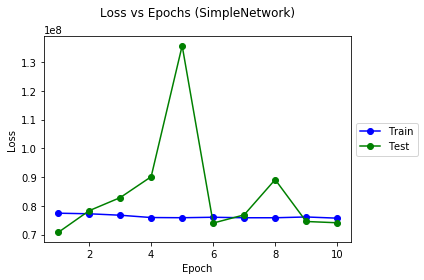

In [9]:
plot_multi_curves(epoch_list, [supervised_train_loss_list, supervised_test_loss_list], 'Epoch', 'Loss', ['Train', 'Test'], 'Loss vs Epochs (SimpleNetwork)')

In [16]:
if 120931 in train_indices:
    print('train')
elif 120931 in test_indices:
    print('test')

train
